# Feature Extraction Using Histogram
히스토그램을 활용해서 각 가맹점 별 변수 분포를 알아보고자 한다  
유의미한 결과가 나올 경우, 기존 피쳐를 수정하거나 새롭게 추가함

In [3]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

pd.set_option('display.max_rows', 100)
# path = 'c:/windows/fonts\\NanumGothic.ttf'
# path = 'malgungothic'
mpl.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = path
plt.style.use('seaborn')

In [4]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


In [5]:
train_raw = samp_cst_feat.merge(samp_train, how='left', on='cst_id_di')
train_raw.head(3)

,cst_id_di,VAR002,VAR003,VAR004,VAR005,VAR006,VAR007,VAR008,VAR009,VAR010,...,VAR219,VAR220,VAR221,VAR222,VAR223,VAR224,VAR225,VAR226,VAR227,MRC_ID_DI
0,90000000089,-0.06610,0.5280,-0.13607,0.10945,0.06557,0,0.7702,-0.18965,0.1981,...,0.19113,0.05449,0.09471,0.27091,0.01931,0.02938,0.17105,0.12537,0.22197,0
1,90000000176,-0.09537,0.1347,-0.13541,0.17331,-0.19657,0,0.0616,-0.23104,0.4940,...,0.19437,0.06538,0.16309,0.30207,0.06053,-0.01107,0.12413,0.29702,-0.31717,8
2,90000000210,-0.01048,0.8360,0.37797,-0.10970,0.52032,1,0.3257,0.32632,0.7343,...,-0.52084,-0.18568,-0.09755,-0.56565,-0.17840,-0.06314,-0.17111,-0.32239,0.33962,0


## 각 가맹점별 히스토그램
가맹점별로 히스토그램을 그려본다

In [6]:
def histForEachFranchise(var_num, franchise_group=None, bins=10, margin=0.3):
    '''궁금한 VAR변수에 대하여 각 프렌차이즈 점 별로 히스토그램 시각화
    var_num: integer, VAR 번호
    franchise_group: list, 관찰할 가맹점 번호. 입력하지 않으면 전체 가맹점 관찰
    margin: float in range 0 to 1, 시각화 결과가 더 잘 보이도록 마진 값 지정'''
    var = 'VAR' + str(var_num).zfill(3)
    plt.figure(figsize=(10,6))
    maxValue, minValue = train_raw[var].max(), train_raw[var].min()
    if franchise_group:
        for i in franchise_group:
            sns.distplot(getFranchise(i)[var], 
                         label=f'Franchise {i}, {getFranchise(i)[var].shape[0]} samples', 
                         bins=bins)
        plt.xlim(minValue - abs(minValue*margin), maxValue + abs(maxValue*margin))
        plt.legend()
        plt.suptitle(f'Histogram of {var}')
        plt.show()
    else:
        for i in range(1,11):
            sns.distplot(getFranchise(i)[var], 
                         label=f'Franchise {i}, {getFranchise(i)[var].shape[0]} samples',
                         bins=bins)
        plt.xlim(minValue - abs(minValue*margin), maxValue + abs(maxValue*margin))
        plt.legend()
        plt.suptitle(f'Histogram of {var}')
        plt.show()
        
def getCustomerGroup(group, complement=False):
    '''
    특정 가맹점을 이용한 고객의 고객식별번호를 리턴
    group: list, 가맹점 번호가 성분임
    complement: boolean, 입력한 group에 해당하지 않는 고객(여집합)을 가져올 경우 True
    ---
    Return: 고객ID list
    '''
    return (samp_train[~samp_train['MRC_ID_DI'].isin(group)]['cst_id_di'].tolist() if complement 
            else samp_train[samp_train['MRC_ID_DI'].isin(group)]['cst_id_di'].tolist())

def getFranchise(num, data=None, reset_index=False):
    '''특정 가맹점을 방문한 고객에 대한 데이터만 추출'''
    if data is None:
        data = train_raw
    if isinstance(num, int):
        idx = getCustomerGroup(group=[num])
    else:
        idx = getCustomerGroup(group=num)
    if reset_index:
         return data[data['cst_id_di'].isin(idx)].reset_index(drop=True)
    return data[data['cst_id_di'].isin(idx)]

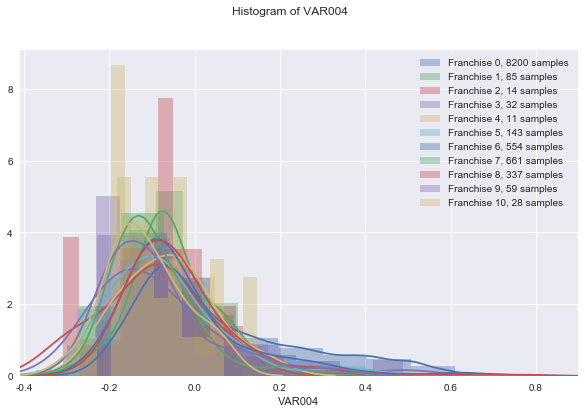

In [7]:
histForEachFranchise(var_num=4, franchise_group=range(11), margin=0.1, bins=11)

예상보다 모두 비슷한 곳에 뭉쳐있어 눈에 띄는 구분이 어렵고, 해당 VAR 변수에서 가맹점별로 특별한 차이가 보이는지 확인하기 어려움  
구간을 나누었을 때, 가장 빈도가 많이 나온 구간을 기준으로도 확인해보자

In [8]:
def topFreq(var_num, franchise_group, bins=10, top=1):
    '''어떤 가맹점에 대하여 특정 VAR의 높은 빈도 구간을 리턴'''
    var = 'VAR' + str(var_num).zfill(3)
    hist, bins = np.histogram(getFranchise(num=franchise_group, reset_index=True)[var])
    
    if top > 1:
        sort_idx = np.argsort(-hist)[:top]
        bins_list = []
        for idx in sort_idx:
            bins_list.append(bins[[idx, idx+1]])
        return bins_list
    else:
        argmax = np.argmax(hist)
        return bins[[argmax, argmax+1]]
    
    
# def getInterval(var_num, franchise_group, bins=10, top=1):
#     var = 'VAR' + str(var_num).zfill(3)
#     if isinstance(franchise_group, list) and len(franchise_group) >= 2:
#         for f in franchise_group:
#             topFreq(var, f, bins=bins, top=top)

딱히 좋은 기준이 될 것 같지 않음. 일단 보류

### 시각적 개선 및 합리적 기준 마련
동등하게 구간을 나누어서 구간별로 빈도의 감소 정도를 살펴보는 것도 가치가 있을 듯

#### 전체 데이터 내 각 가맹점별 비율(Density)

In [9]:
frequency_table = (train_raw['MRC_ID_DI']
        .value_counts()
        .to_frame('Freq')
        .reset_index()
        .rename({'index': 'MRC_ID_DI'}, axis=1))
display(frequency_table)

frenchiseFreq = {row['MRC_ID_DI']:row['Freq'] 
                 for _, row in frequency_table.iterrows()}
print('가맹점 별 Frequency', frenchiseFreq)

,MRC_ID_DI,Freq
0,0,8200
1,7,661
2,6,554
3,8,337
4,5,143
5,1,85
6,9,59
7,3,32
8,10,28
9,2,14


가맹점 별 Frequency {0: 8200, 7: 661, 6: 554, 8: 337, 5: 143, 1: 85, 9: 59, 3: 32, 10: 28, 2: 14, 4: 11}


#### 위에서 구한 비율에 기반한 각 가맹점별 비율
전체 데이터에 대하여 나누어둔 구간을 바탕으로, 구간 마다 각 가맹점의 Density를 확인한다  
각 구간마다 유달리 Density가 높은 가맹점이 있으면, 그 가맹점의 특징이라고 볼 수 있겠지  
또한, 시각적인 확인에는 한계가 있으니, 수치적인 기준을 가지고 전체 VAR 변수들에 대해 일반화된 preprocessing을 고민해봐야 함

In [117]:
def showFranchiseDensity(var_num, bins=11, data=None, franchise_group=None, 
                         plot=True, figsize=(16,6)):
    if data is None:
        data = train_raw.copy()
    if franchise_group is None:
        frequency_table = (train_raw['MRC_ID_DI']
                           .value_counts()
                           .to_frame('Freq')
                           .reset_index()
                           .rename({'index': 'MRC_ID_DI'}, axis=1))

        franchiseFreq = {row['MRC_ID_DI']:row['Freq'] 
                         for _, row in frequency_table.iterrows()}
        franchise_group = [i for i in range(11)]
    else:
        frequency_table = (data['MRC_ID_DI']
                           .value_counts()
                           .to_frame('Freq')
                           .reset_index()
                           .rename({'index': 'MRC_ID_DI'}, axis=1))

        franchiseFreq = {row['MRC_ID_DI']:row['Freq'] 
                         for _, row in frequency_table.iterrows()}
    if isinstance(var_num, int):
        var = 'VAR' + str(var_num).zfill(3)
    else:
        var = var_num
        
    partial = data[[var, 'MRC_ID_DI']]
    hist, quantiles =  np.histogram(partial.iloc[:, 0], bins=bins)

    result_raw = {}
    for group in franchise_group:
        density_list = []
        for i in range(bins):
            partialpartial = partial[partial['MRC_ID_DI'] == group]
            density = (len(partialpartial[
                (partialpartial[var] >= quantiles[i]) & 
                (partialpartial[var] <= quantiles[i + 1])
            ]) / franchiseFreq[group])
            density_list.append(density)
        result_raw[group] = density_list

    result = (pd.melt(
        (pd.DataFrame(result_raw)
         .reset_index()
         .rename({'index':'interval_Id'}, axis=1))
        , id_vars='interval_Id')
                  .rename({'variable':'MRC_ID_DI', 'value':'density'}, axis=1))
    
    if plot:
        plt.figure(figsize=figsize)
        sns.barplot(x='interval_Id', y='density', hue='MRC_ID_DI', data=result,
                   palette=sns.color_palette("Paired"))
        plt.title('Density for each Franchise')
        plt.show()
        
    return result

> 예: VAR084  
    - 가맹점 미이용 고객(MRC_ID_DI=0)의 경우 구간 0에 압도적으로 많이 분포함  
    - 가맹점 10의 경우 구간 0, 4, 5에서 특히 많이 등장  
    - 가맹점 8의 경우 구간 0에 대부분 분포되어있으나, 나머지 구간은 희미하게 분포  
    - 가맹점 3은 구간 4에 가장 많이 분포되어있고, 다른 가맹점들에 비해서도 유독 많음 -> 구간 4가 가맹점 3의 특색 구간이라 볼 수 있음

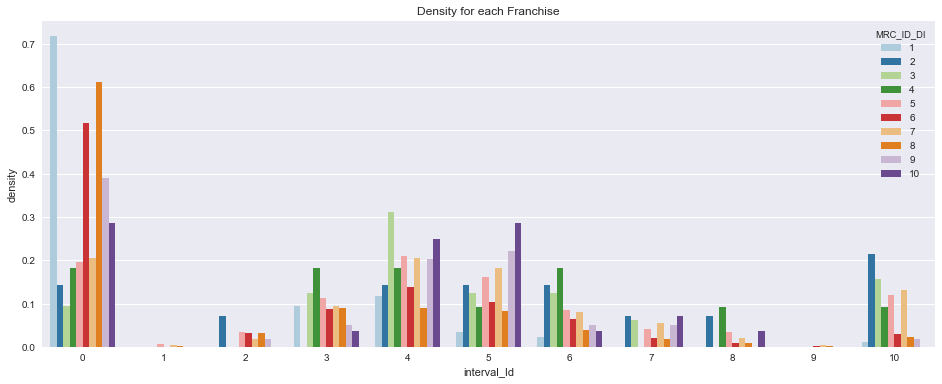

,interval_Id,MRC_ID_DI,density
0,0,1,0.717647
1,1,1,0.000000
2,2,1,0.000000
3,3,1,0.094118
4,4,1,0.117647


In [11]:
temp = showFranchiseDensity(var_num=84, franchise_group=range(1,11))
temp.head()

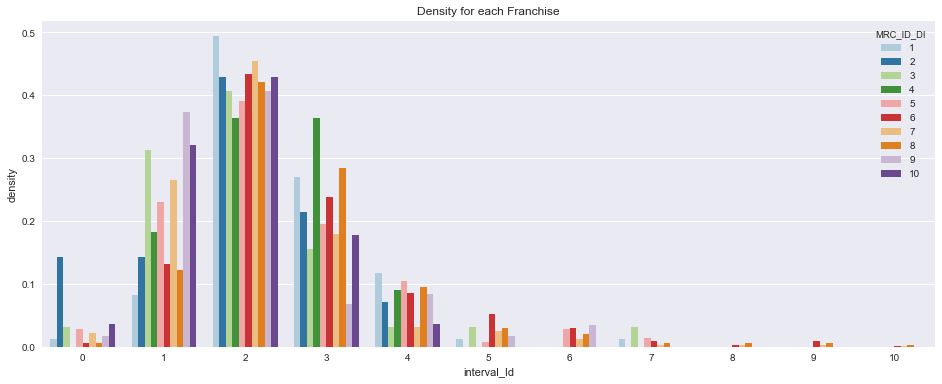

,interval_Id,MRC_ID_DI,density
0,0,1,0.011765
1,1,1,0.082353
2,2,1,0.494118
3,3,1,0.270588
4,4,1,0.117647


In [12]:
temp = showFranchiseDensity(var_num=4, franchise_group=range(1,11))
temp.head()

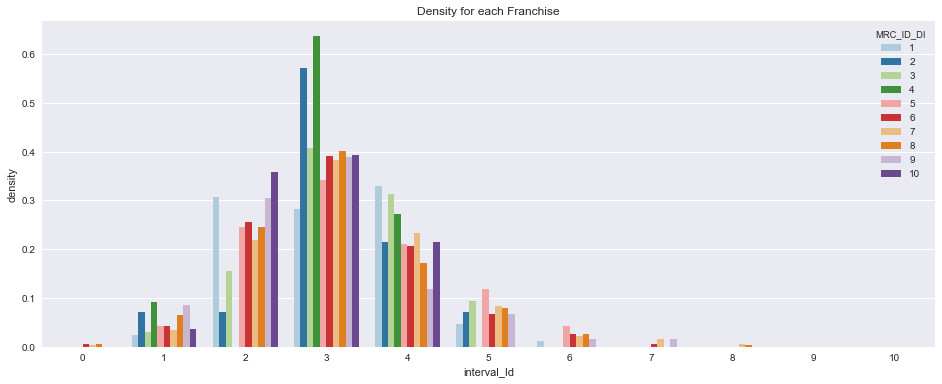

,density
interval_Id,
0,0.001551
1,0.023846
2,0.085501
3,0.104919
4,0.063011
5,0.021308
6,0.010381
7,0.006572
8,0.002181


In [32]:
temp = showFranchiseDensity(var_num=81, franchise_group=range(1,11))
temp[temp['density'] != 0].groupby('interval_Id').std()

!!! 지금 이 히스토그램을 이진으로 생각해보는거지 => feature selection을 자동화할 수 있을 것 같아

각 구간의 가맹점별 Density 분포로부터 분산을 구하고, 분산이 높은 변수를 추출해보면 좋을듯?

In [124]:
def franchiseLabeling(franchise_num=1, dropID=True, verbose=True):
    '''각 가맹점 별로 학습 환경을 조성하기 위한 함수
    franchise_num: 레이블링 기준이 될 가맹점 번호
    dropID: 고객ID를 제거할지 여부'''
    result = samp_cst_feat.merge(samp_train, how='left', on='cst_id_di')
    idx = result[result['MRC_ID_DI'] == franchise_num].index
    result['MRC_ID_DI'] = 0
    result.loc[idx, 'MRC_ID_DI'] = 1
    if verbose:
        print(f'가맹점 Category: {franchise_num}')
        print(f'회원ID 컬럼 제거 여부: {dropID}')
    if dropID:
        return result.drop('cst_id_di', axis=1)
    return result

가령 아래와 같이 가맹점 10에 대하여 살펴보는 것을 생각해보자.  
VAR100을 보니, 확연히 가맹점 10인 것과, 그렇지 않은 것의 분포 차이가 확실히 남을 확인할 수 있다.

가맹점 Category: 10
회원ID 컬럼 제거 여부: True


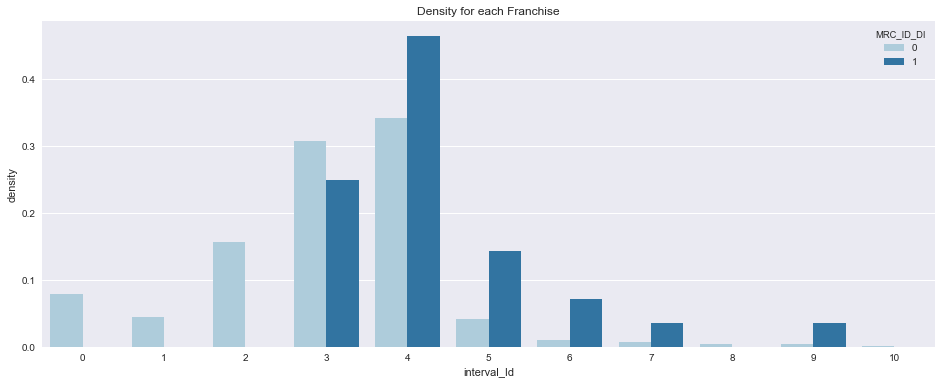

interval_Id
0     0.056241
1     0.031237
2     0.110590
3     0.041183
4     0.086737
5     0.071389
6     0.043084
7     0.020001
8     0.003152
9     0.022102
10    0.000910
Name: density, dtype: float64

0.044238743658011566


In [105]:
temp = showFranchiseDensity(data=franchiseLabeling(franchise_num=10, dropID=True),
                            var_num=100,
                            franchise_group=[0, 1]
                           )
display(temp.groupby('interval_Id')['density'].std())
print(temp.groupby('interval_Id')['density'].std().mean())

가맹점 Category: 10
회원ID 컬럼 제거 여부: True


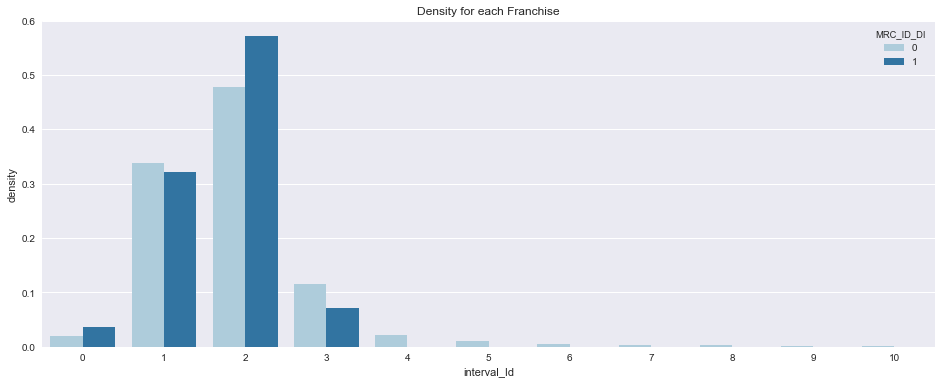

interval_Id
0     0.011176
1     0.011967
2     0.066266
3     0.031647
4     0.015969
5     0.007424
6     0.003712
7     0.002802
8     0.001751
9     0.001541
10    0.000630
Name: density, dtype: float64

0.0140804291435566


In [110]:
temp = showFranchiseDensity(data=franchiseLabeling(franchise_num=10, dropID=True),
                            var_num='VAR065',
                            franchise_group=[0, 1]
                           )
display(temp.groupby('interval_Id')['density'].std())
print(temp.groupby('interval_Id')['density'].std().mean())

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


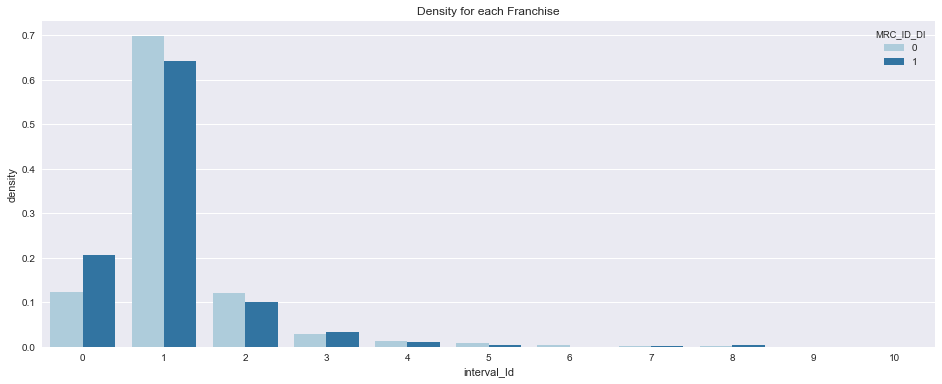

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


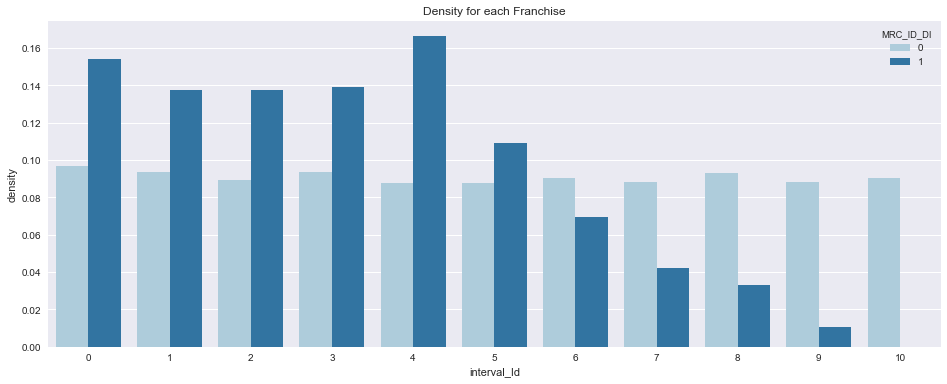

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


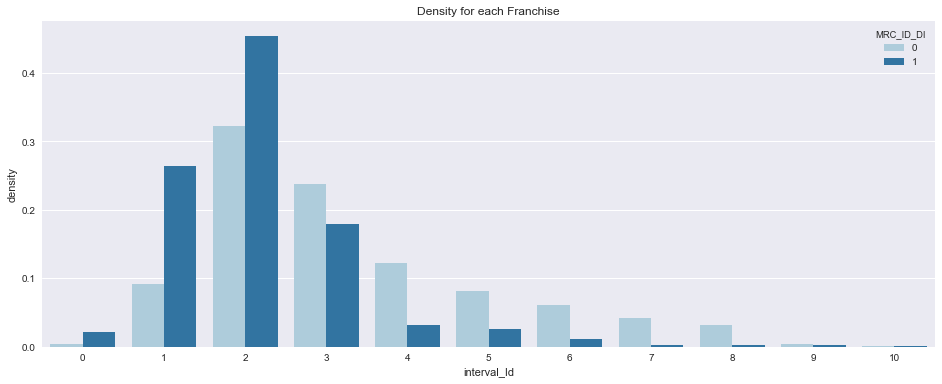

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


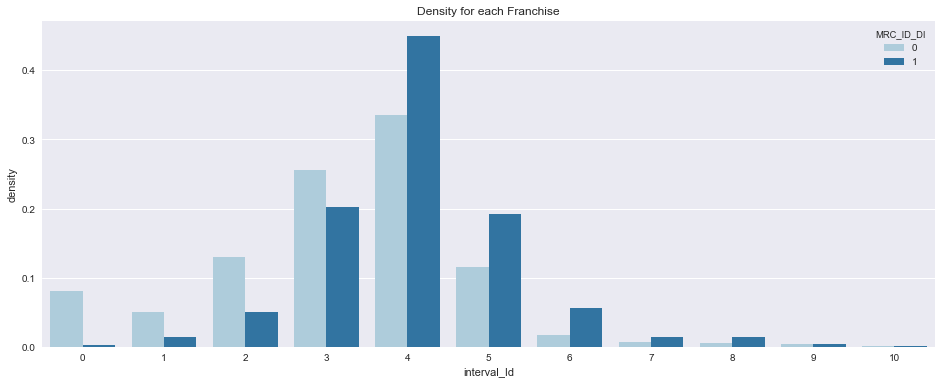

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


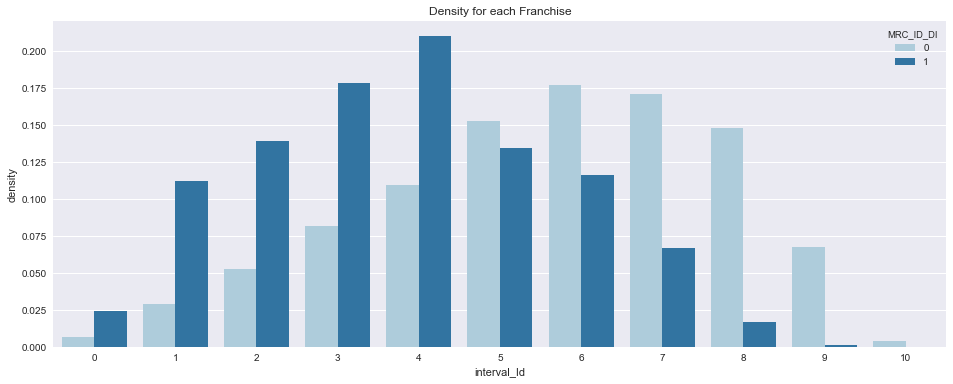

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


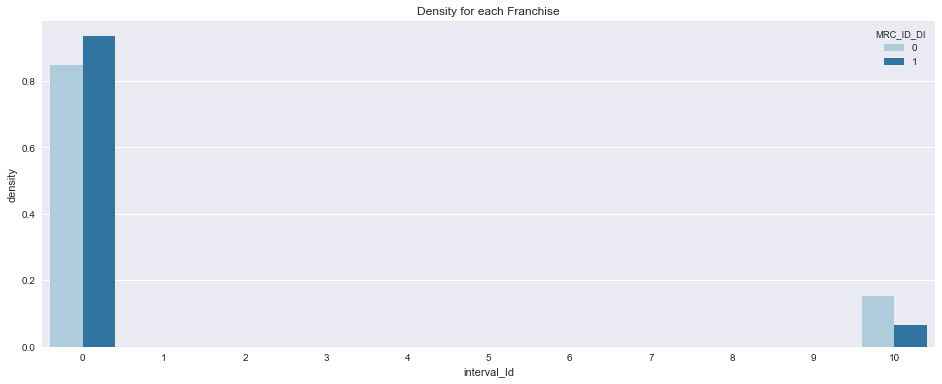

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


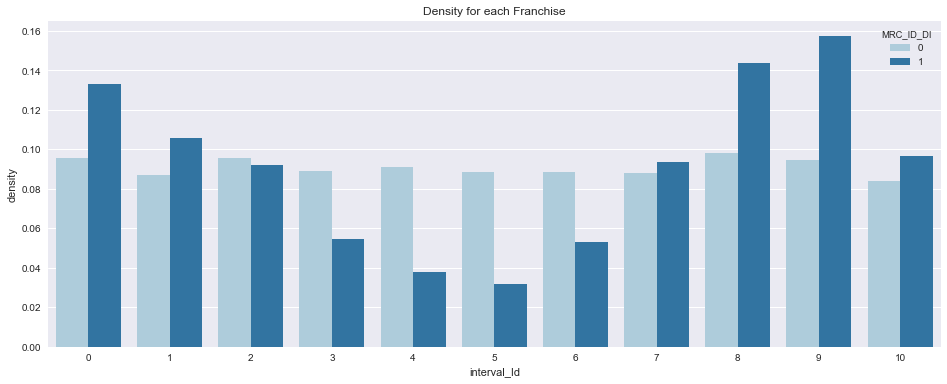

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


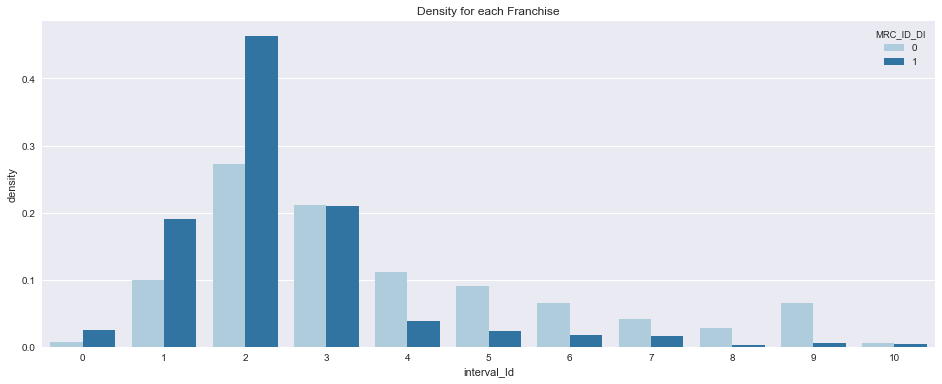

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


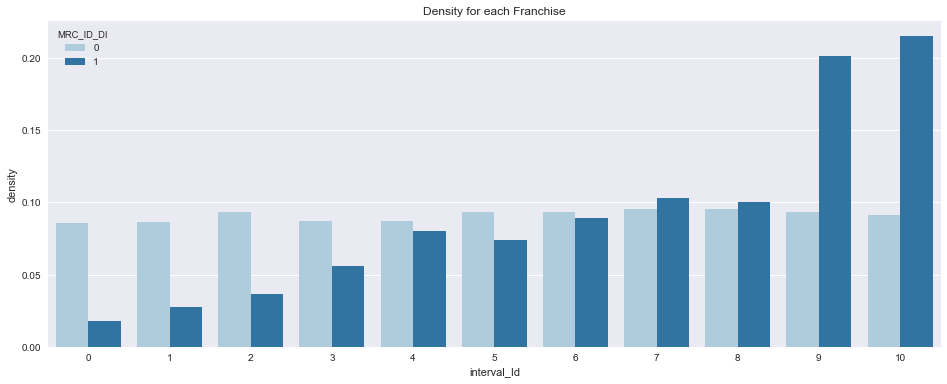

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


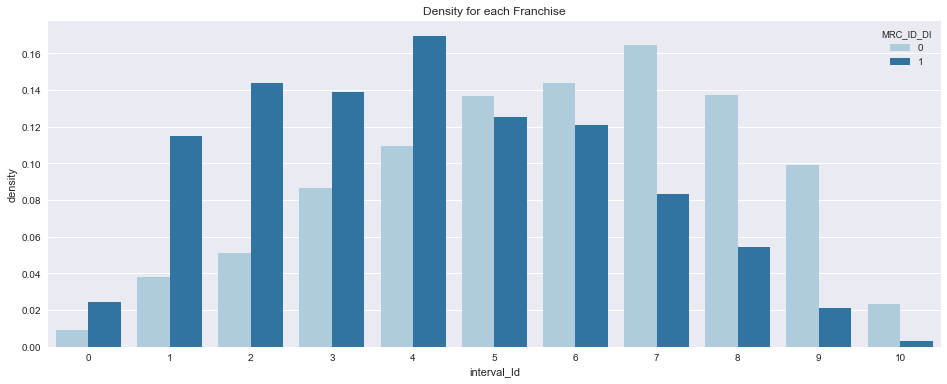

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


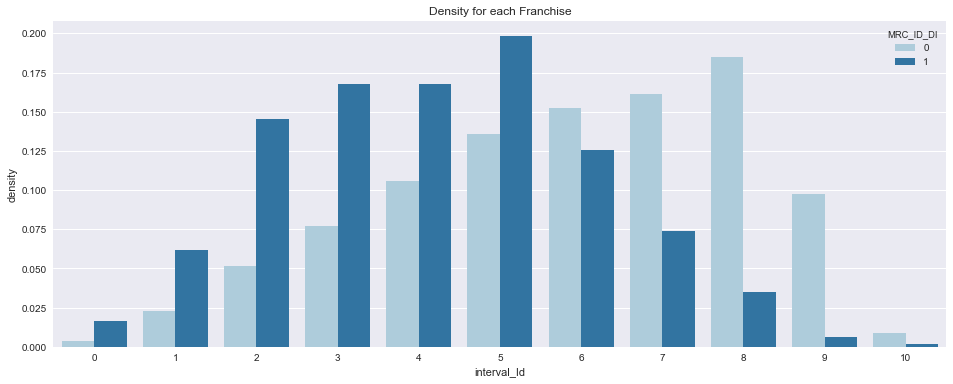

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


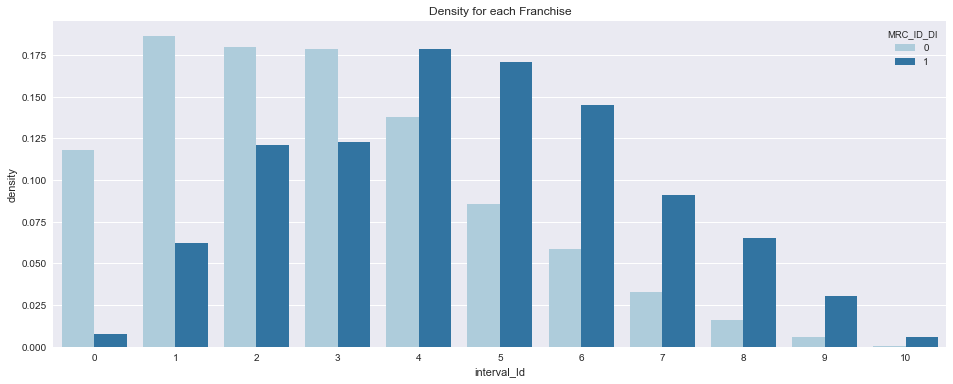

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


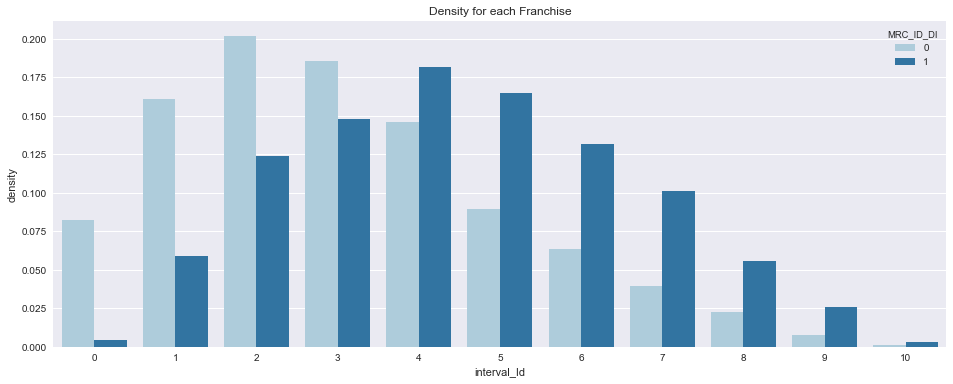

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


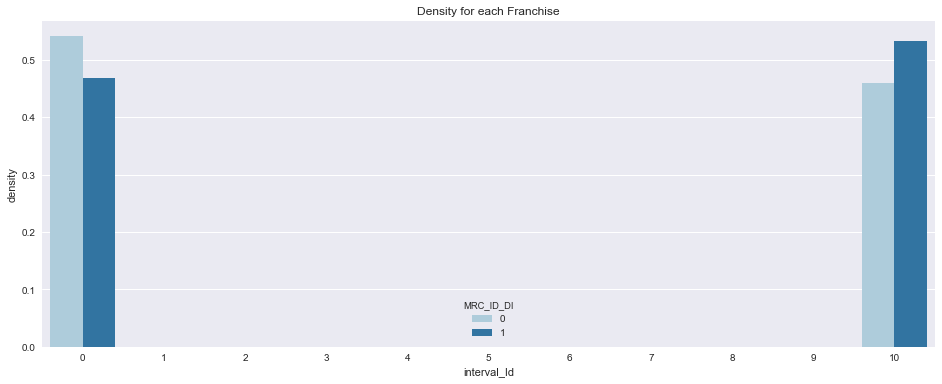

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


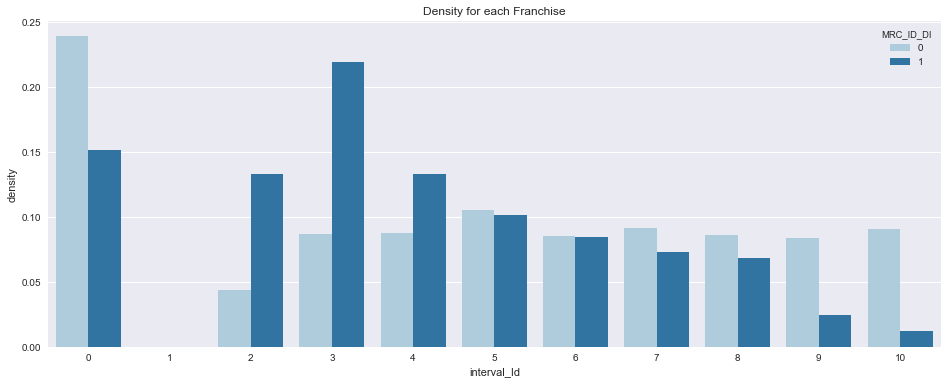

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


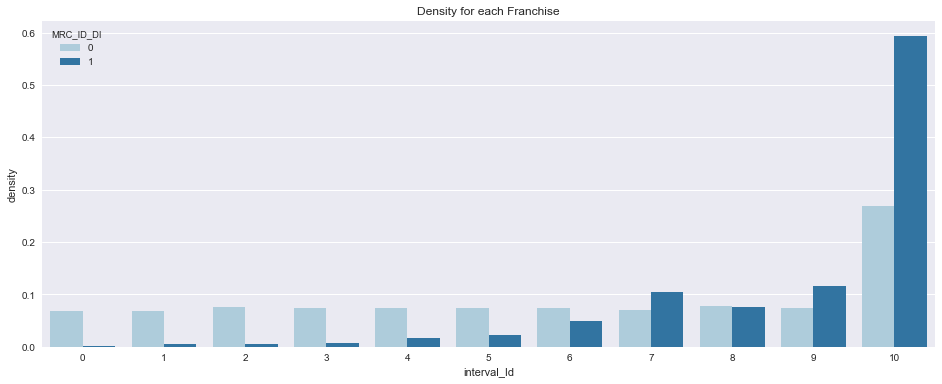

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


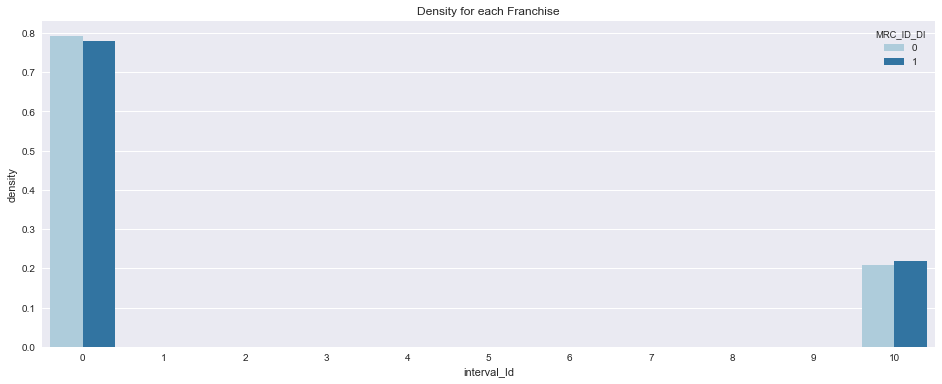

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


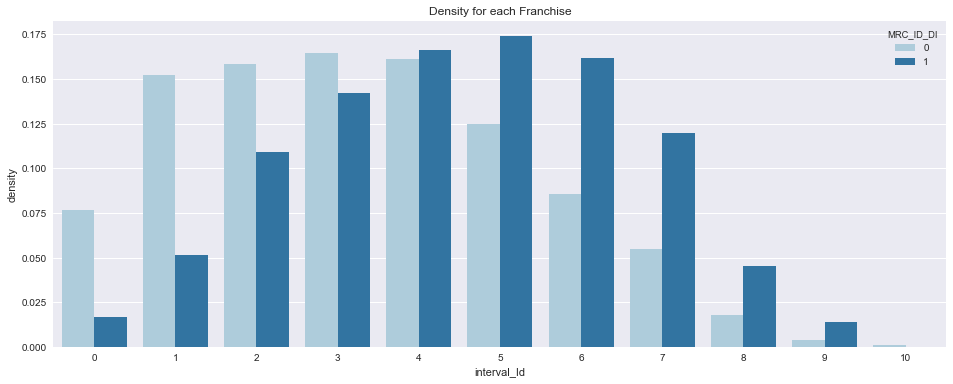

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


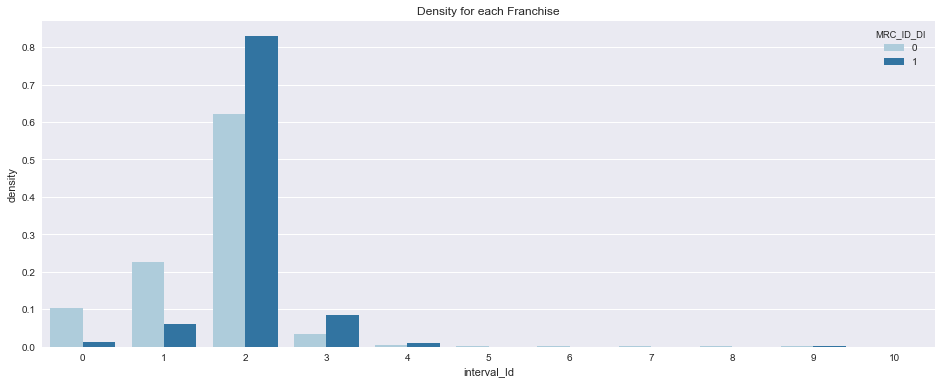

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


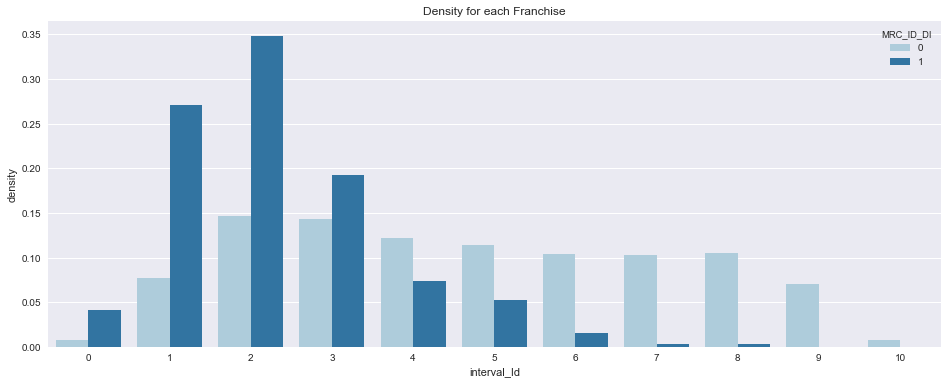

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


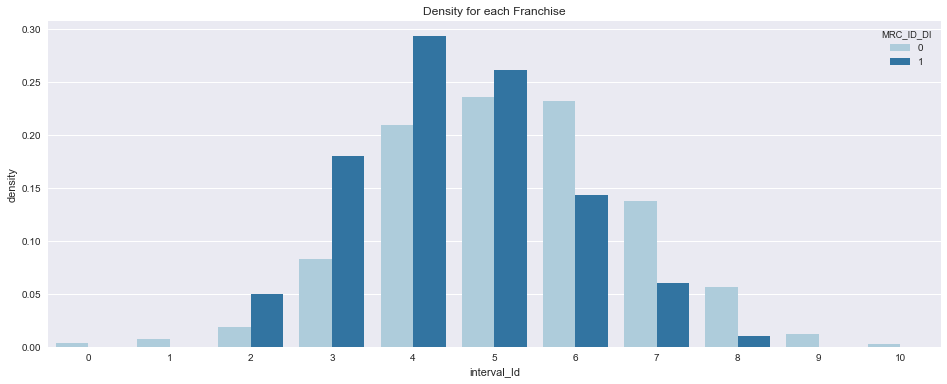

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


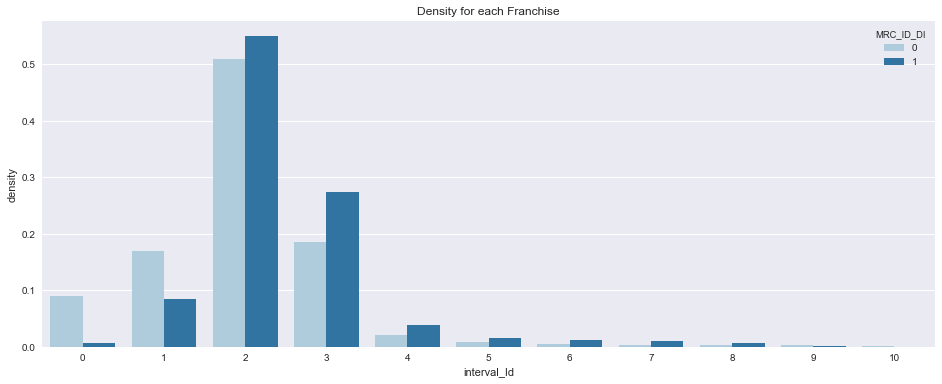

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


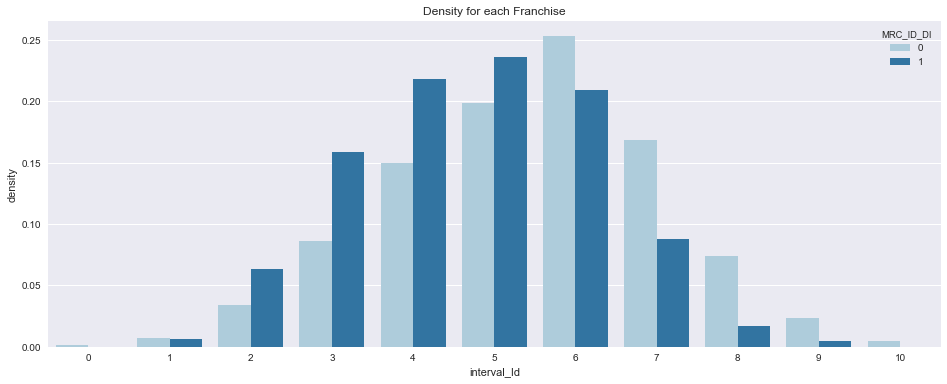

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


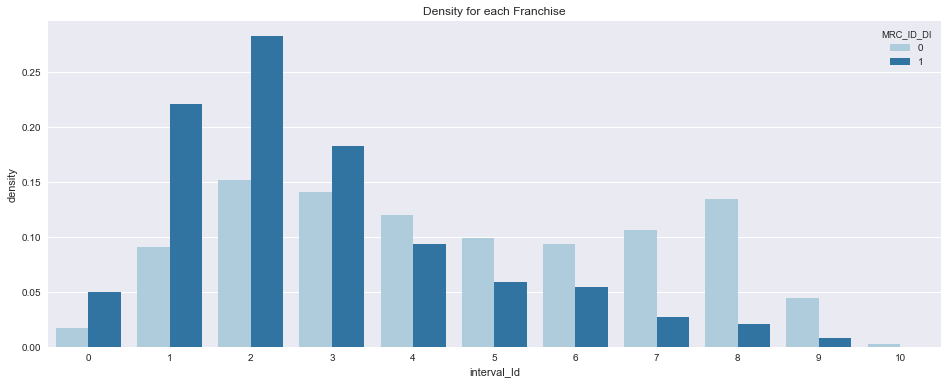

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


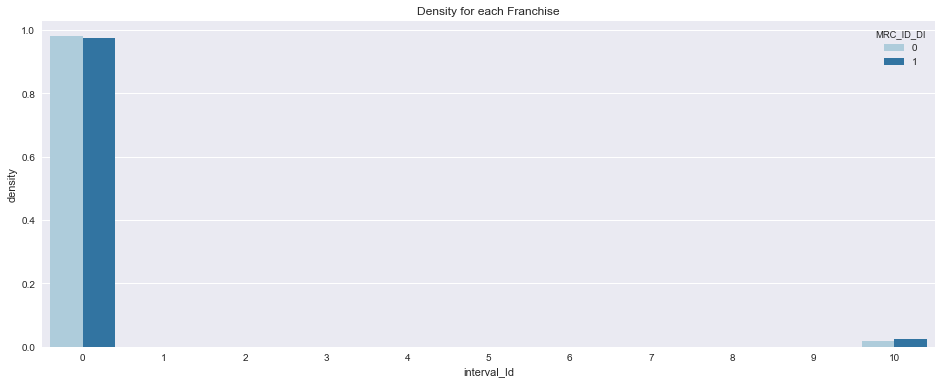

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


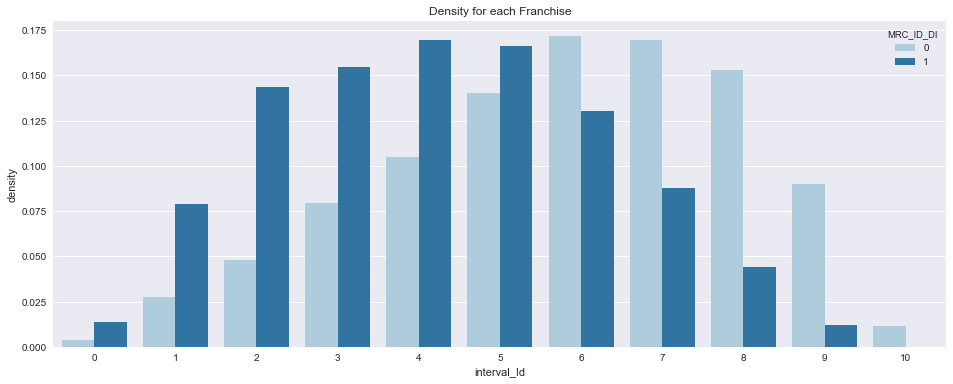

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


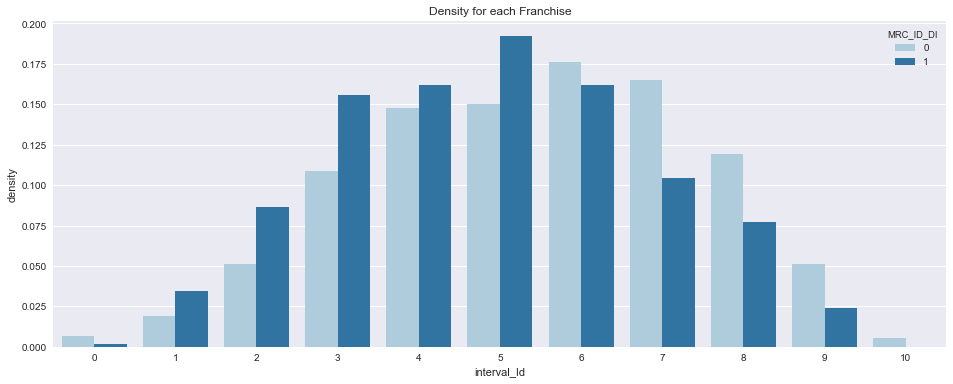

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


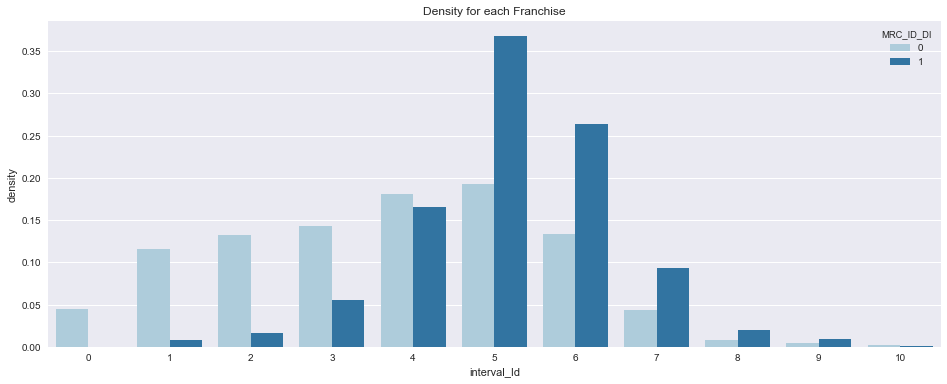

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


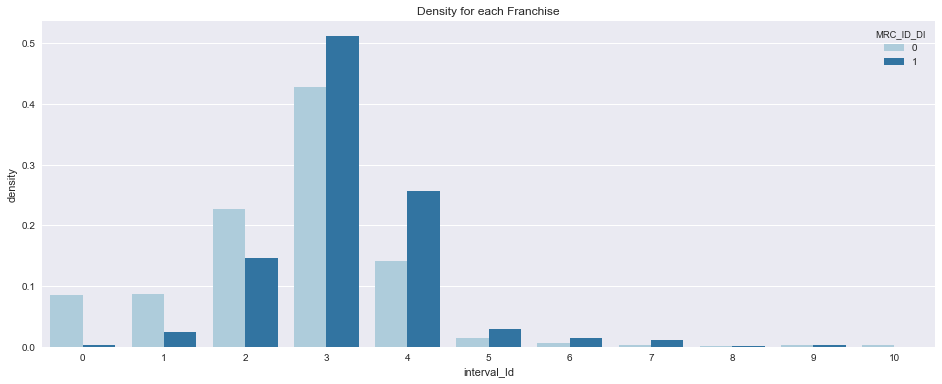

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


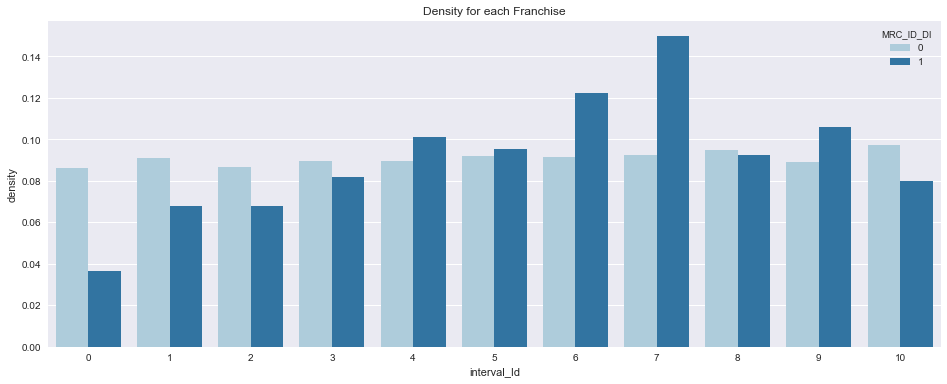

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


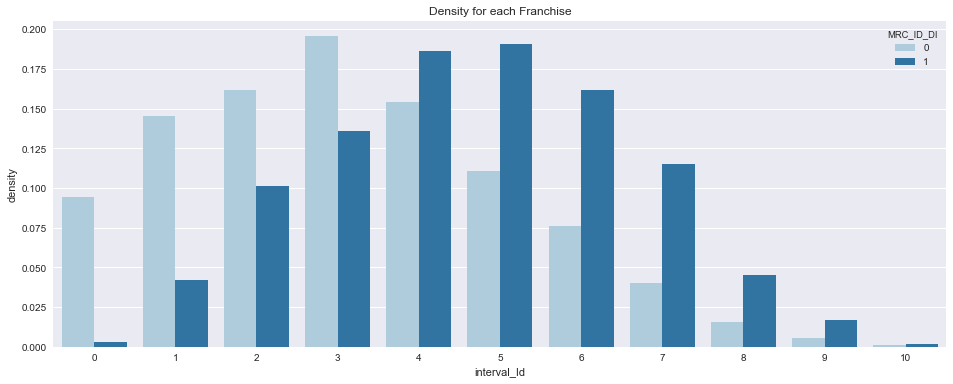

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


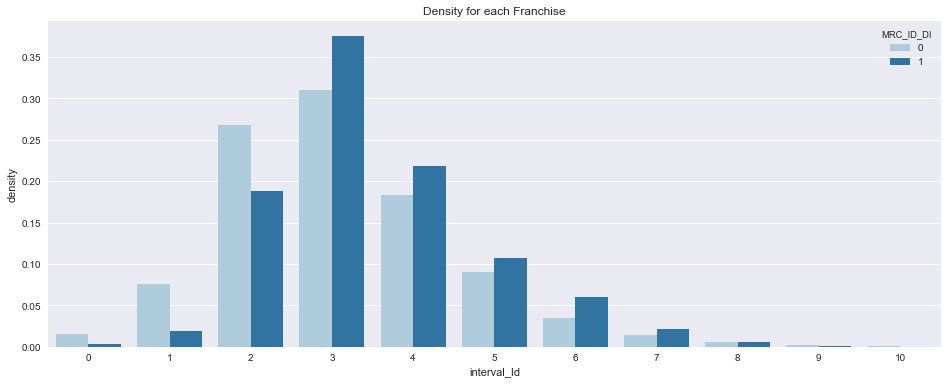

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


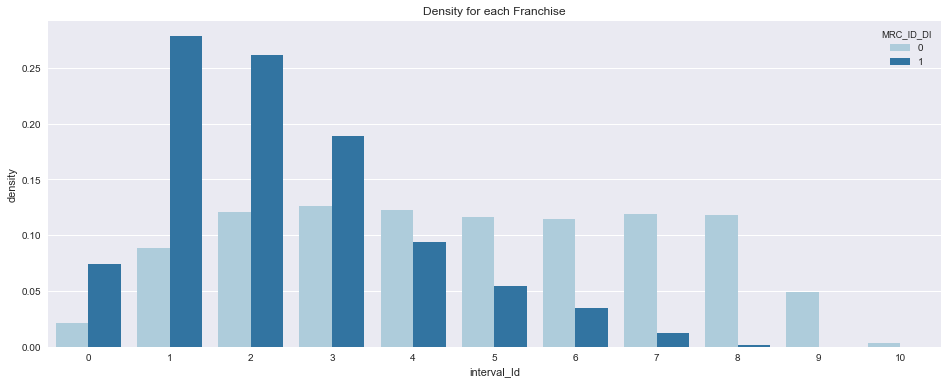

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


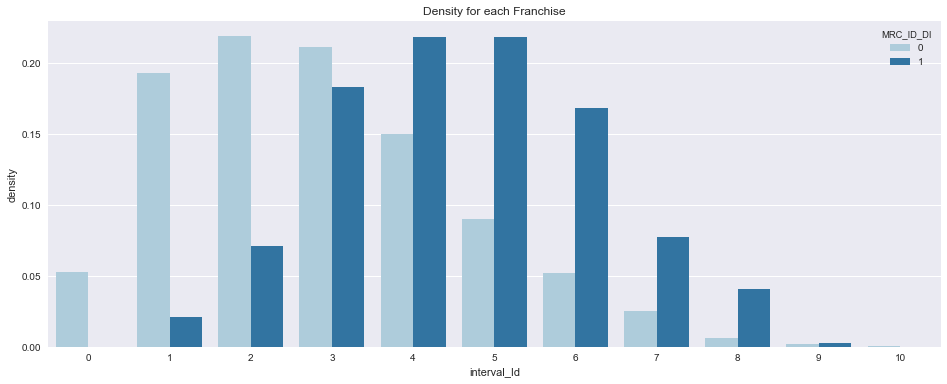

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


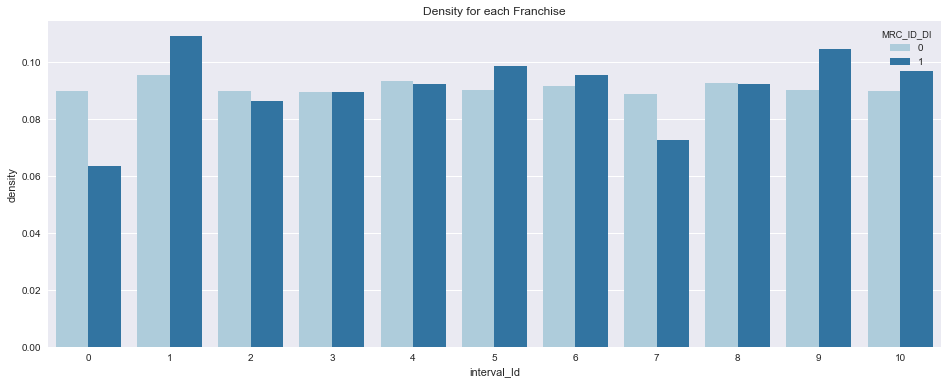

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


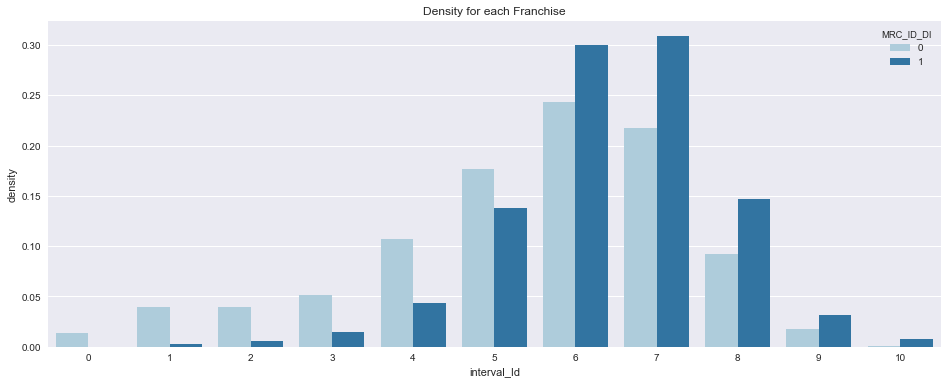

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


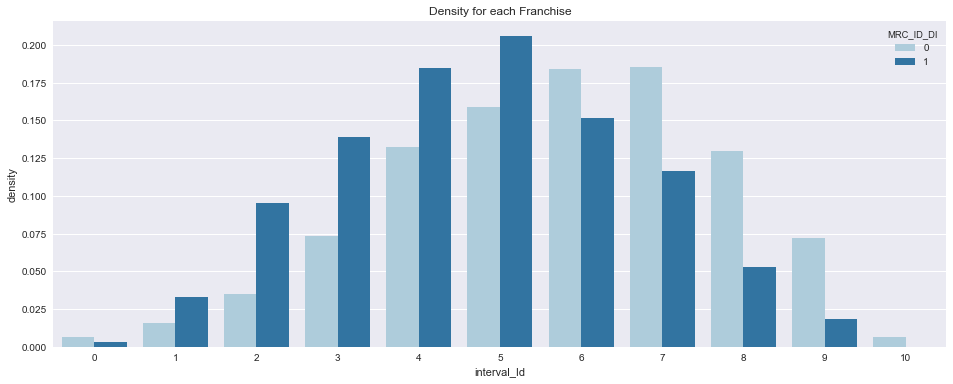

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


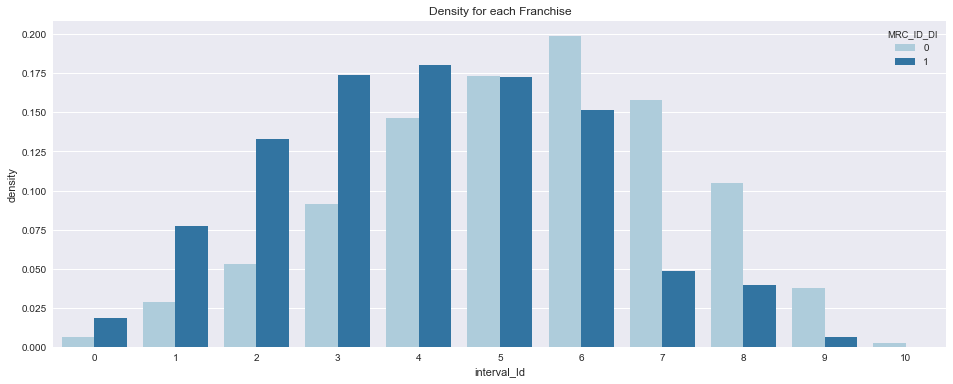

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


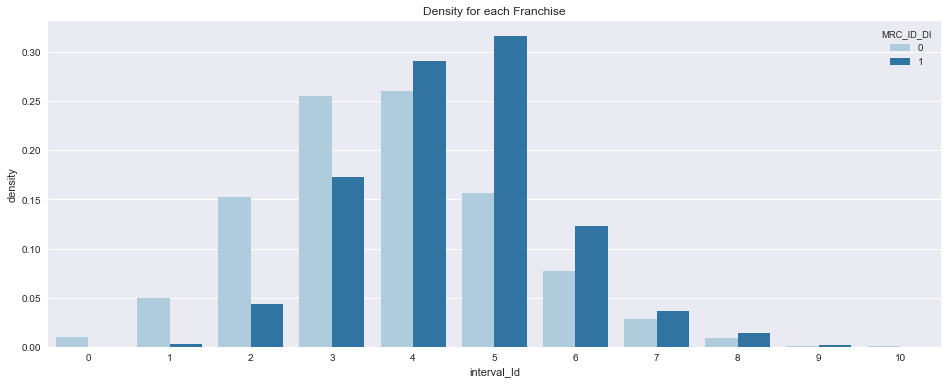

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


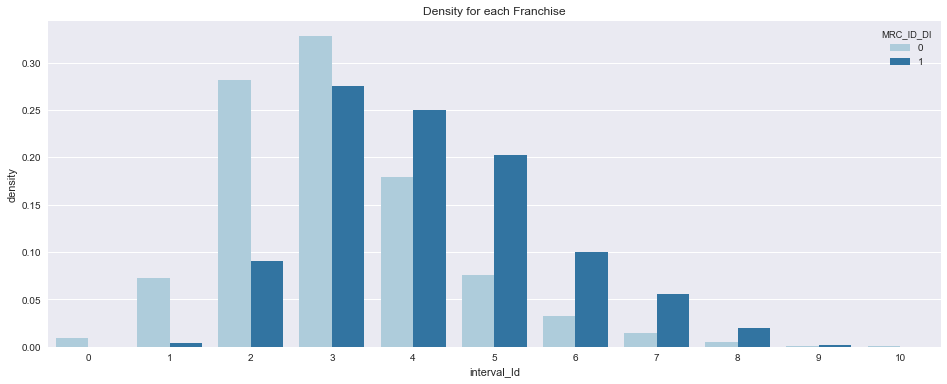

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


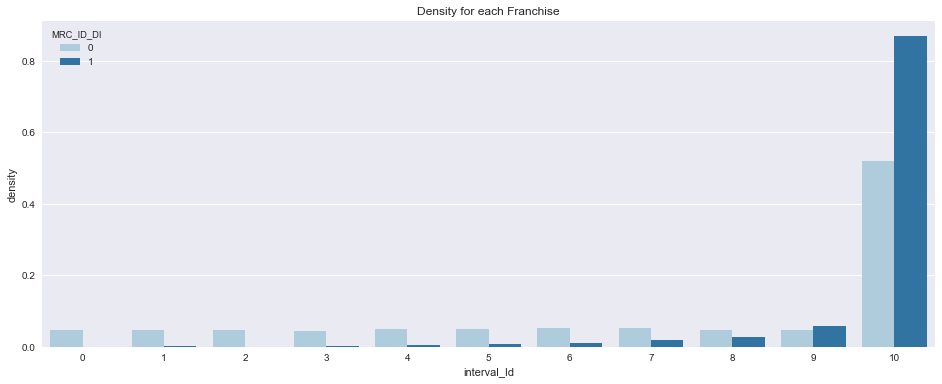

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


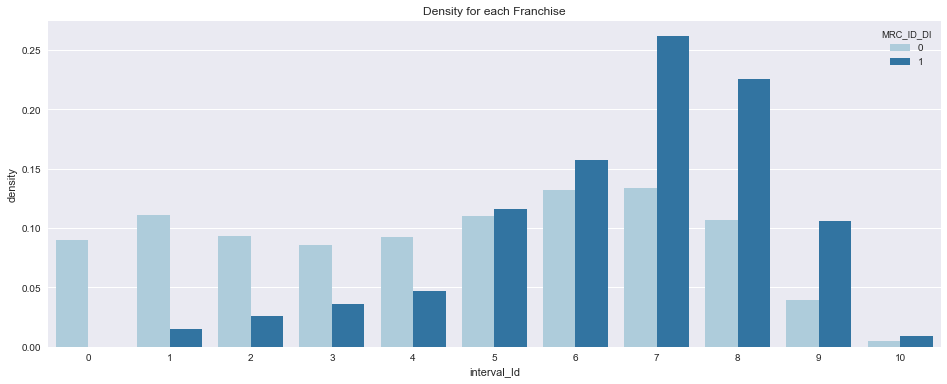

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


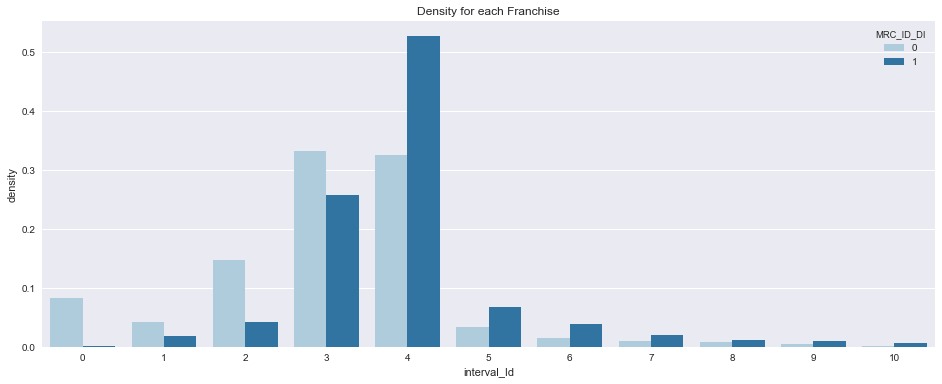

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


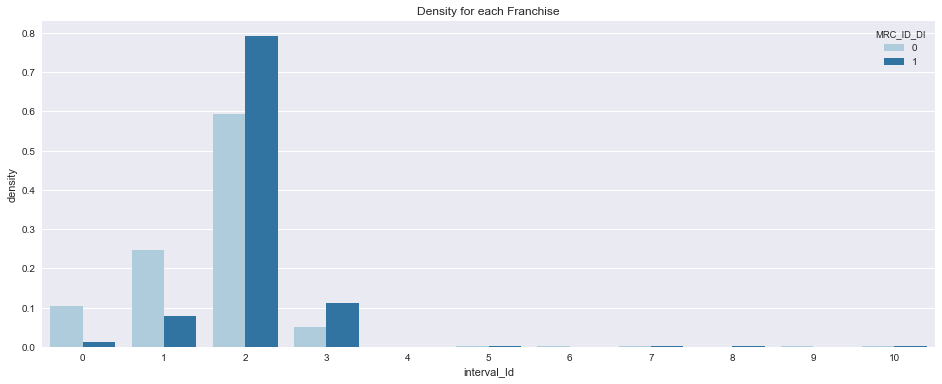

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


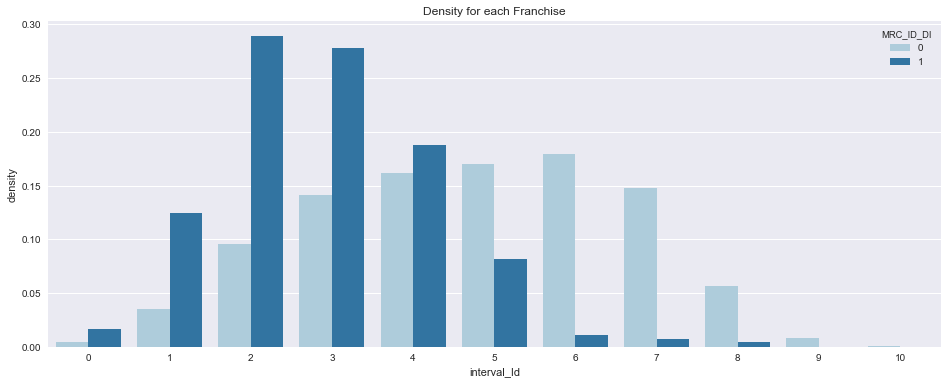

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


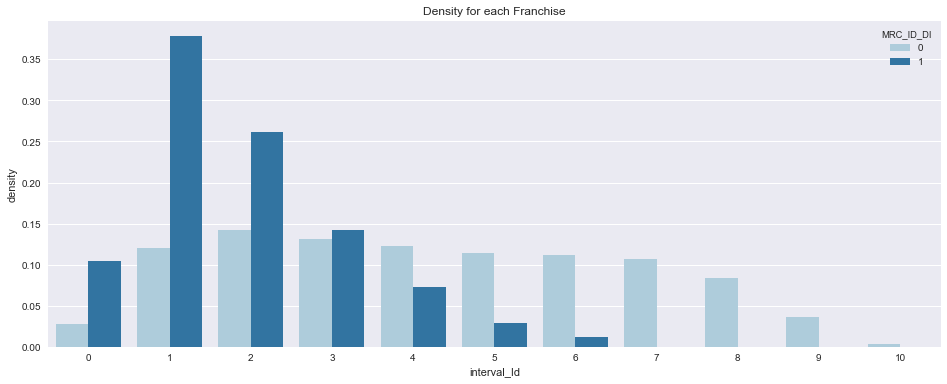

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


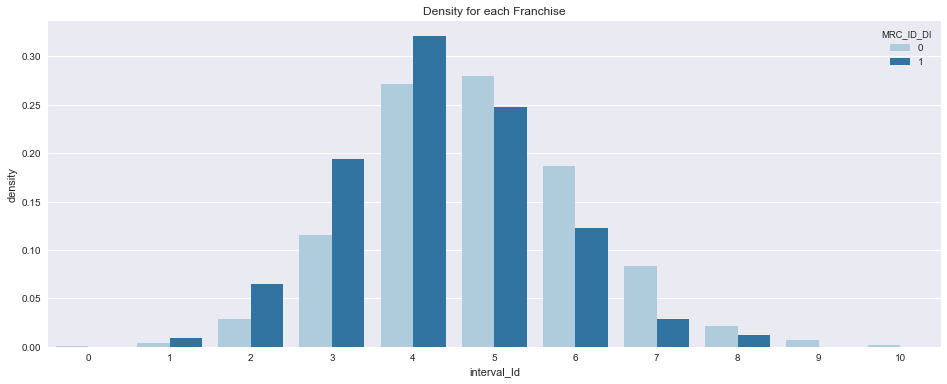

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


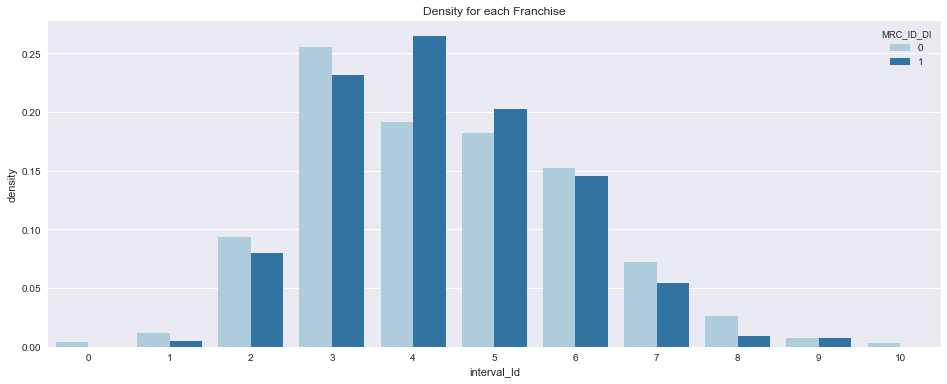

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


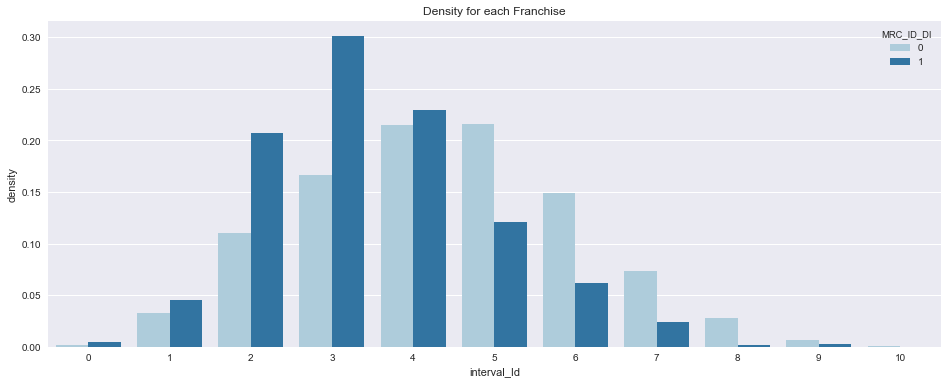

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


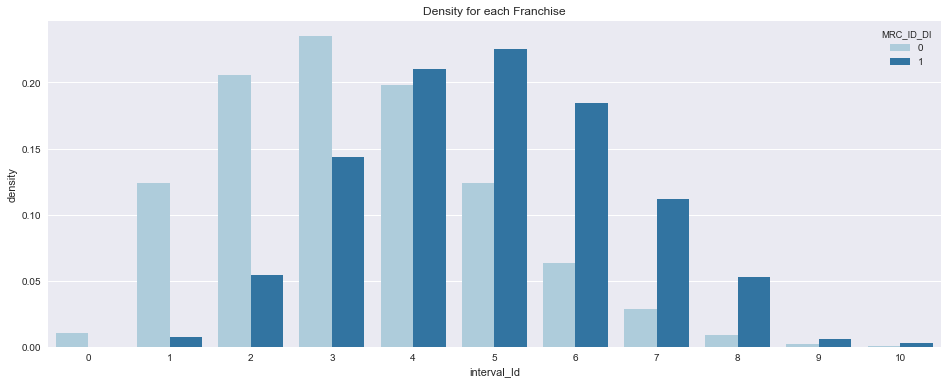

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


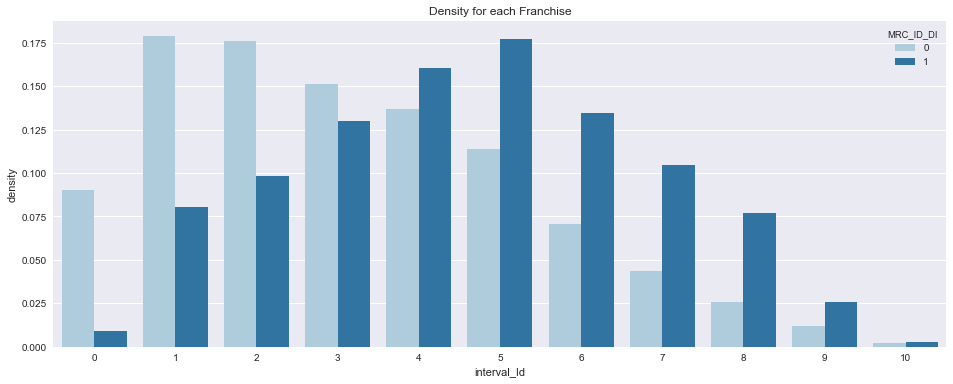

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


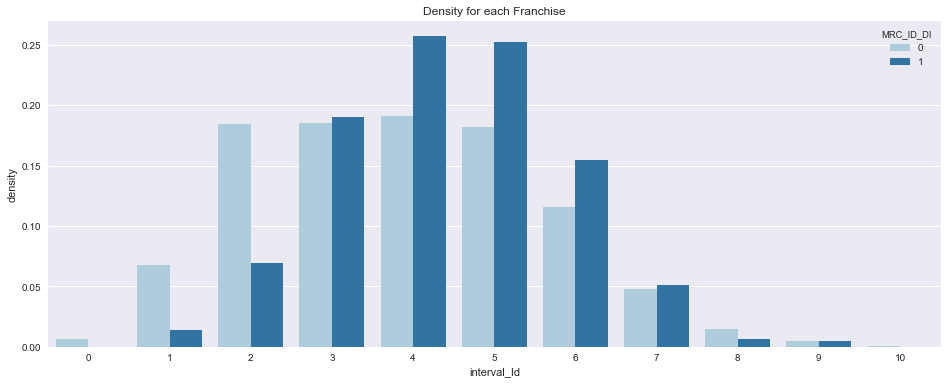

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


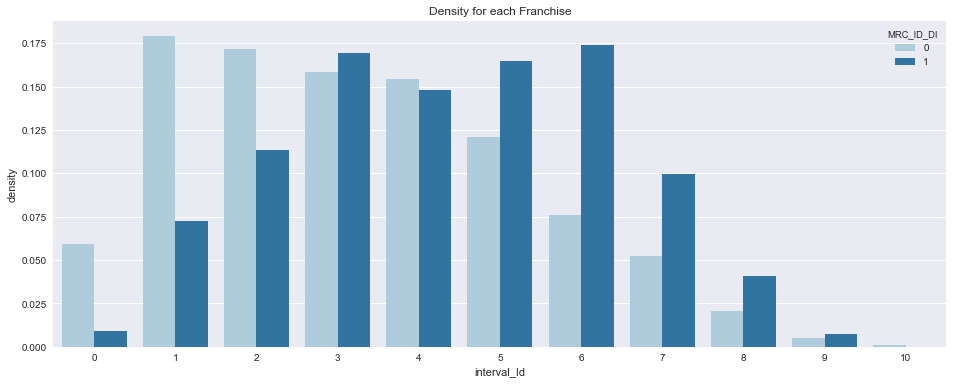

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


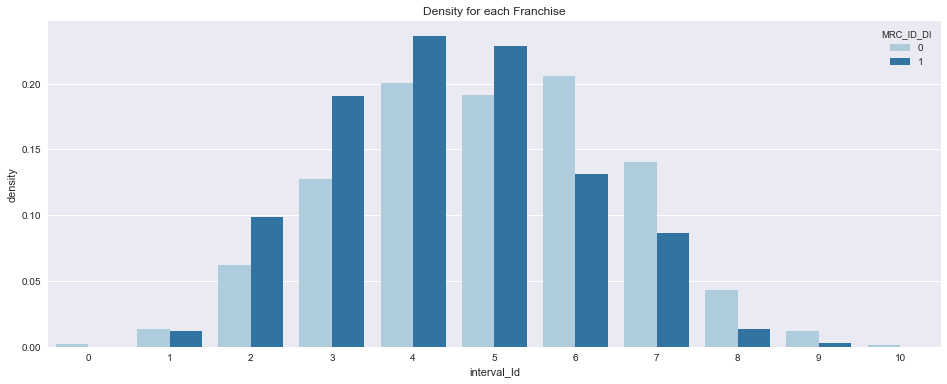

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


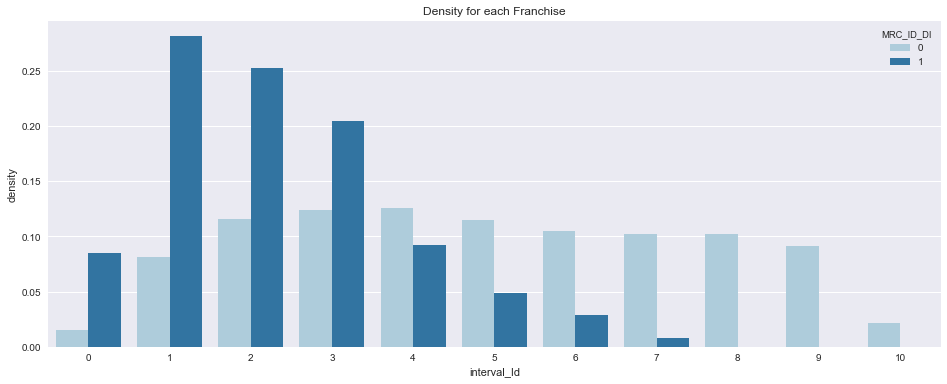

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


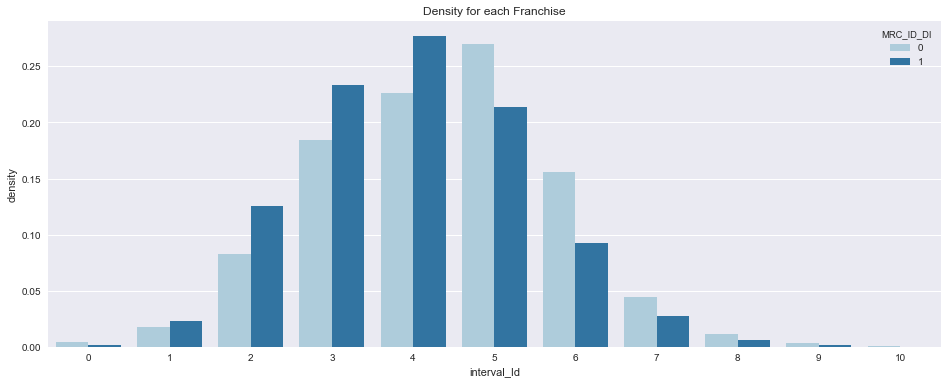

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


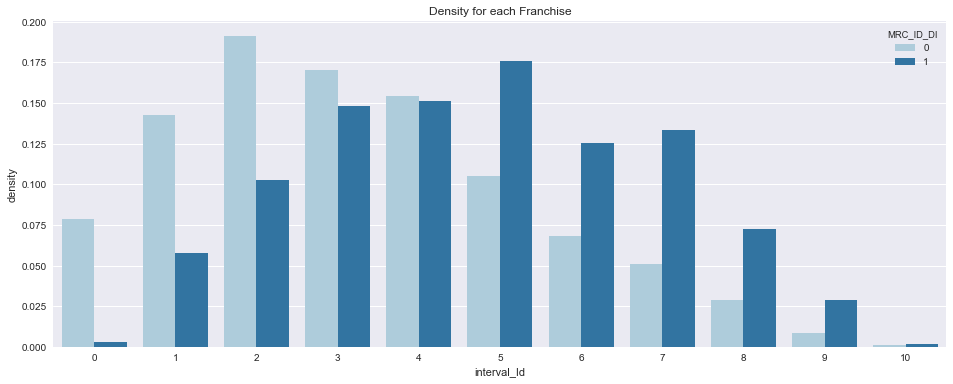

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


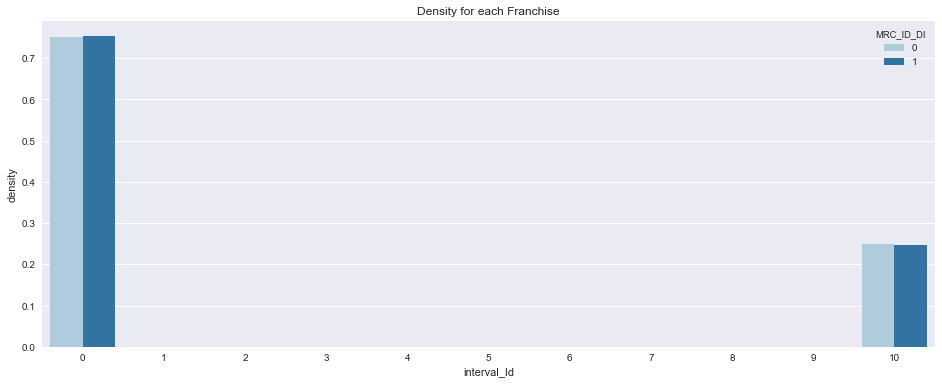

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


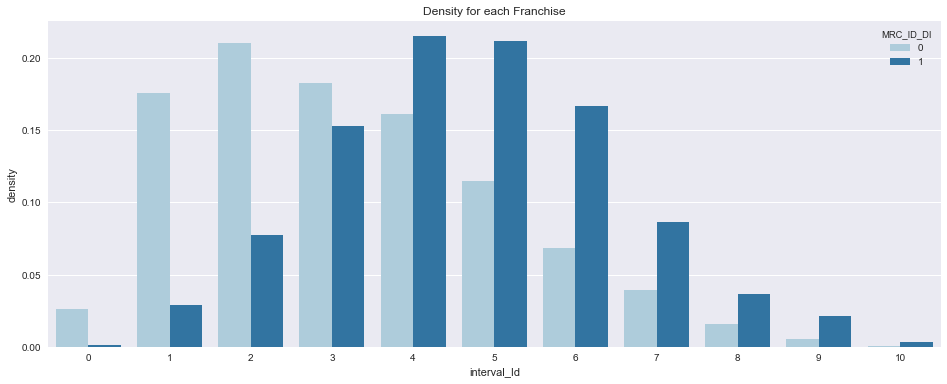

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


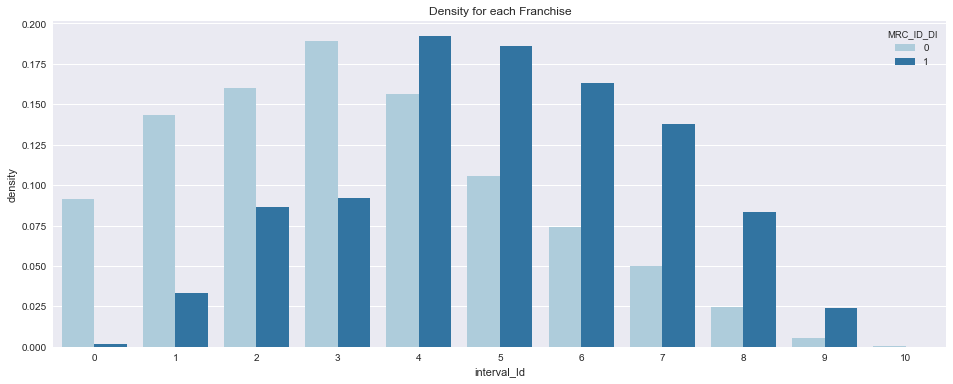

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


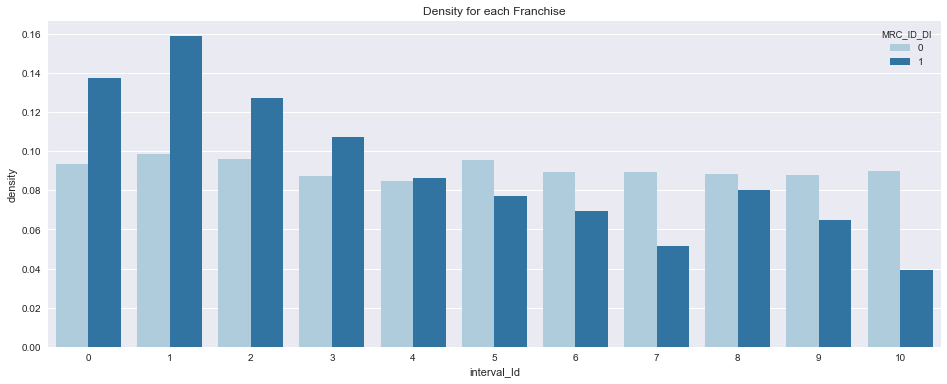

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


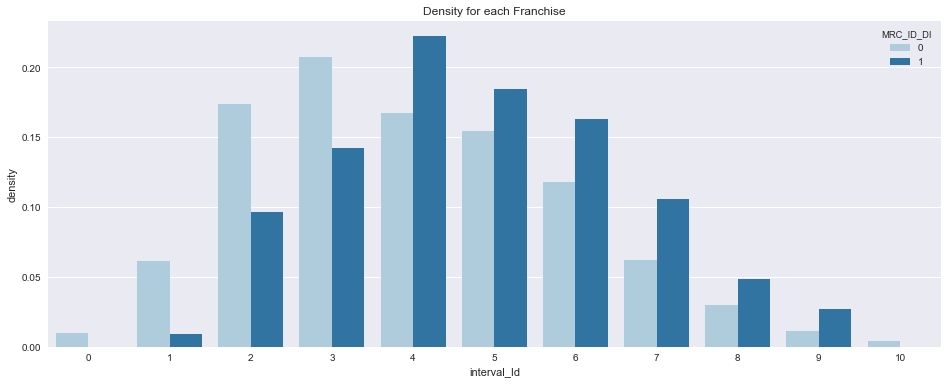

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


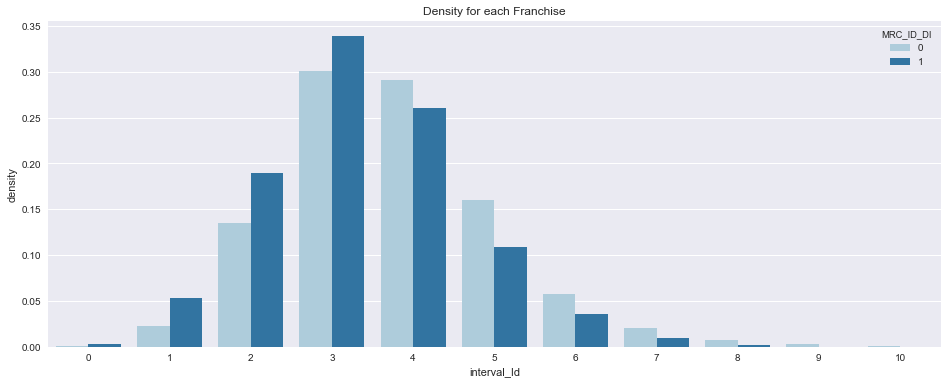

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


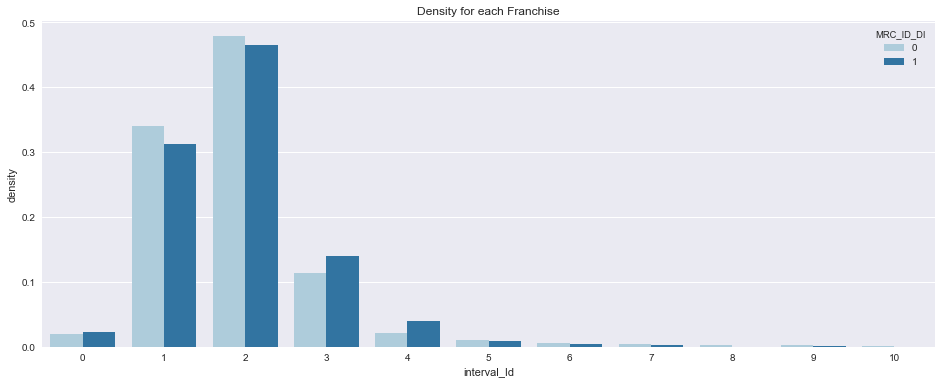

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


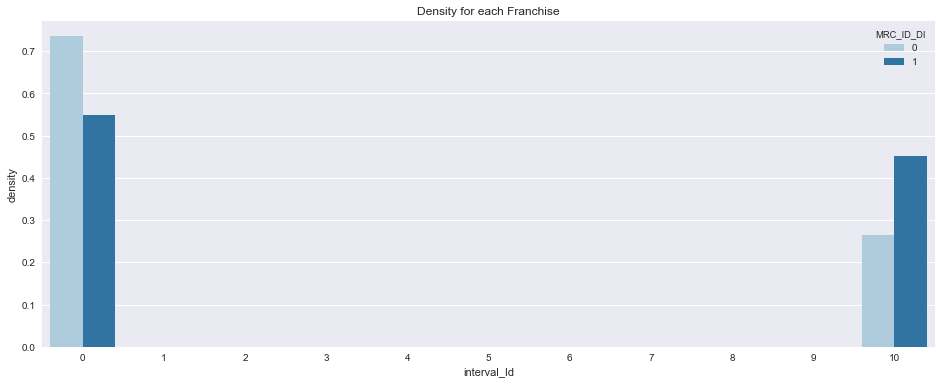

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


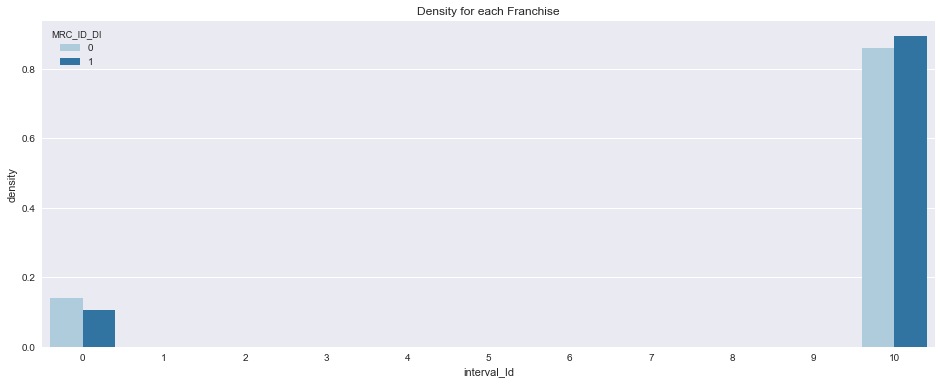

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


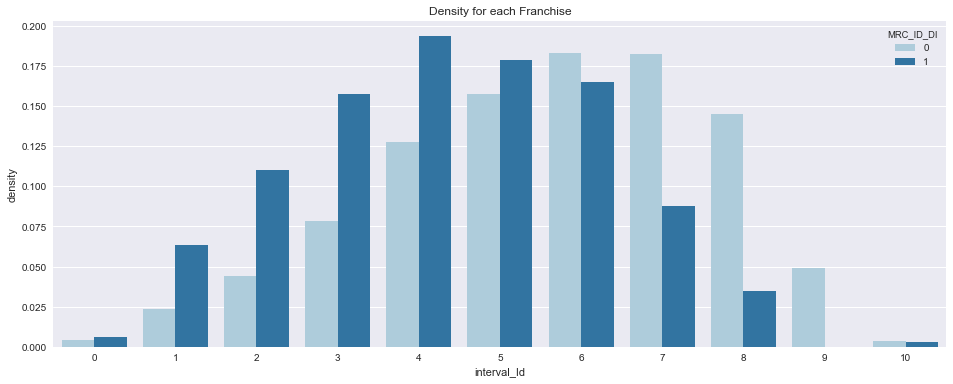

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


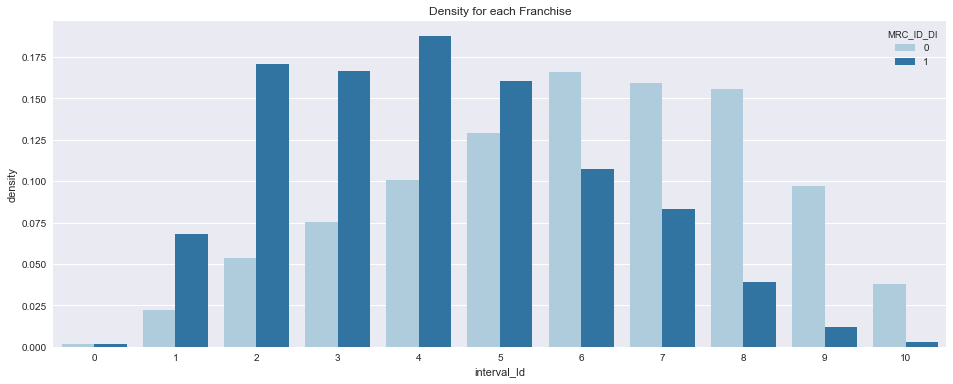

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


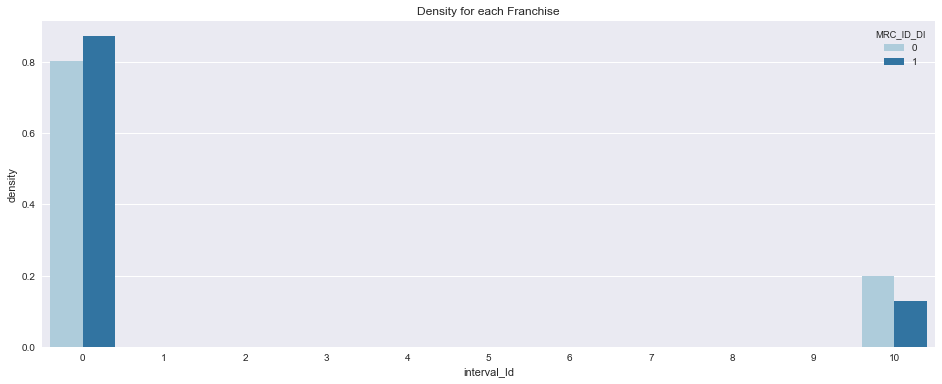

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


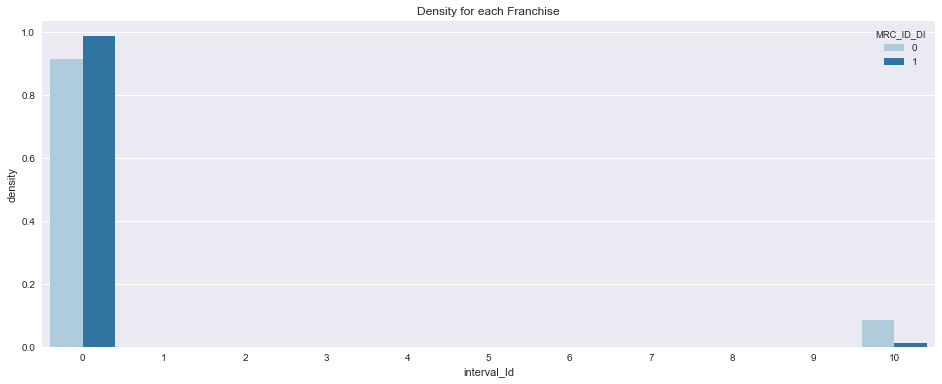

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


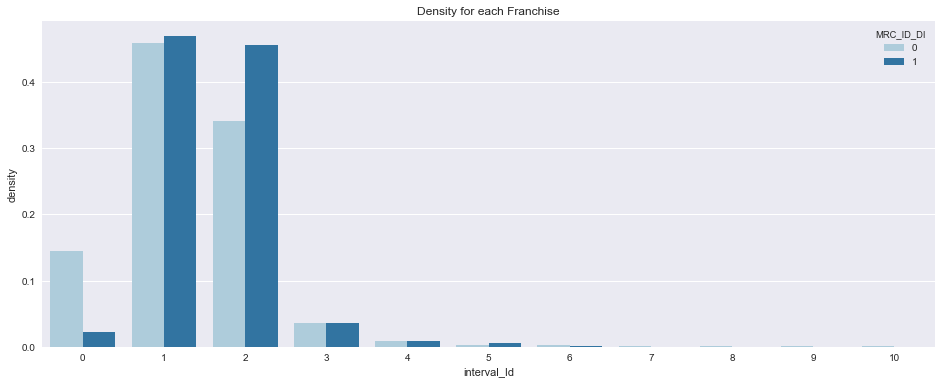

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


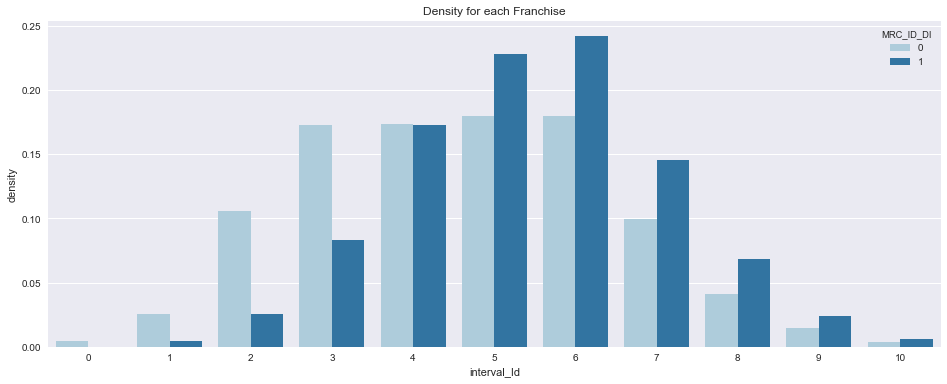

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


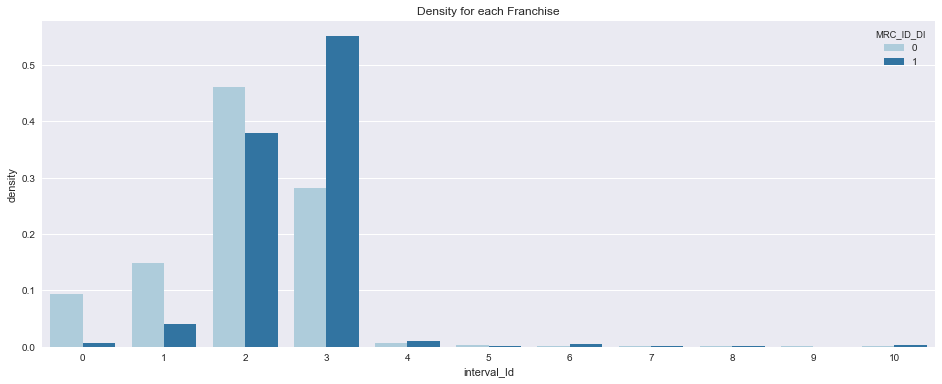

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


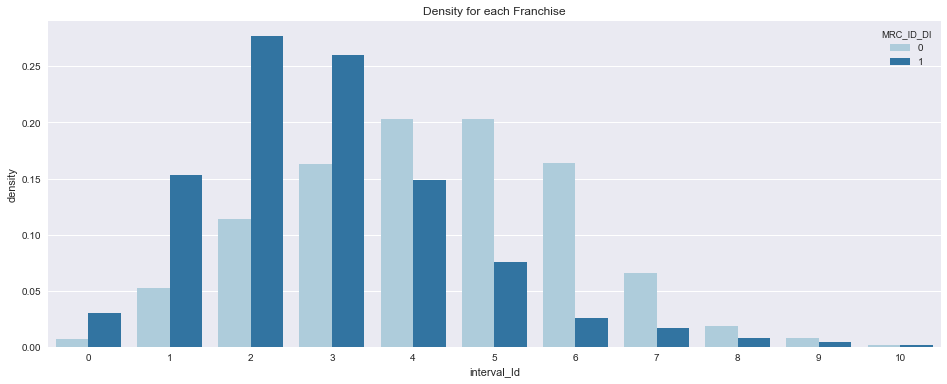

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


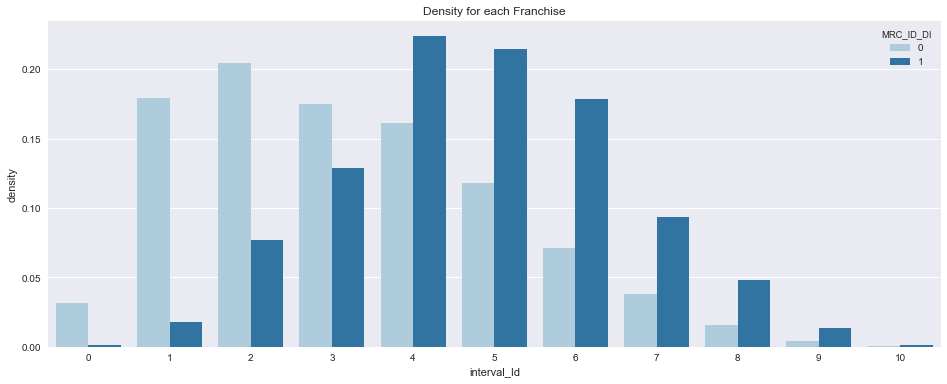

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


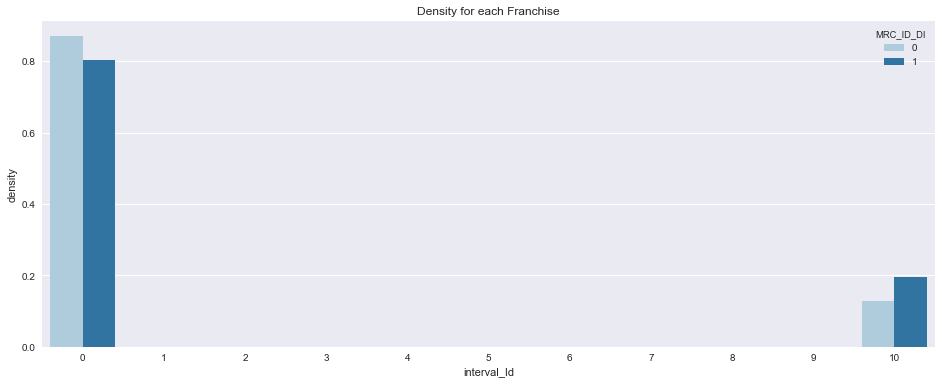

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


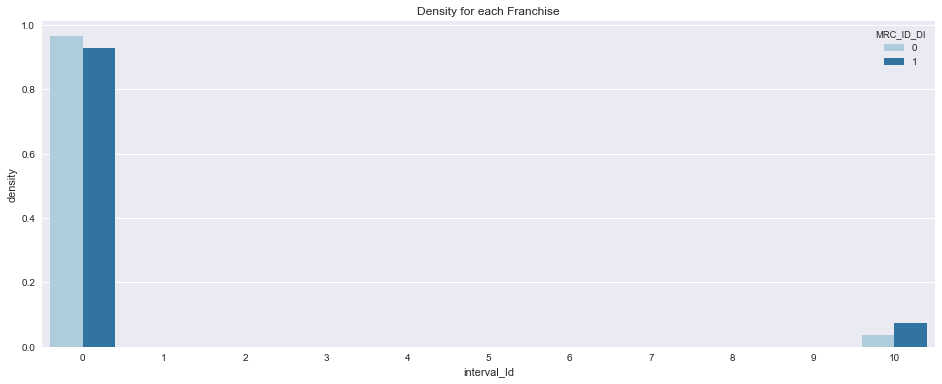

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


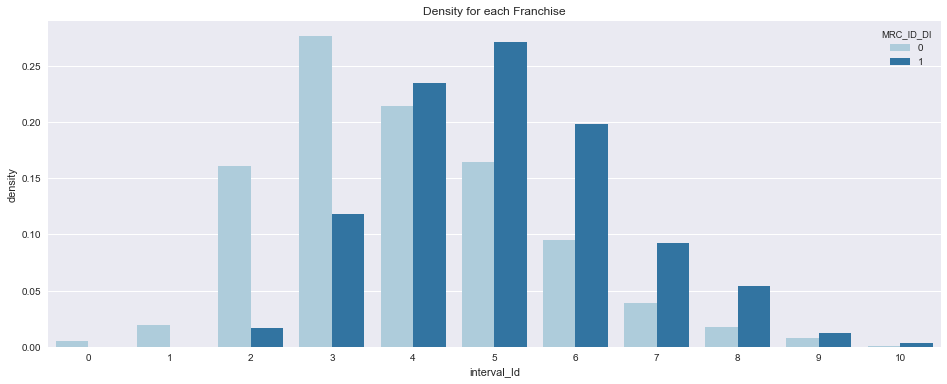

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


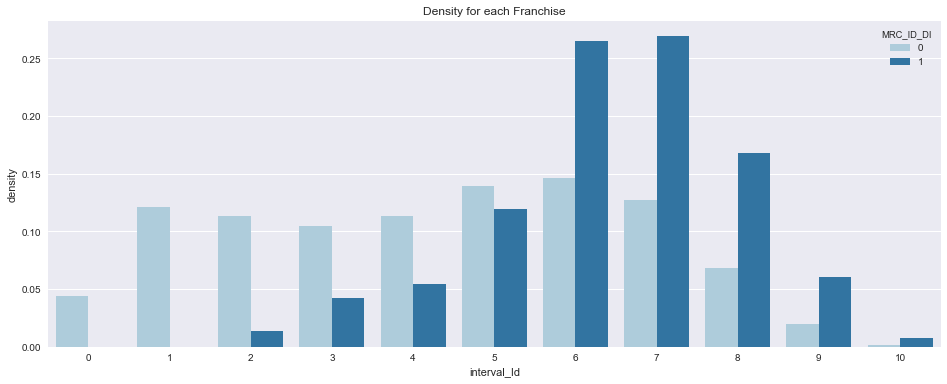

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


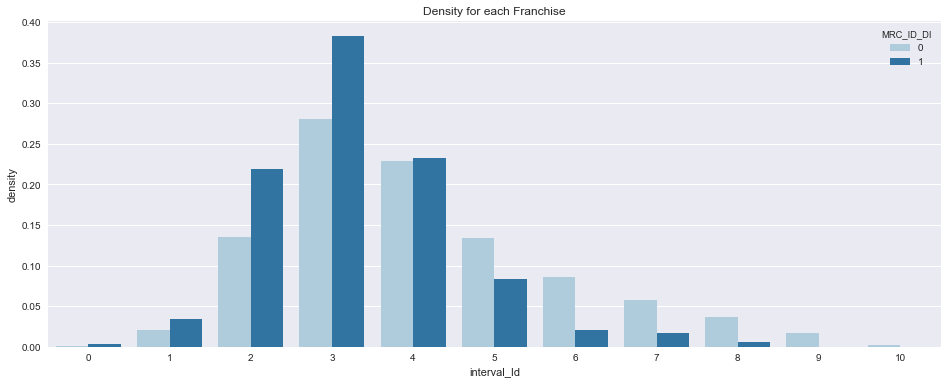

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


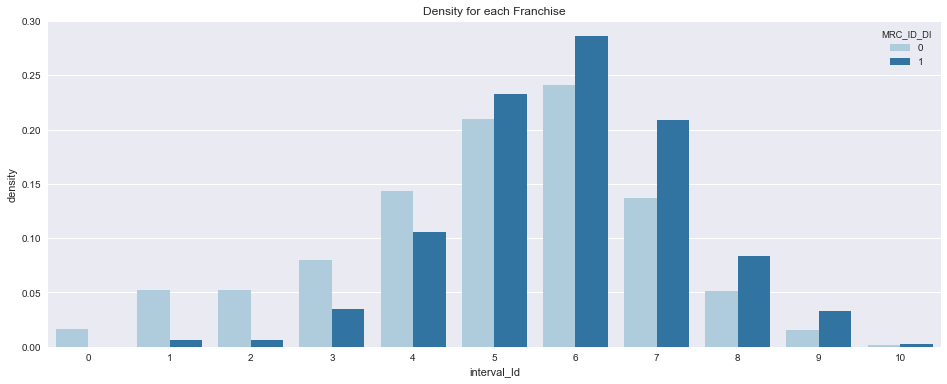

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


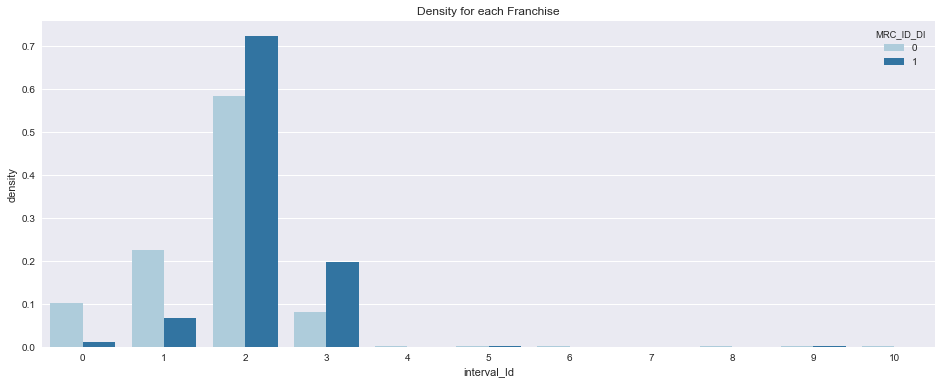

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


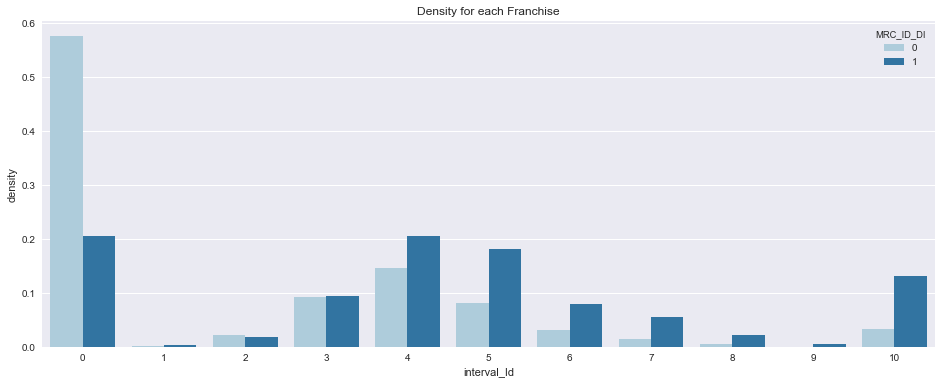

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


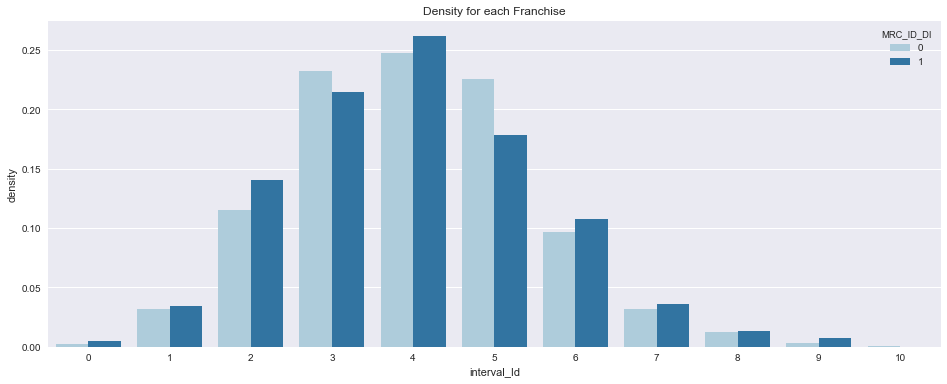

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


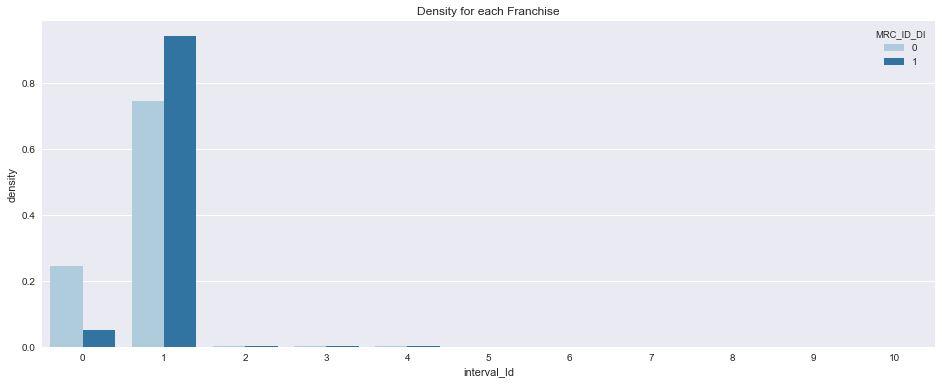

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


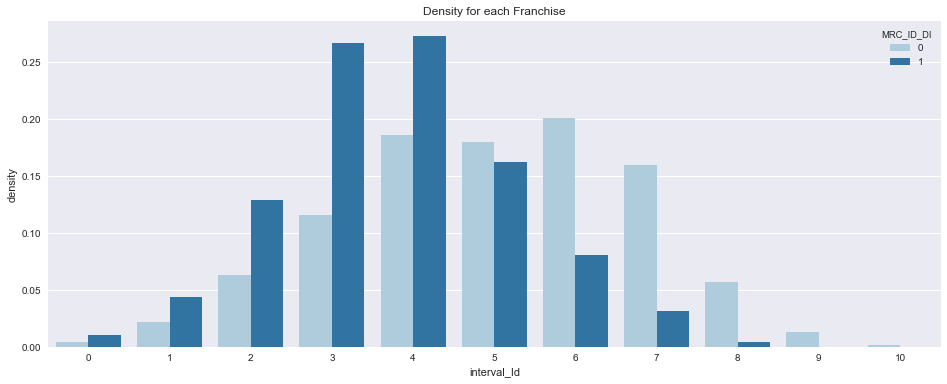

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


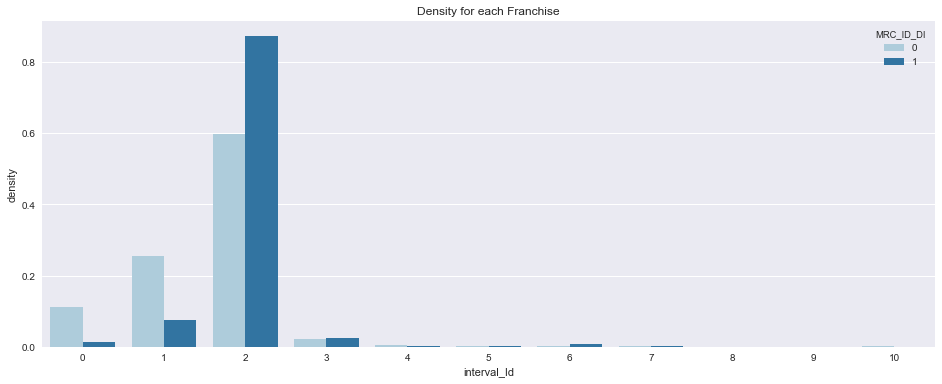

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


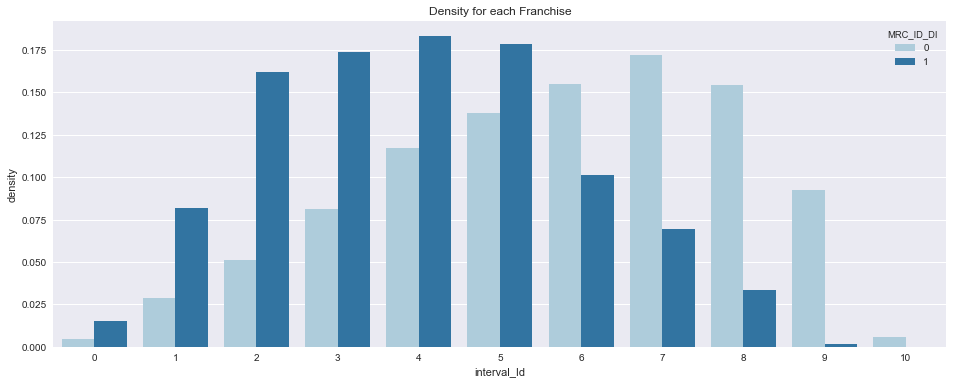

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


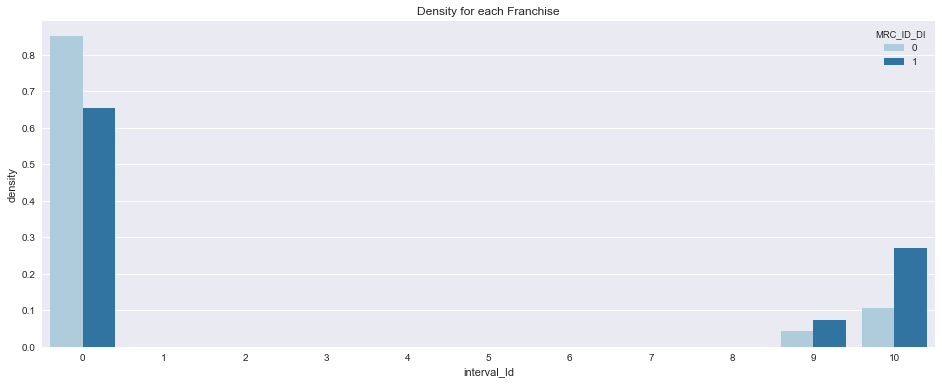

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


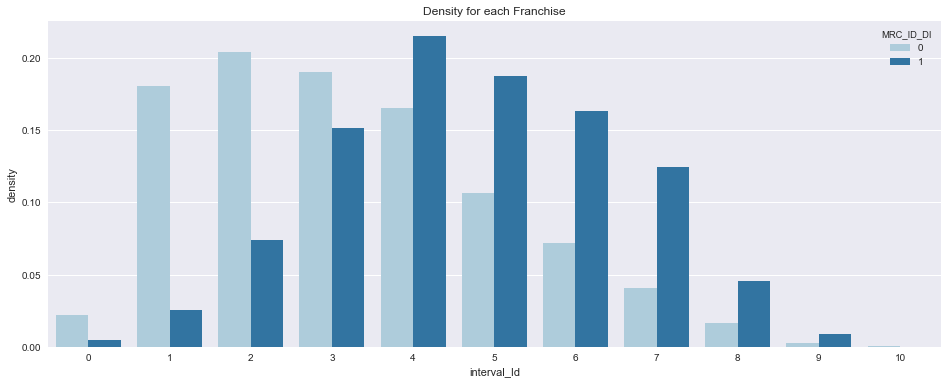

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


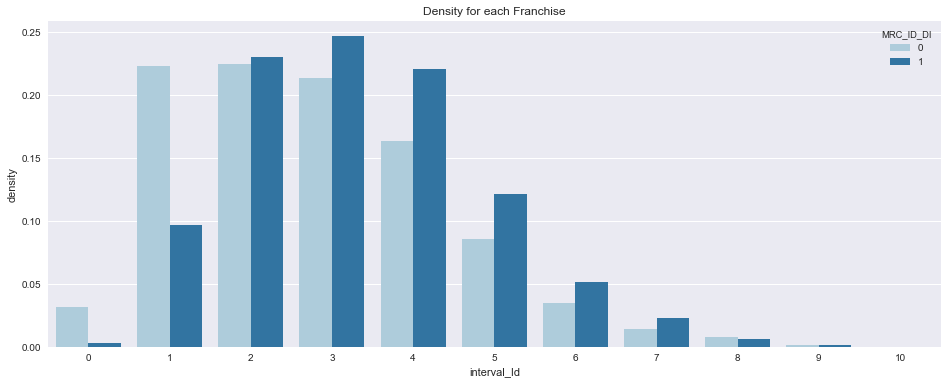

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


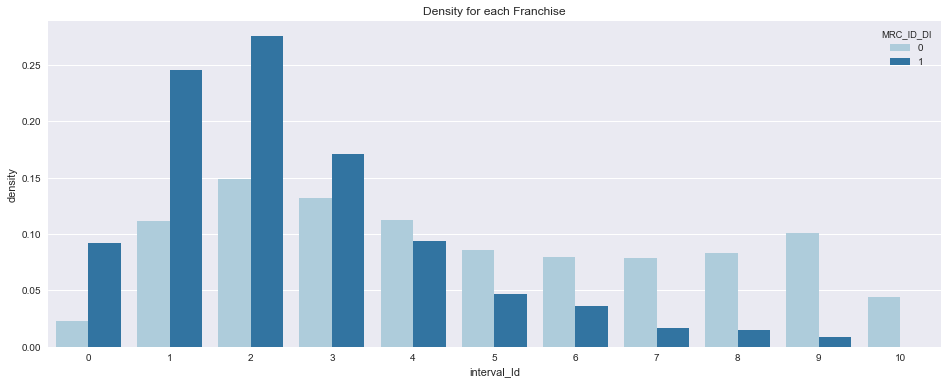

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


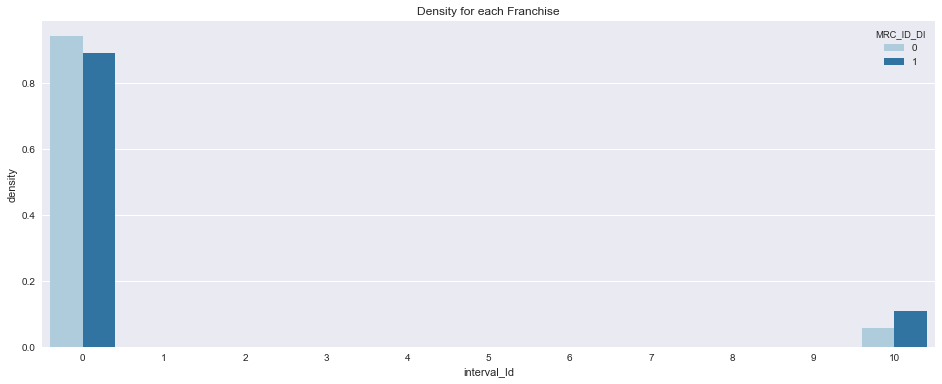

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


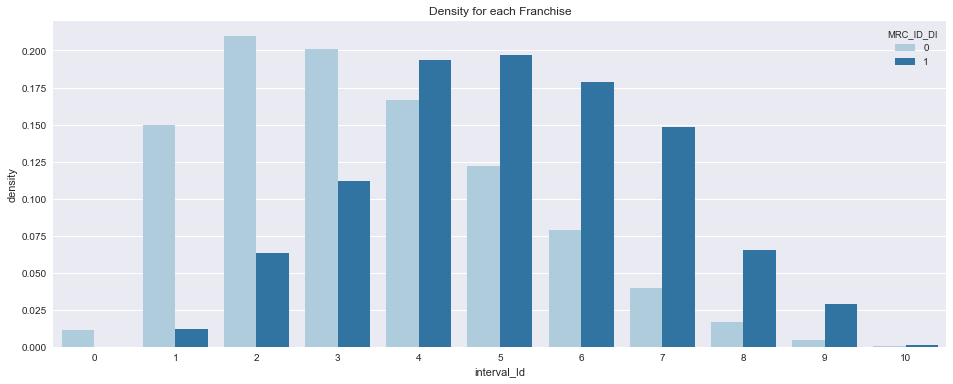

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


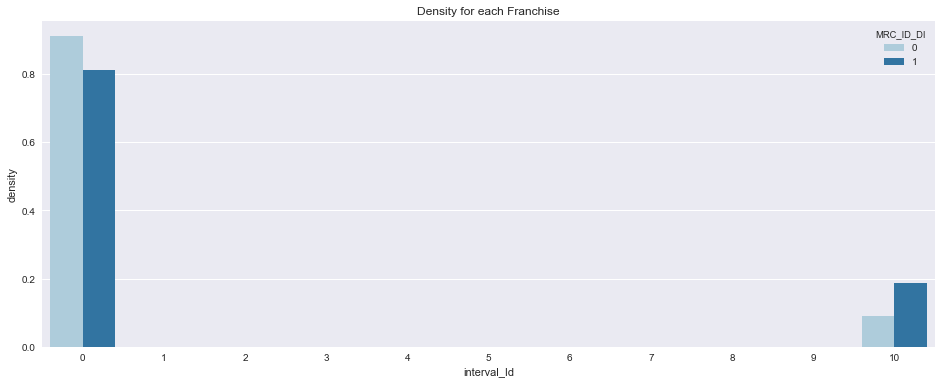

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


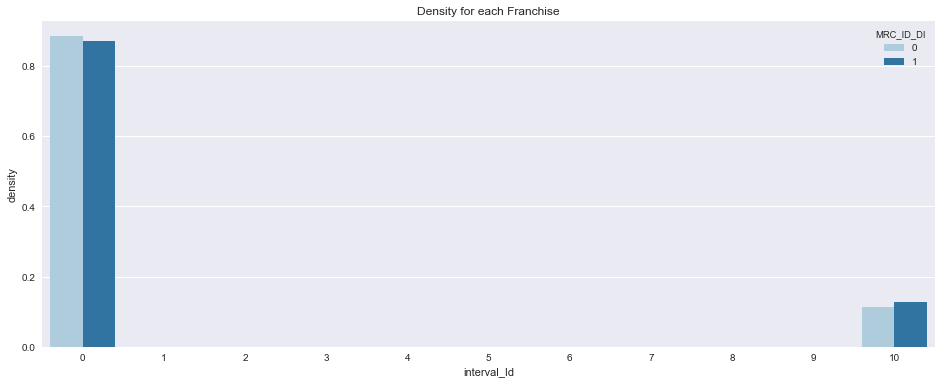

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


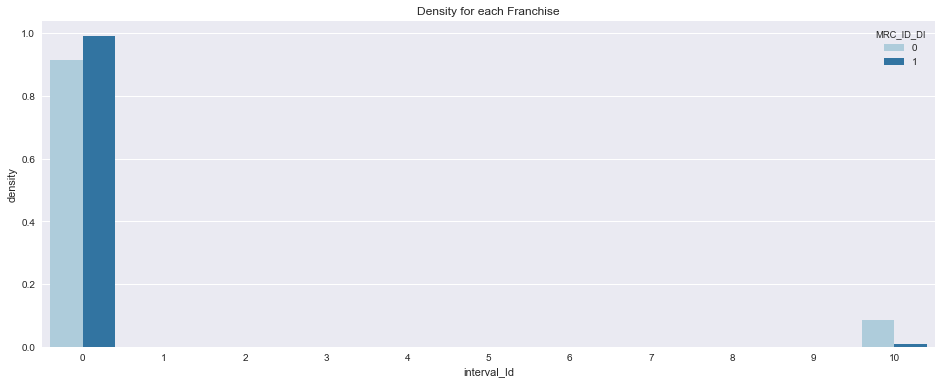

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


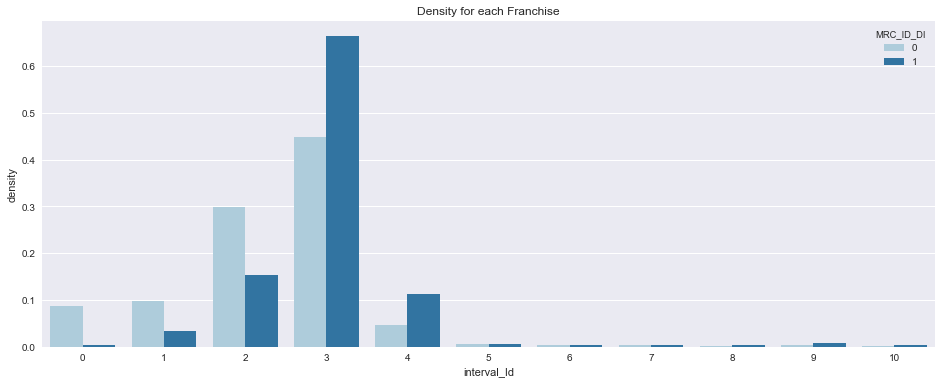

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


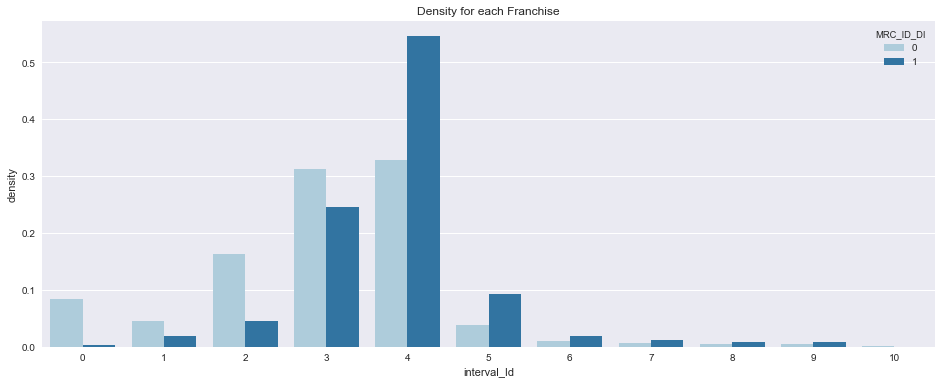

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


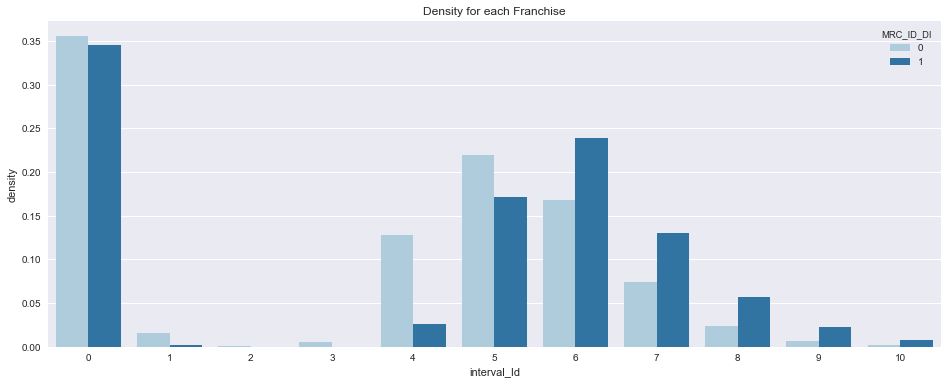

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


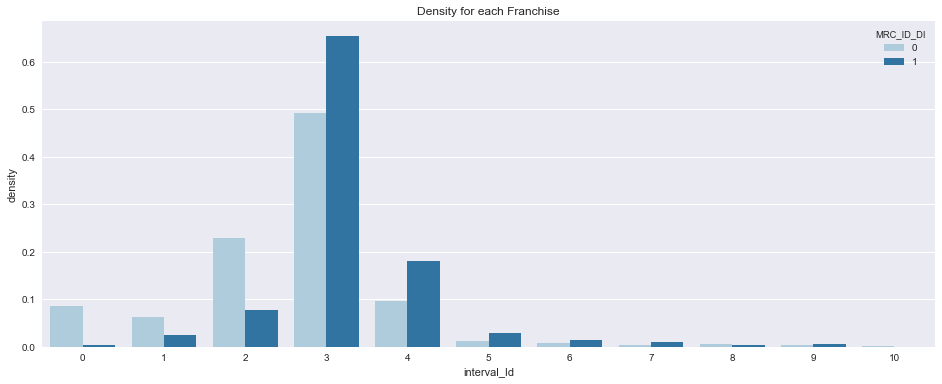

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


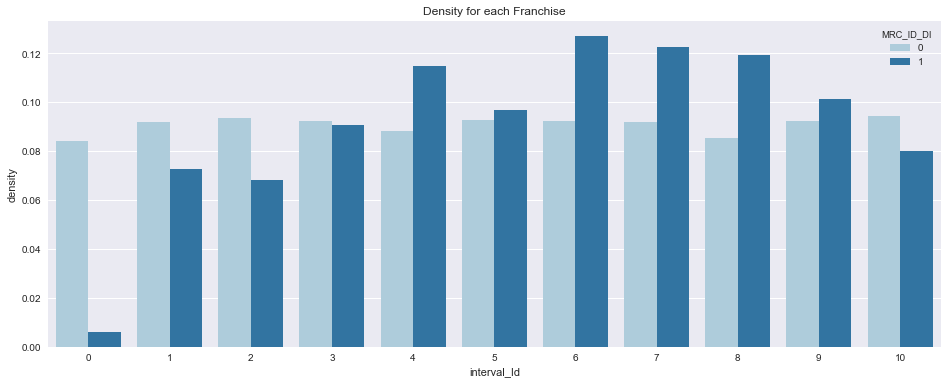

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


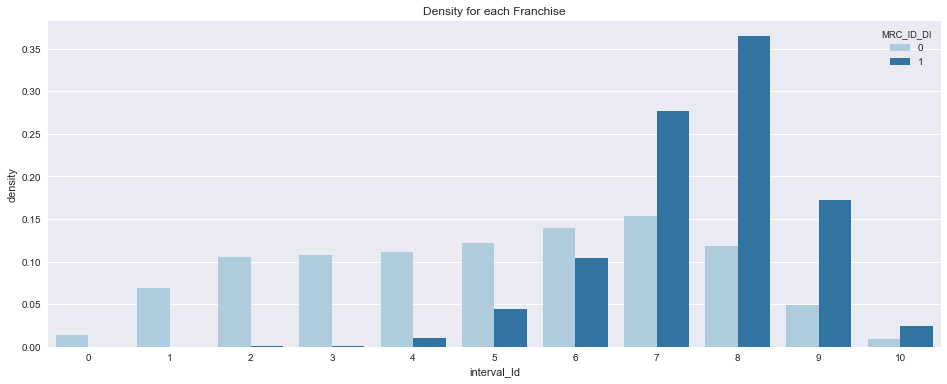

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


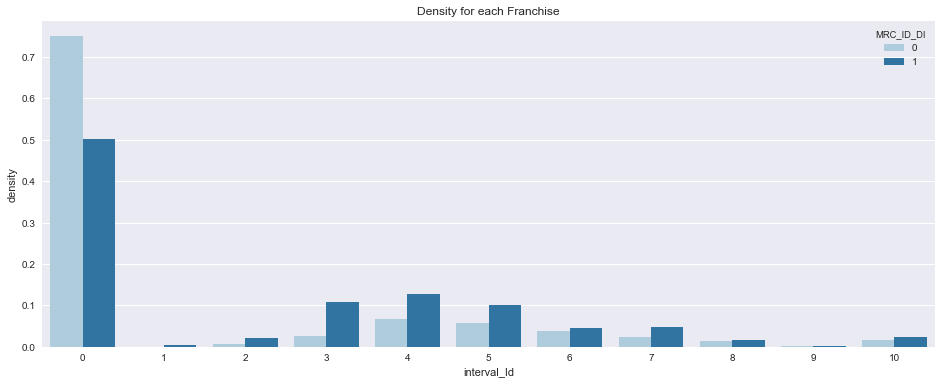

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


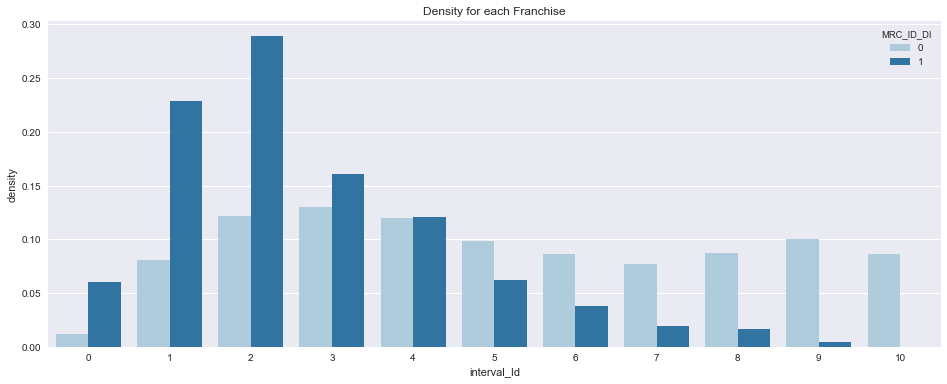

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


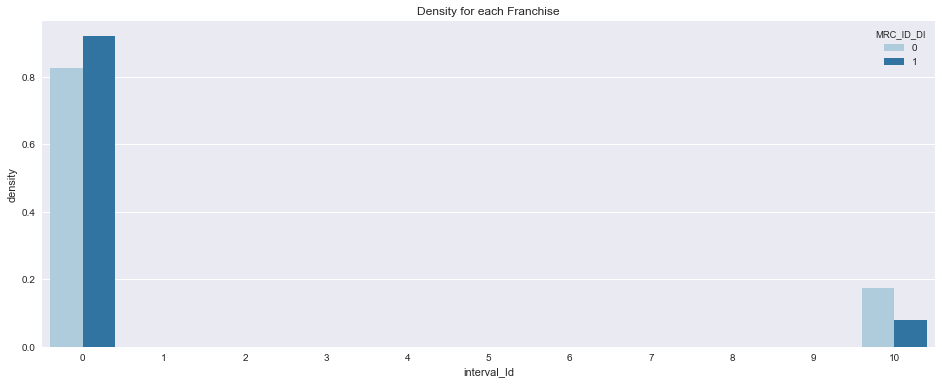

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


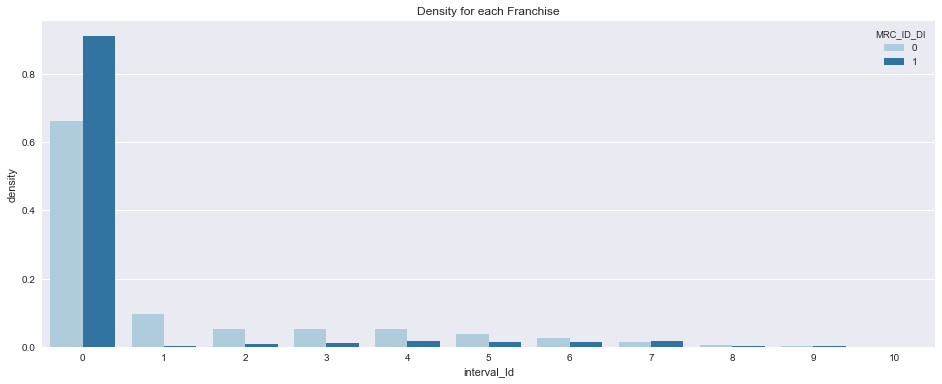

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


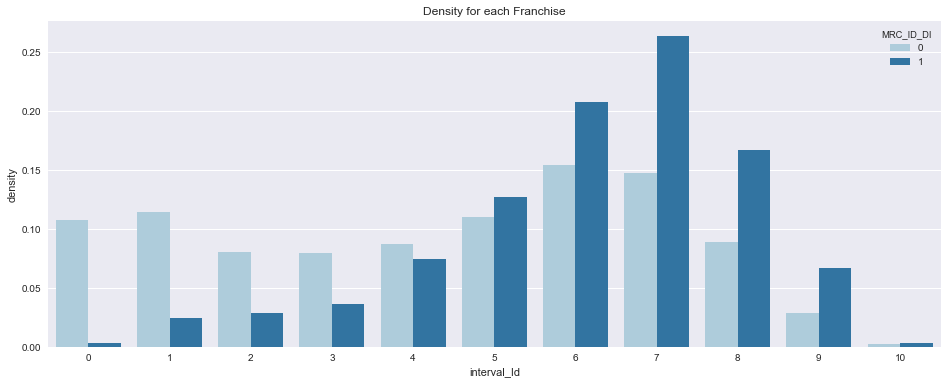

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


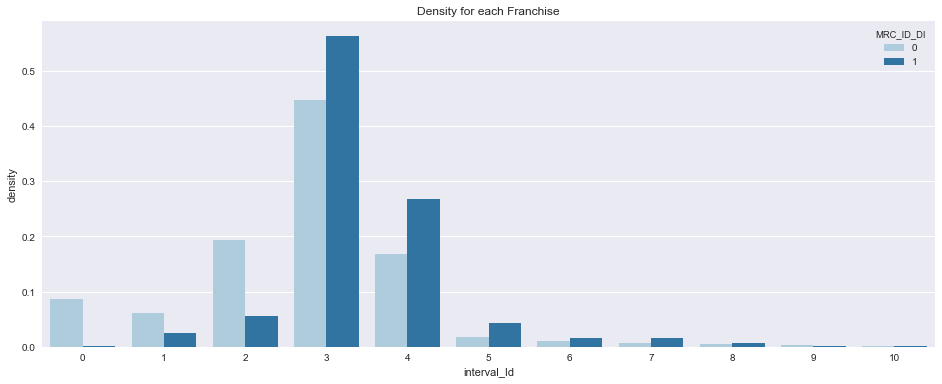

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


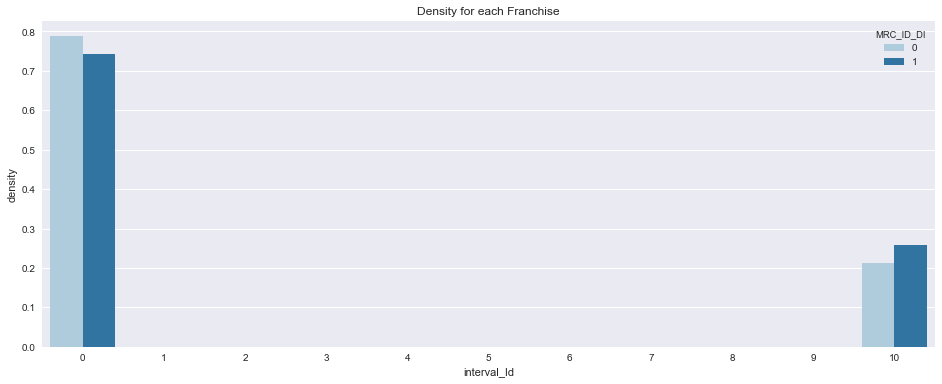

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


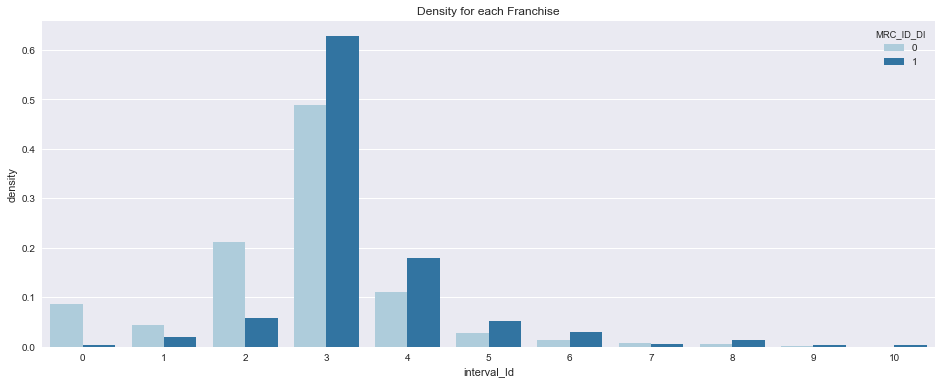

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


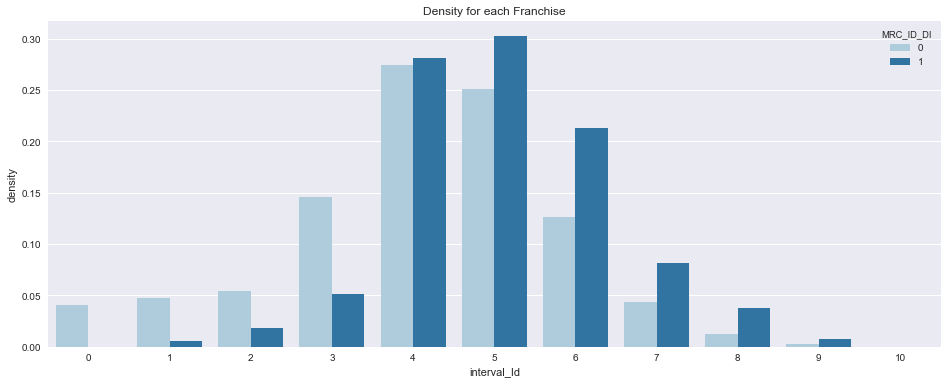

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


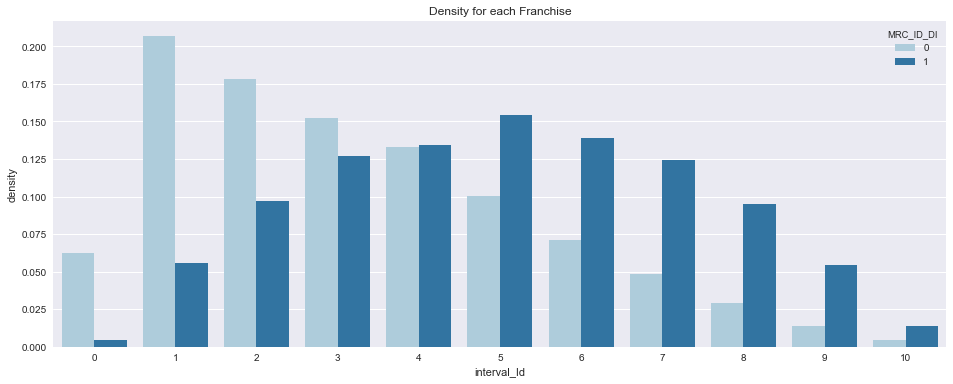

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


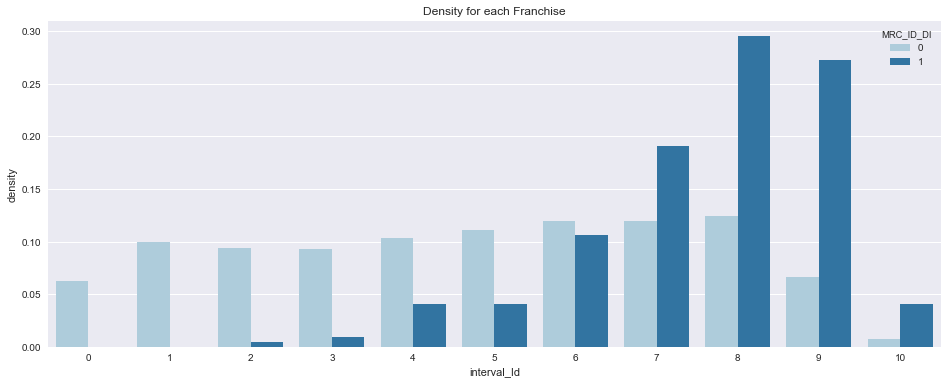

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


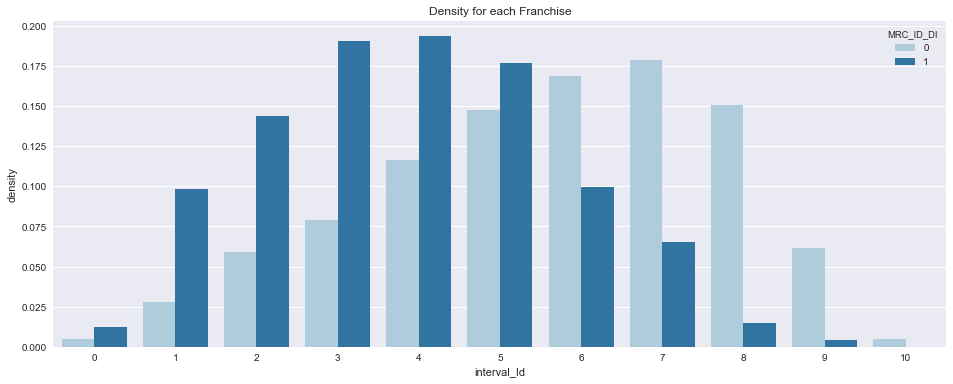

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


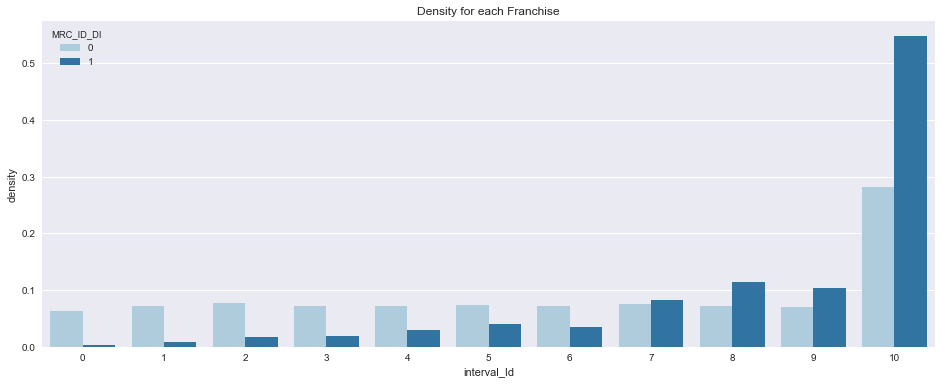

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


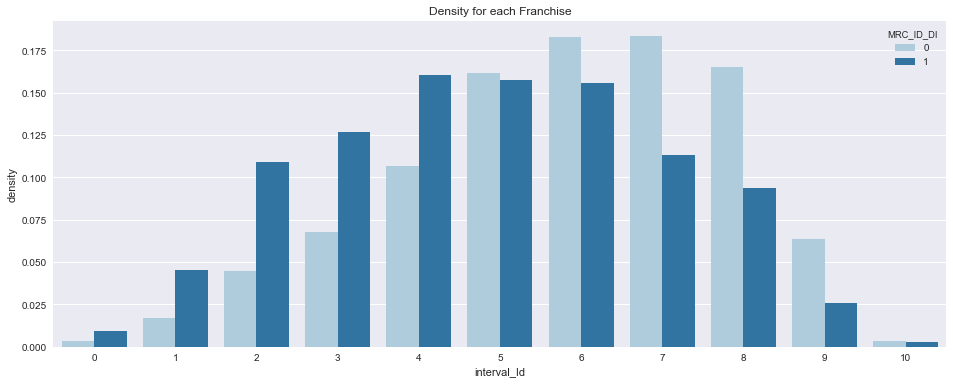

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


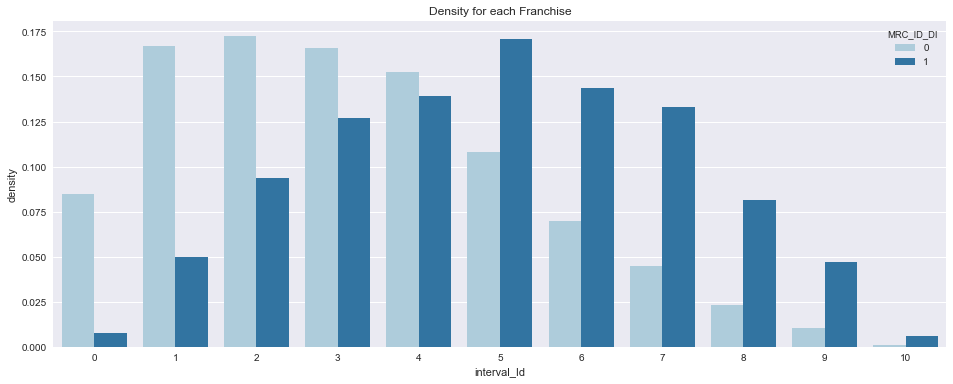

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


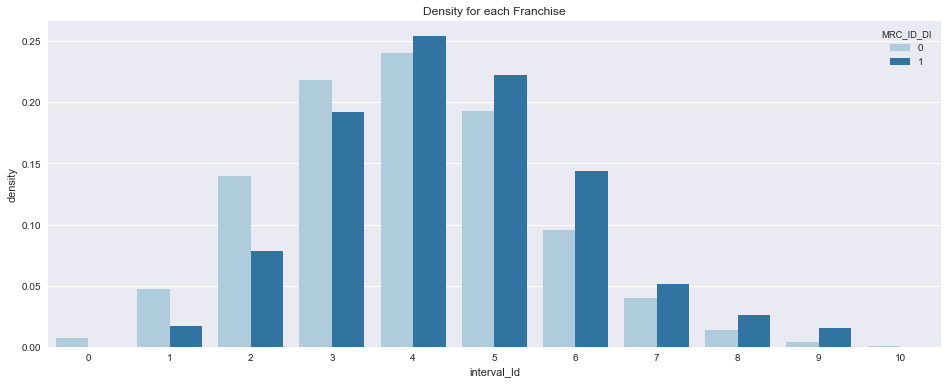

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


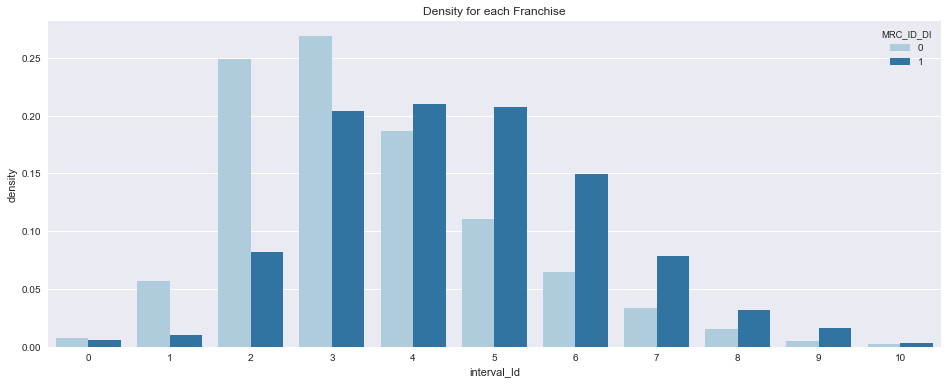

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


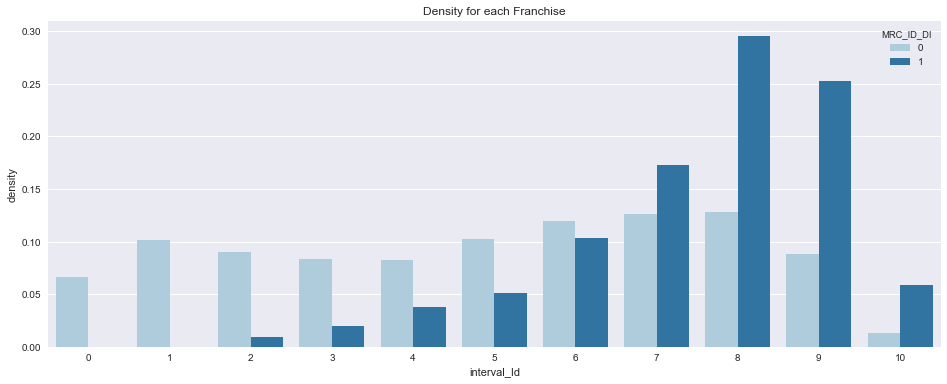

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


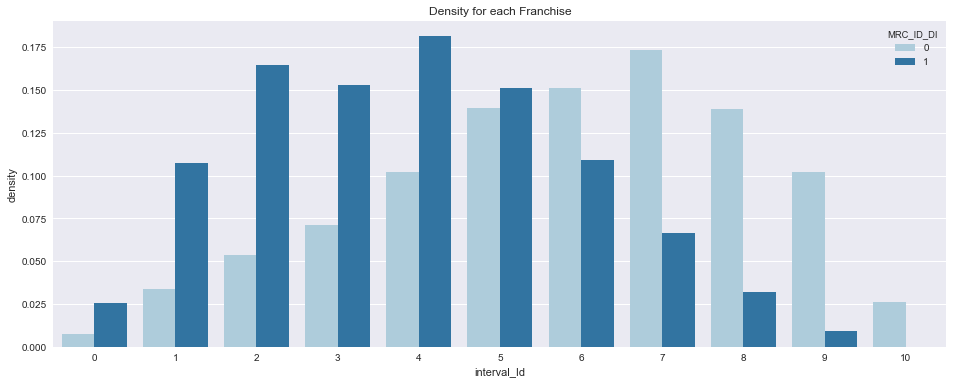

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


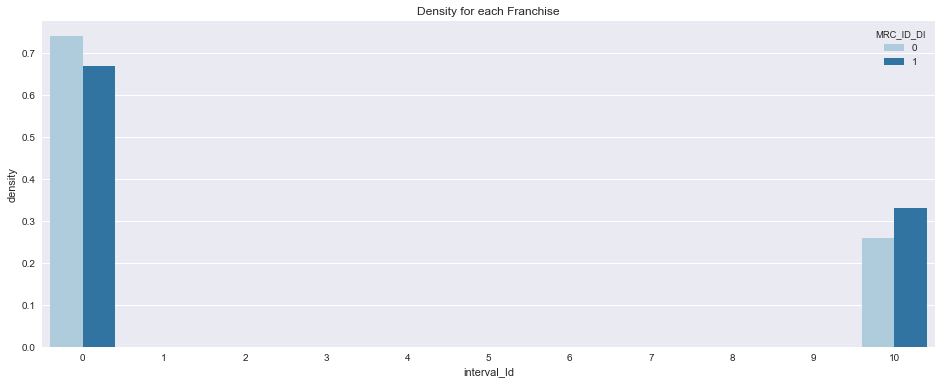

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


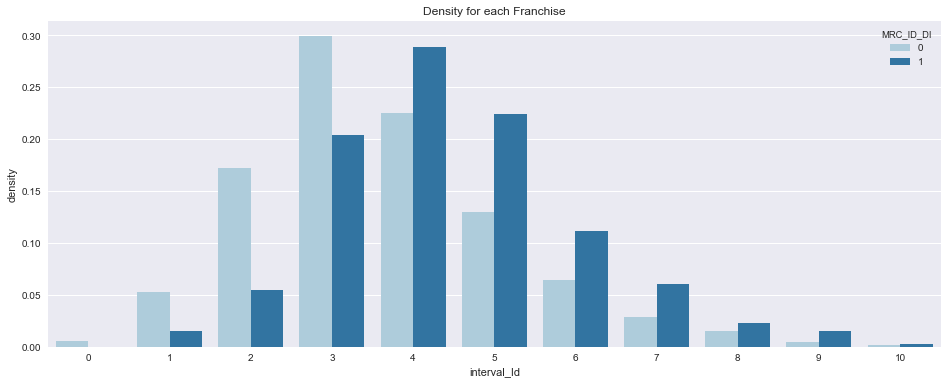

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


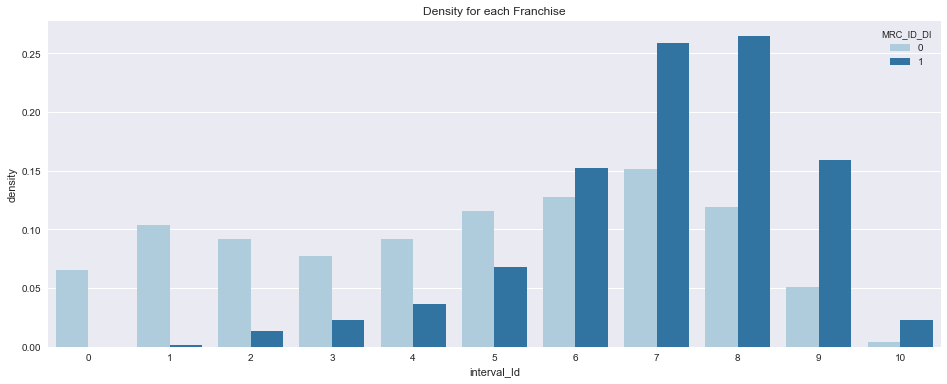

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


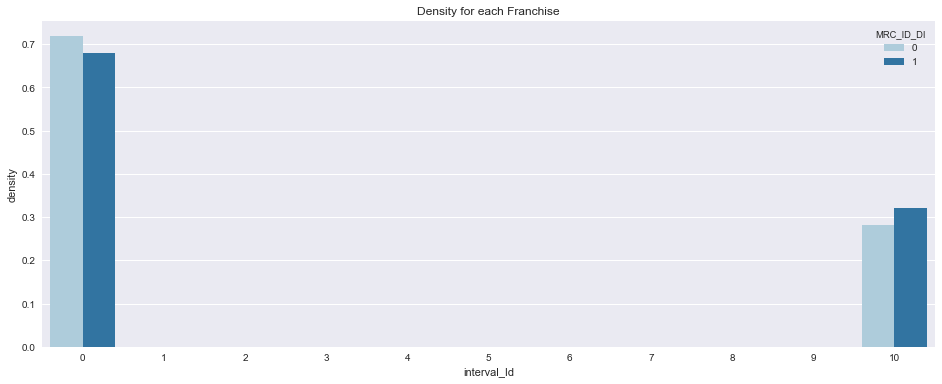

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


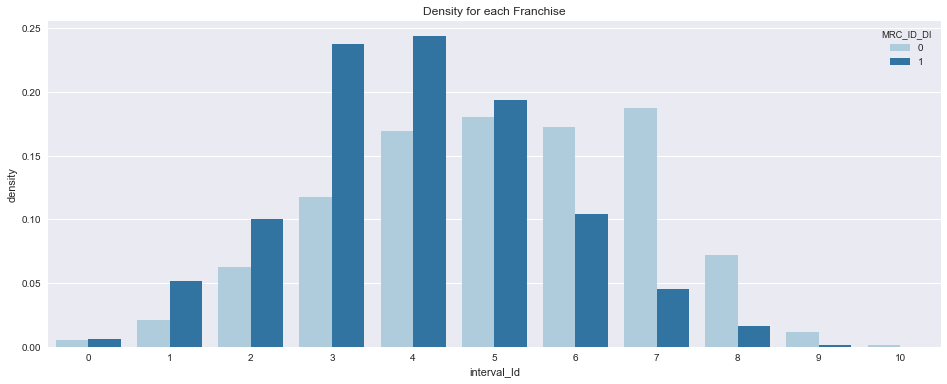

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


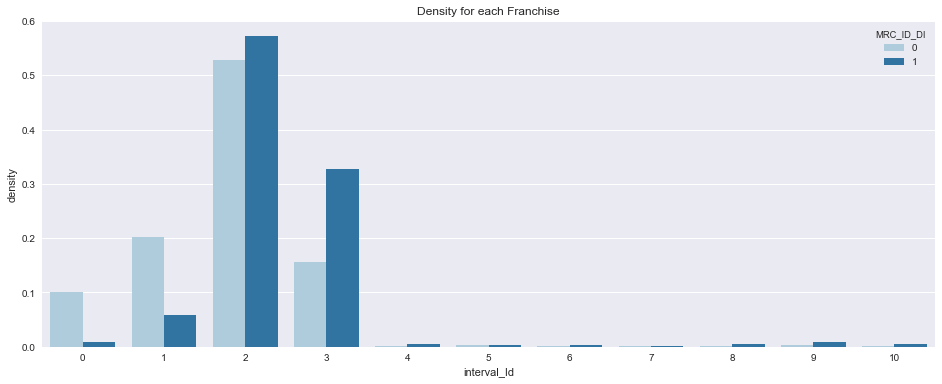

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


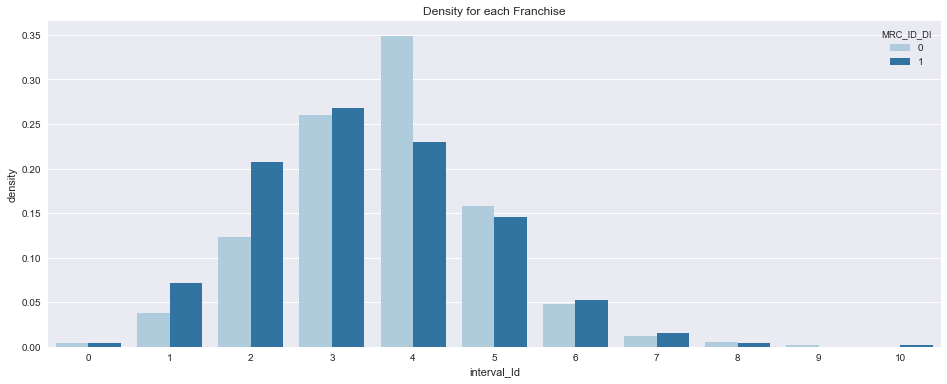

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


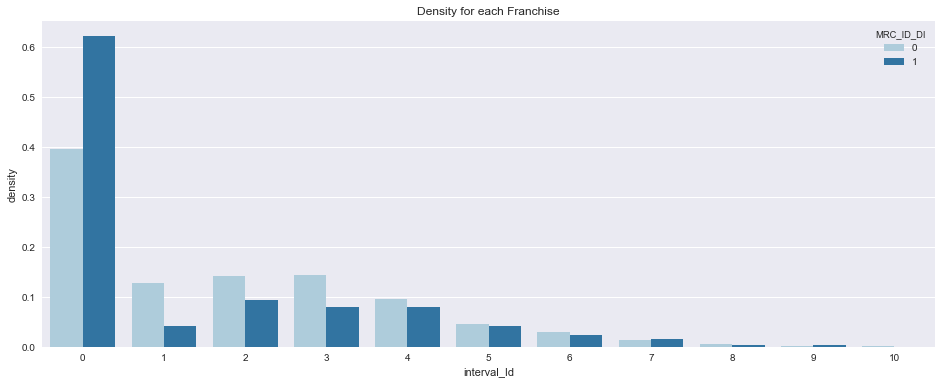

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


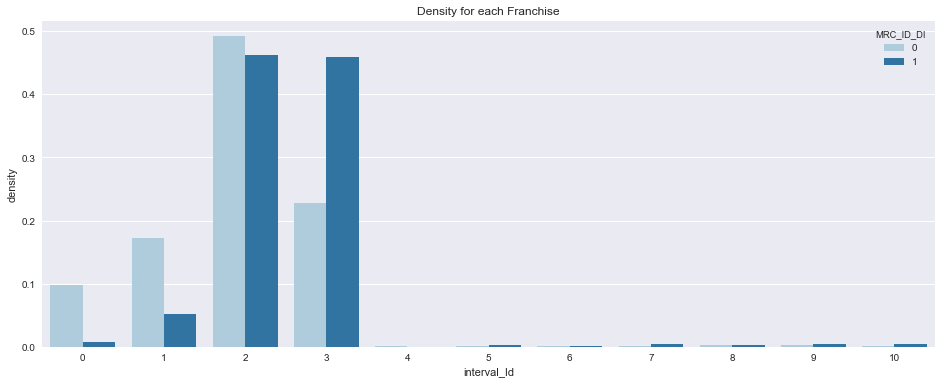

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


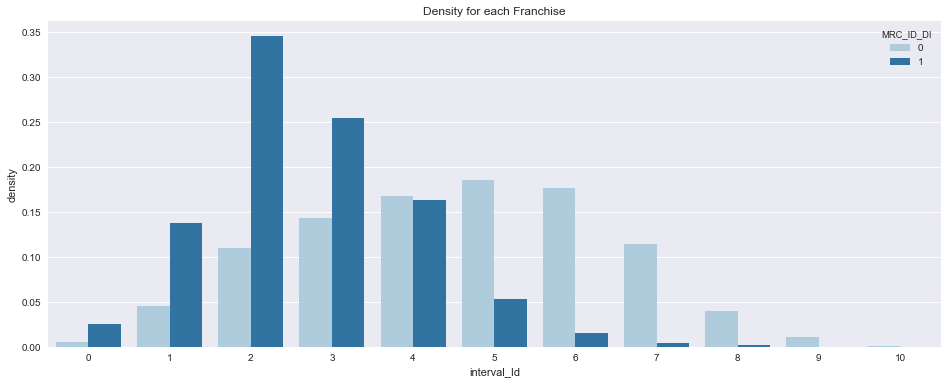

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


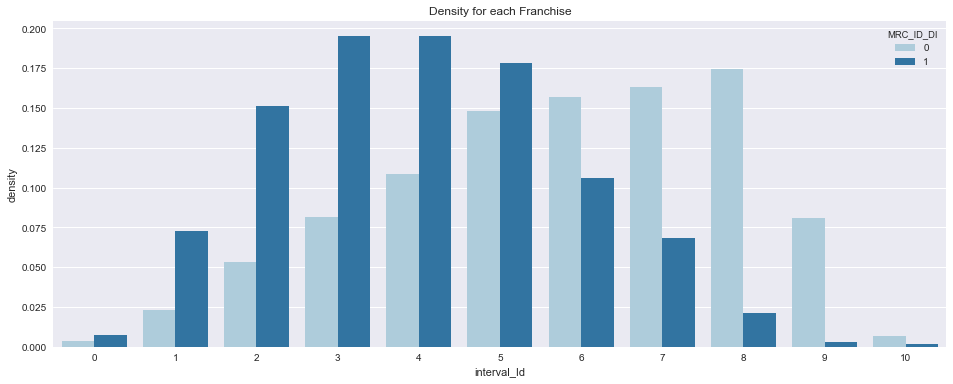

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


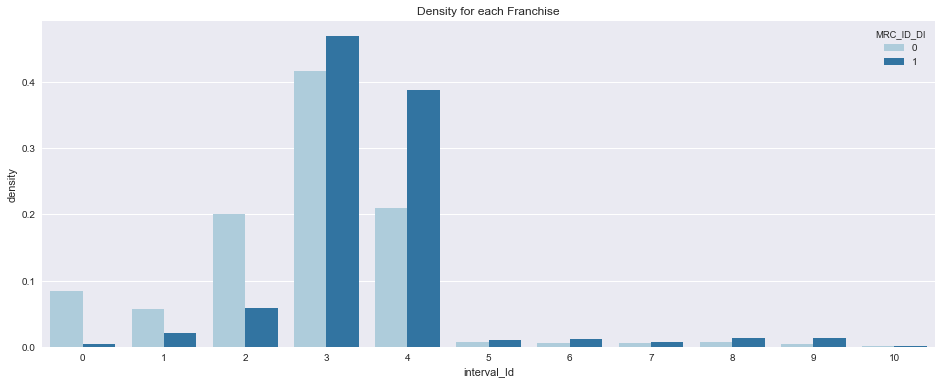

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


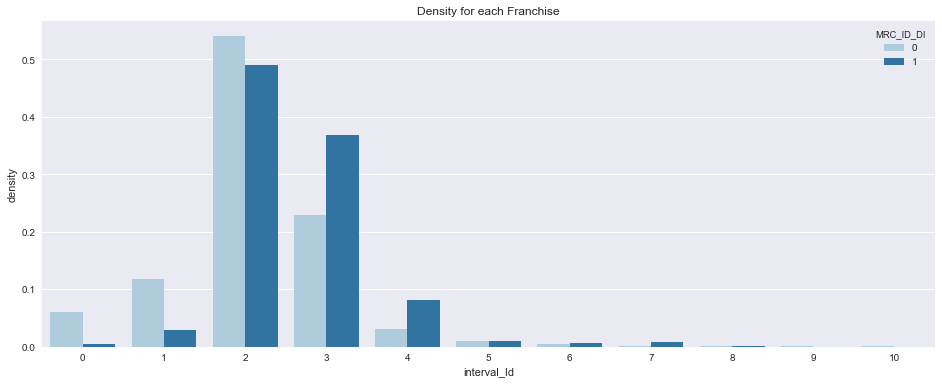

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


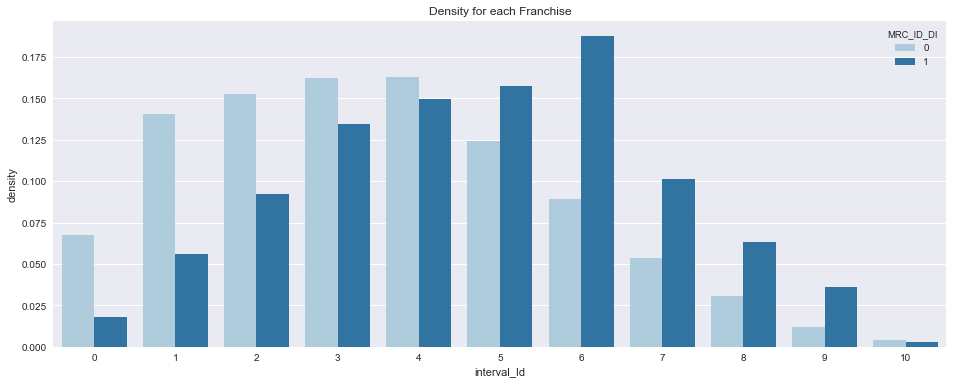

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


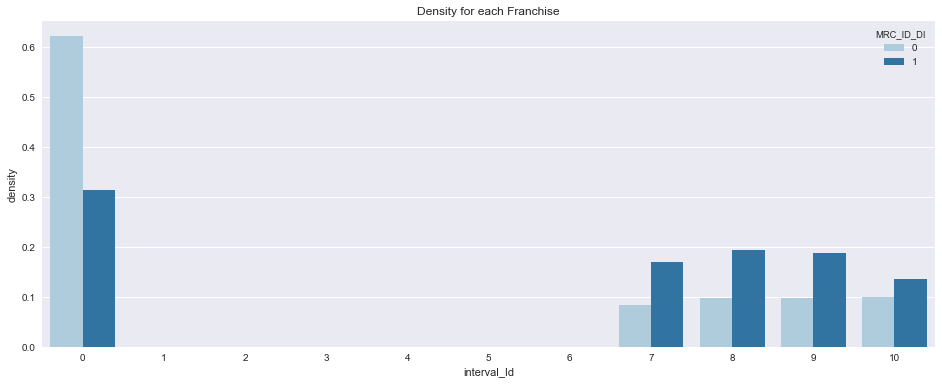

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


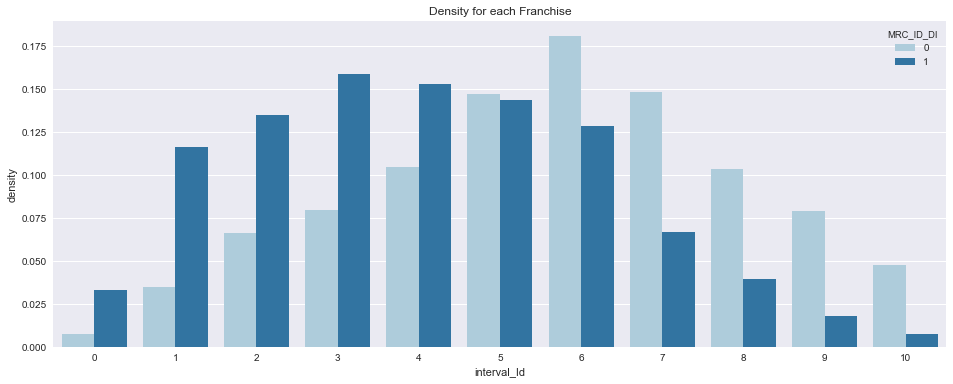

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


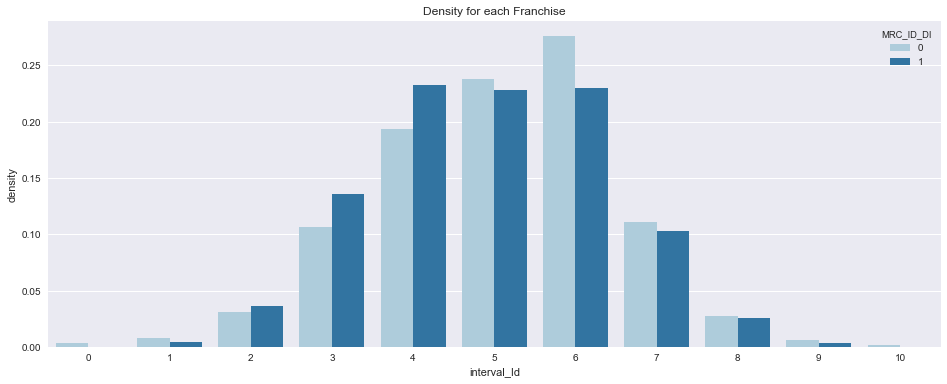

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


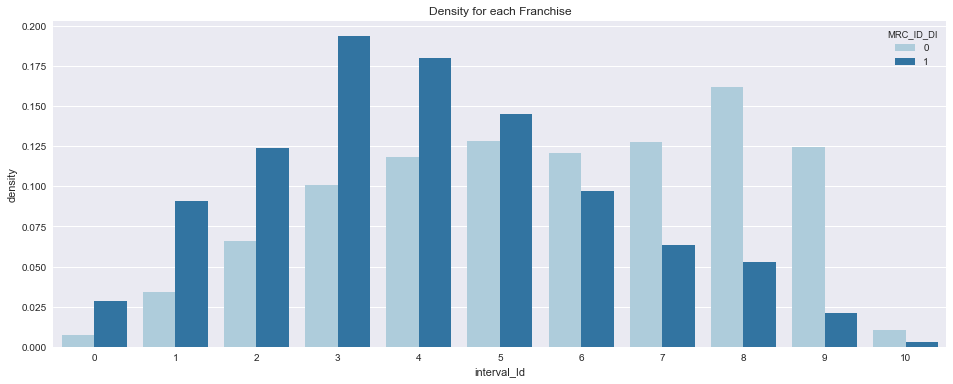

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


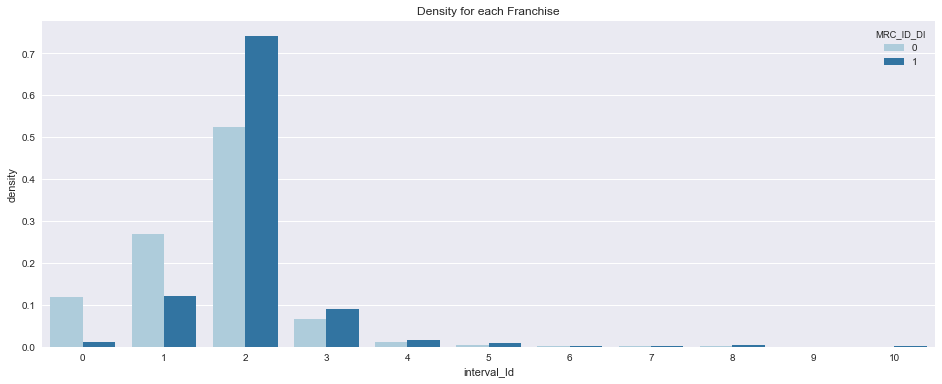

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


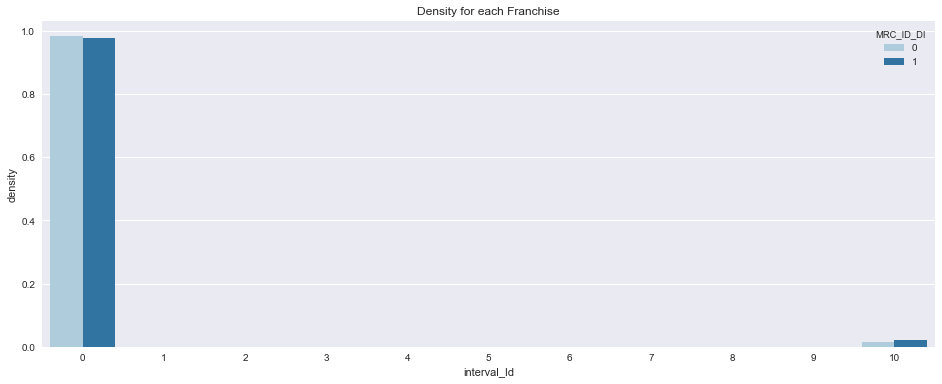

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


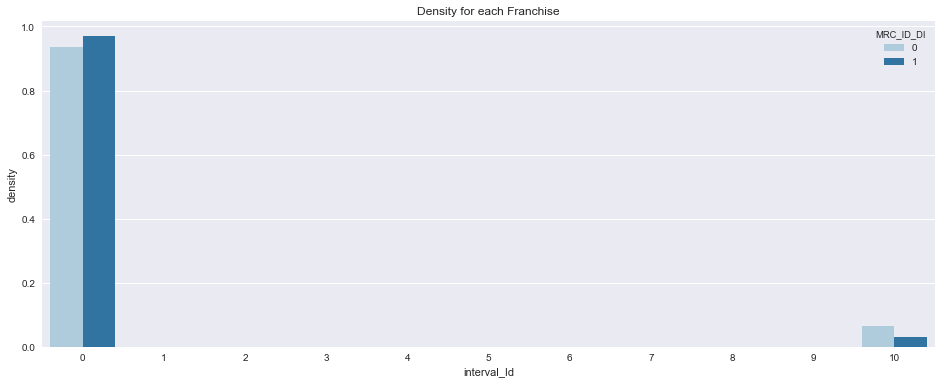

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


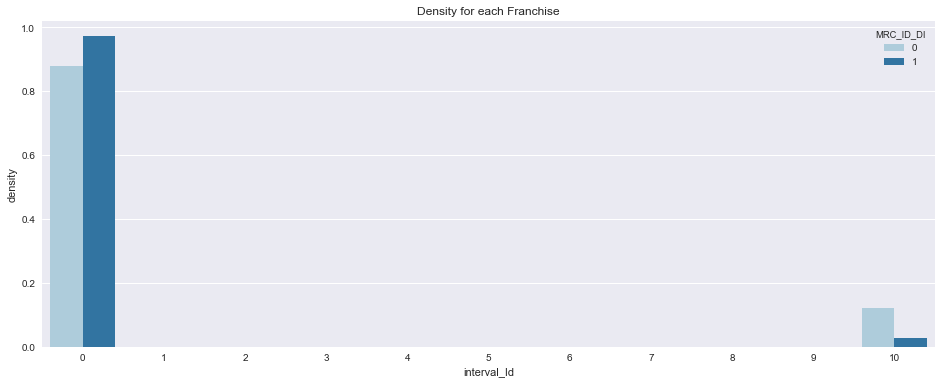

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


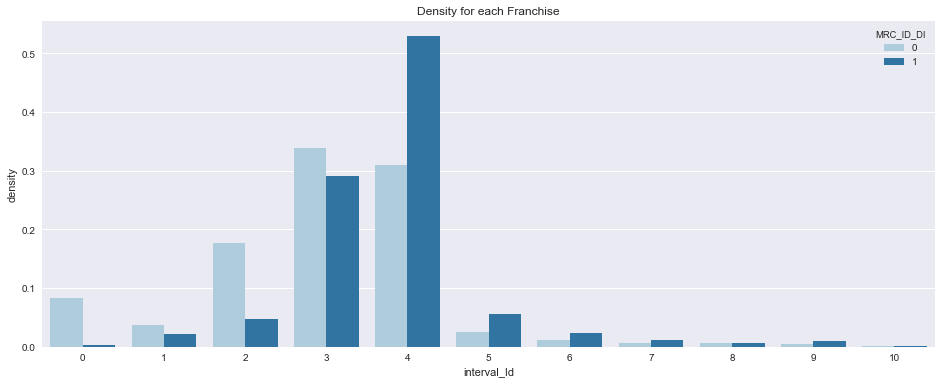

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


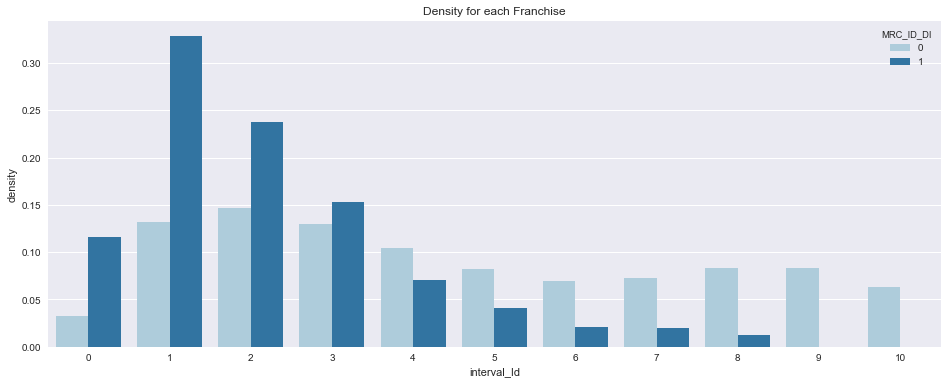

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


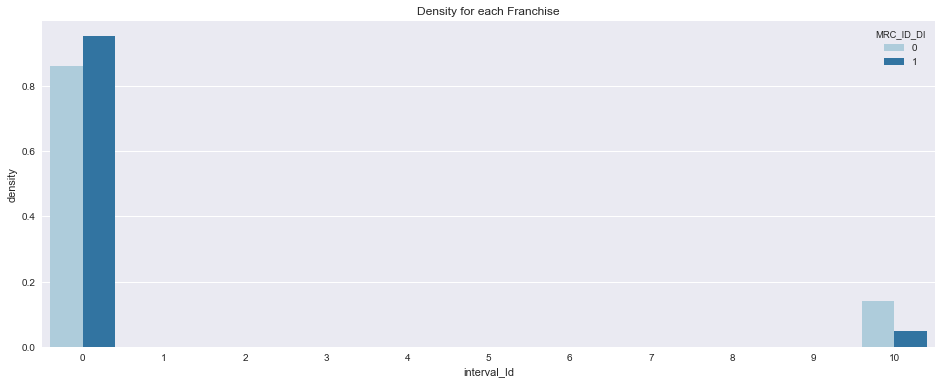

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


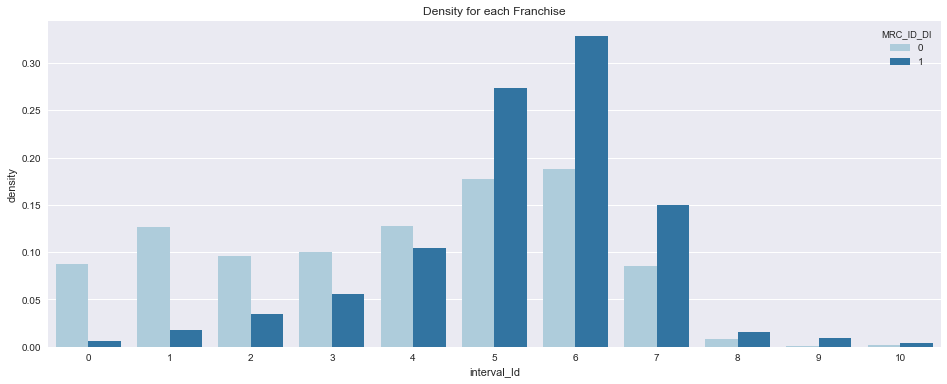

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


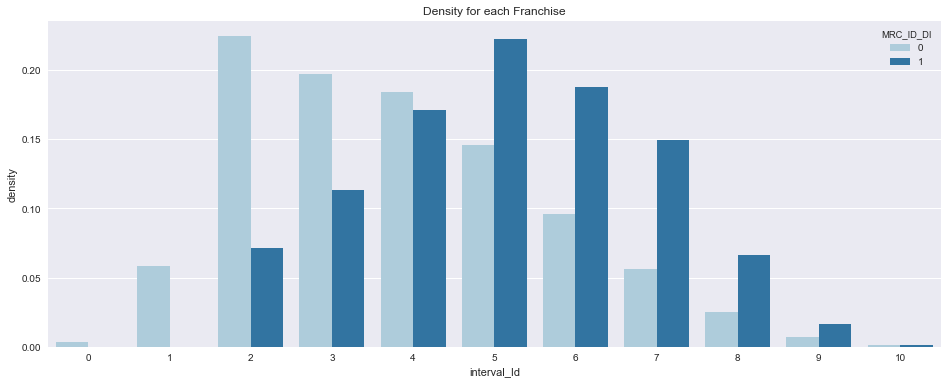

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


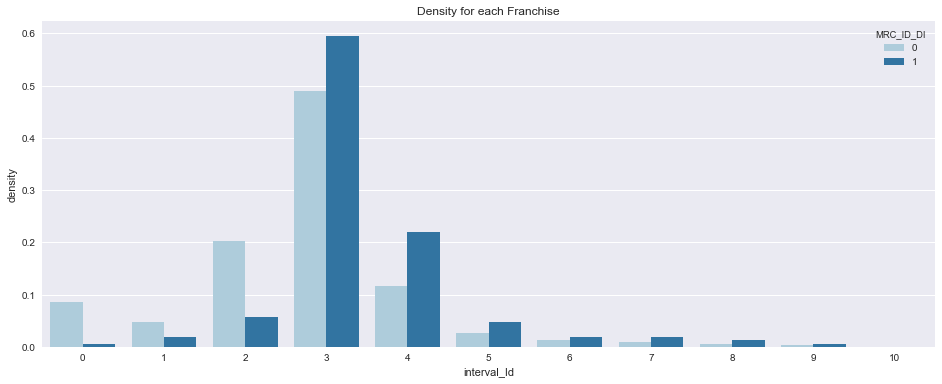

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


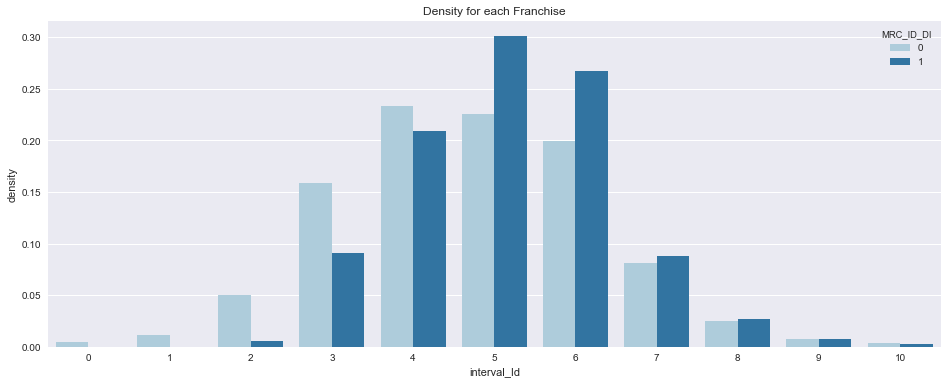

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


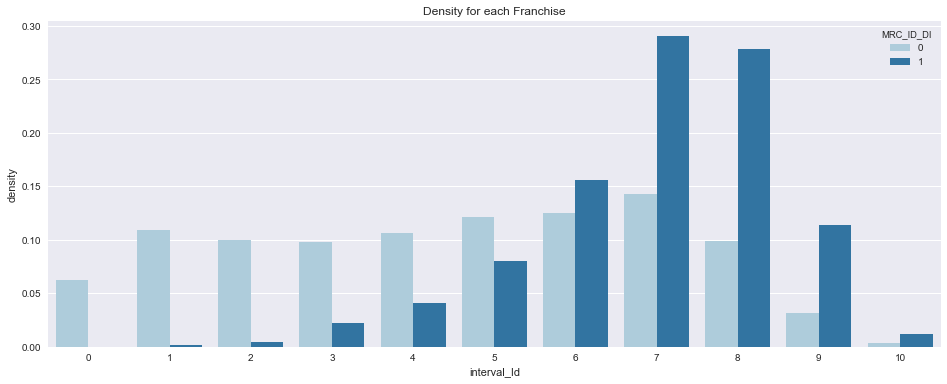

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


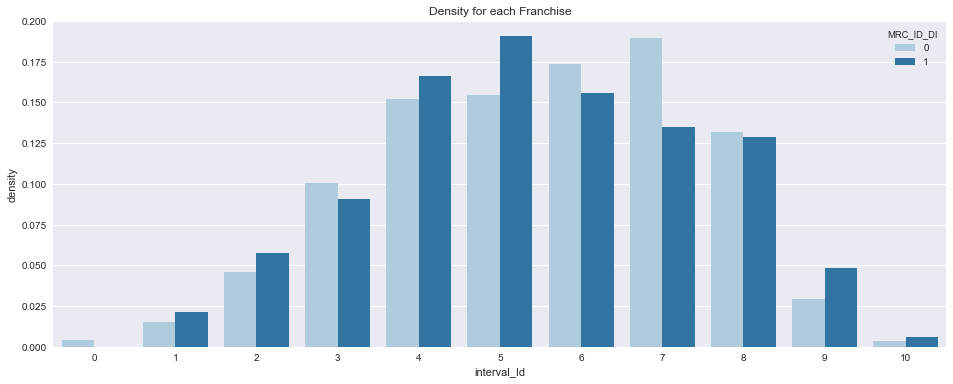

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


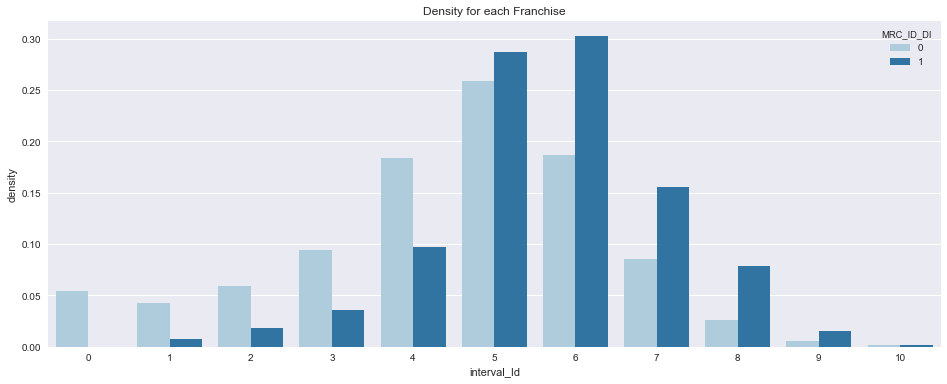

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


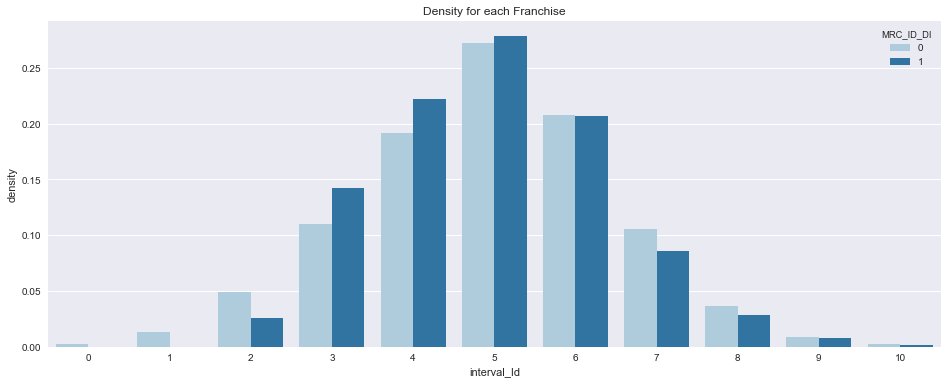

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


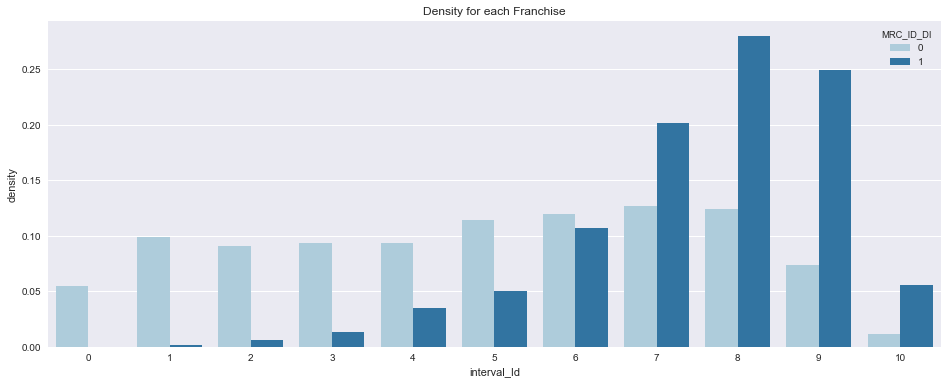

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


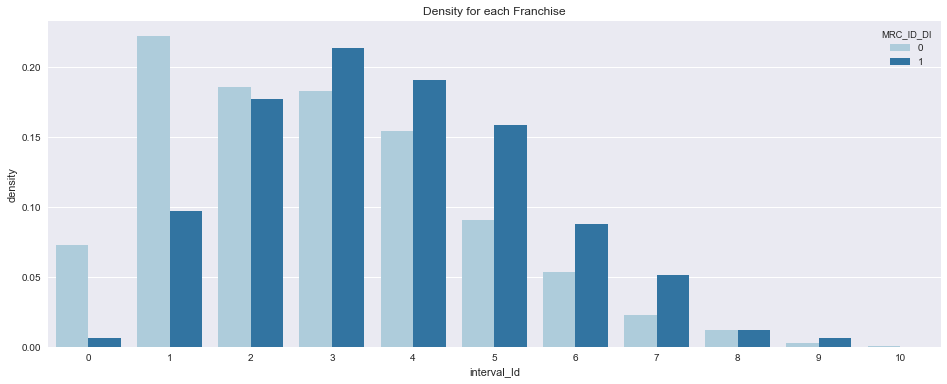

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


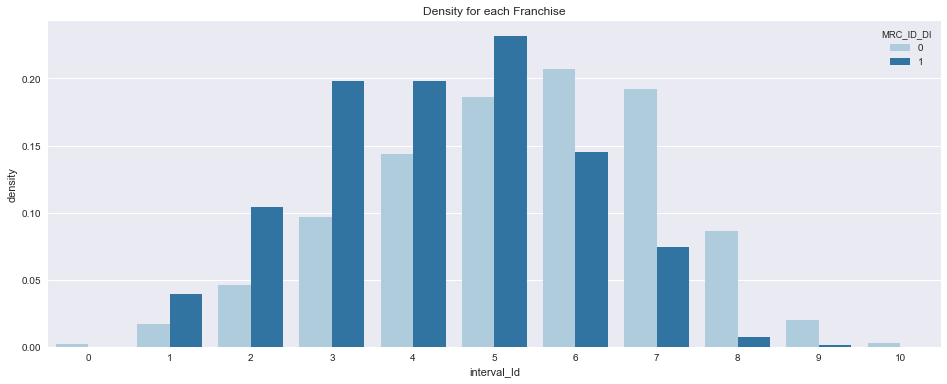

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


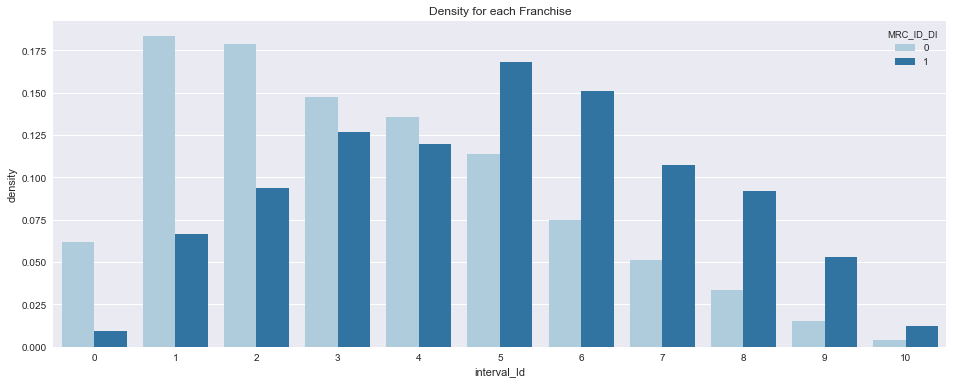

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


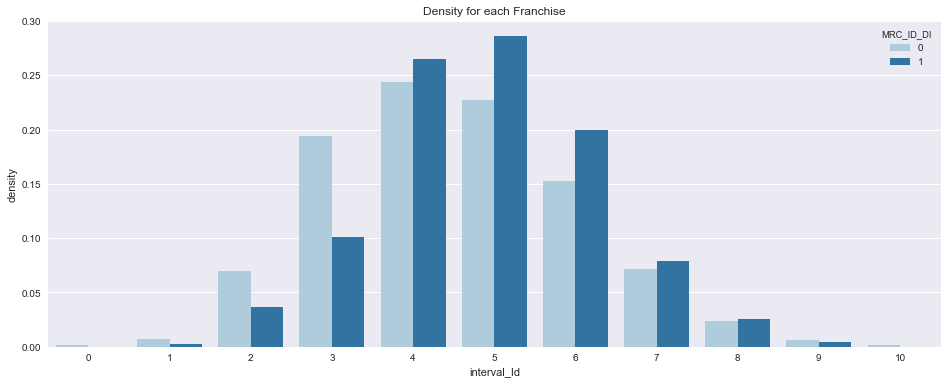

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


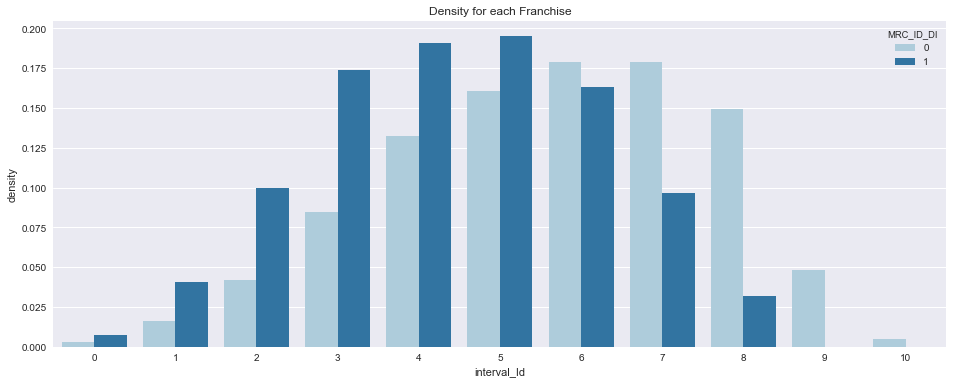

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


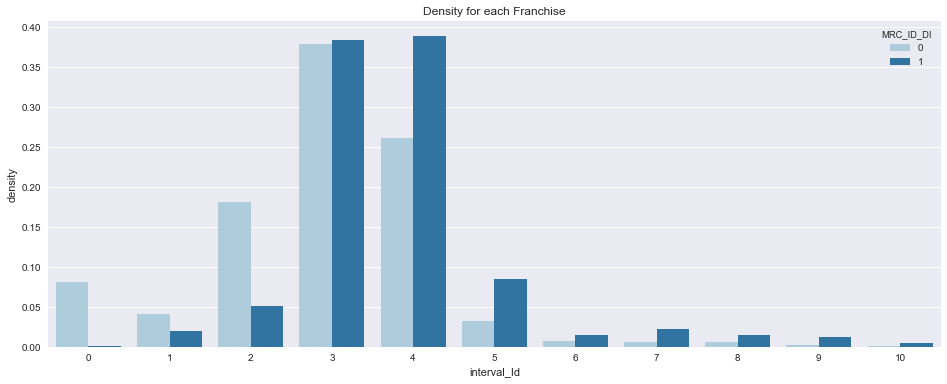

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


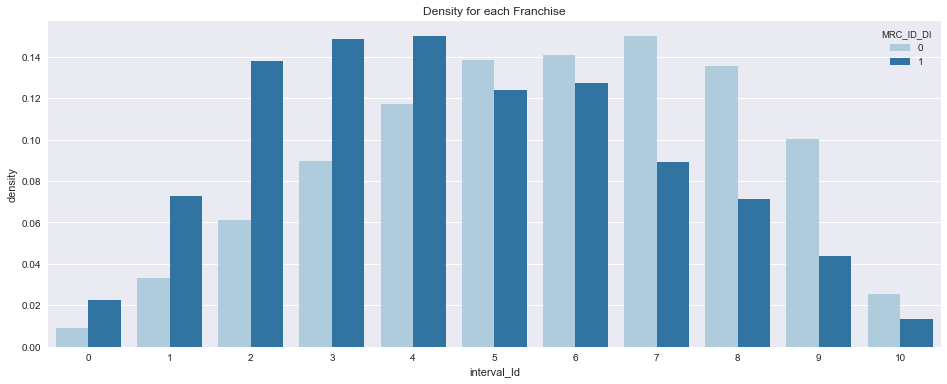

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


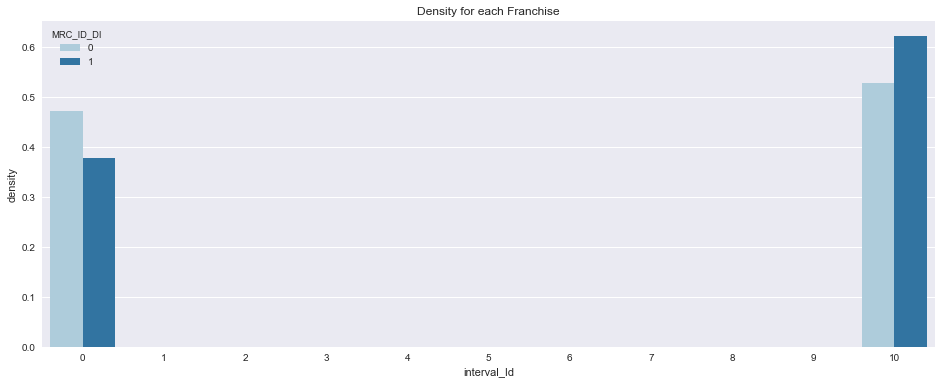

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


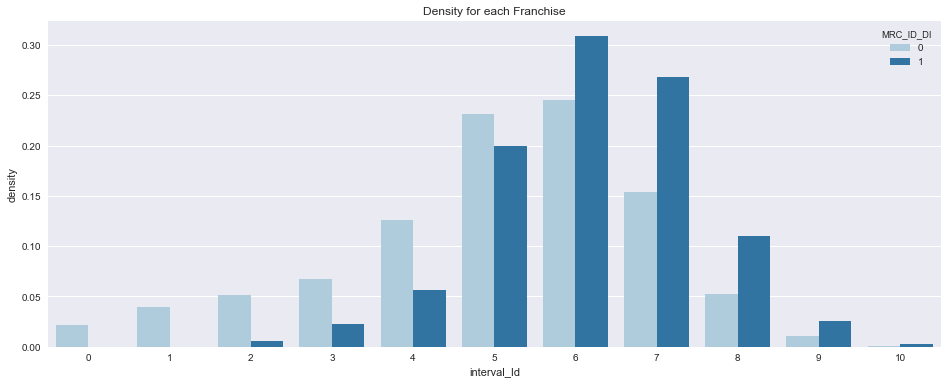

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


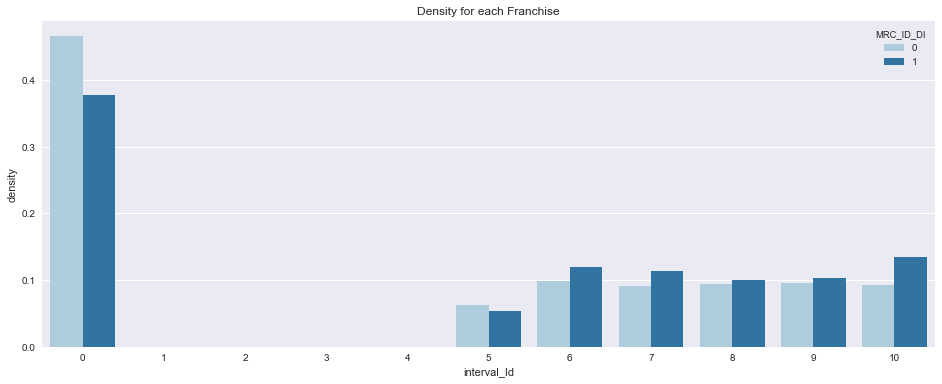

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


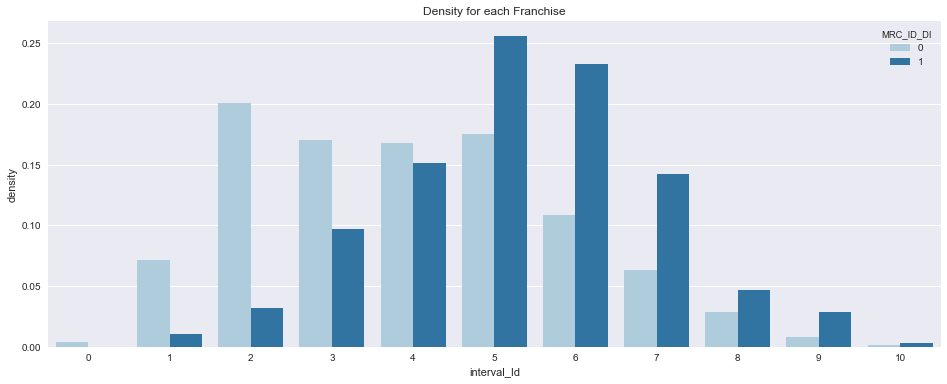

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


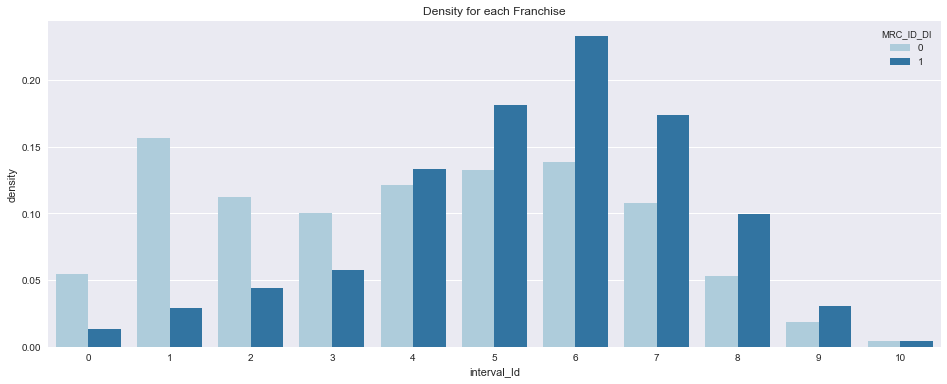

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


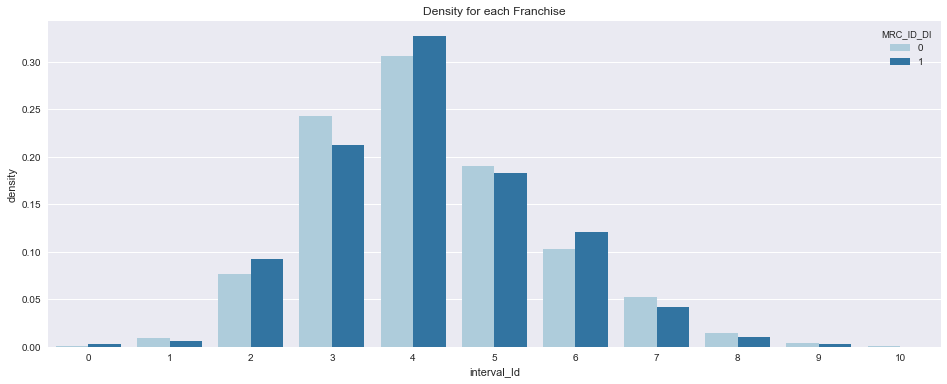

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


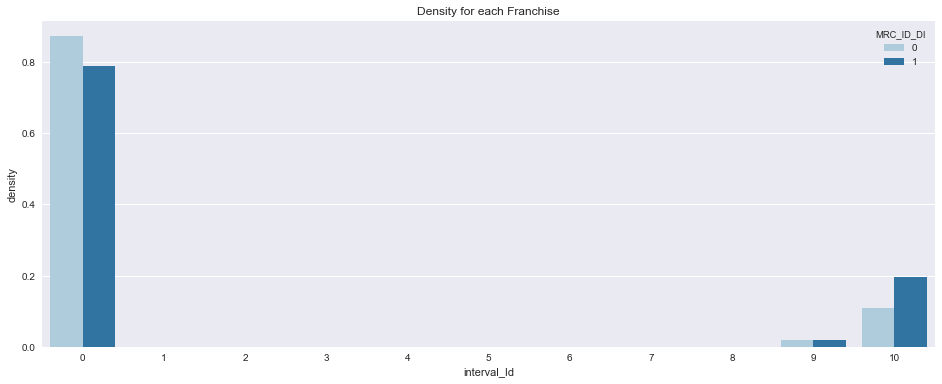

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


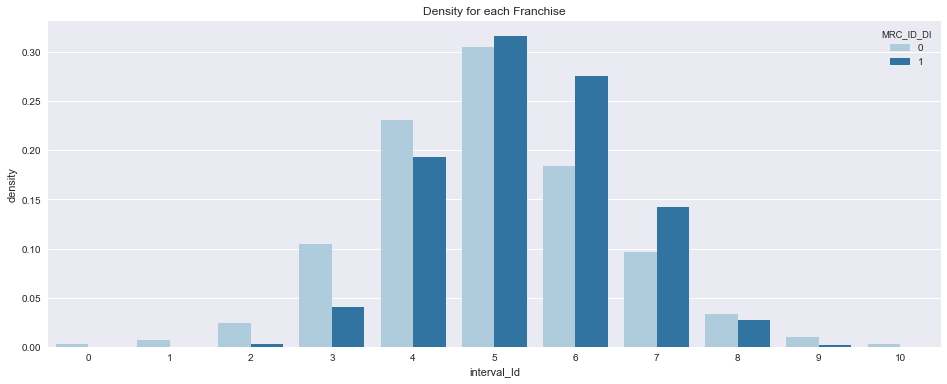

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


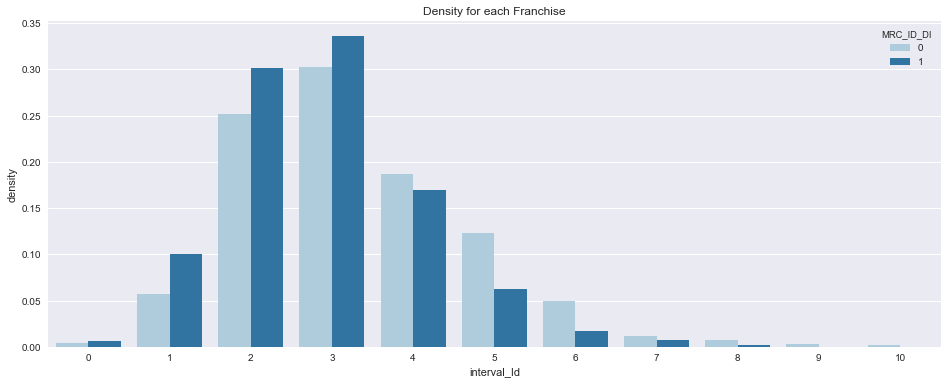

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


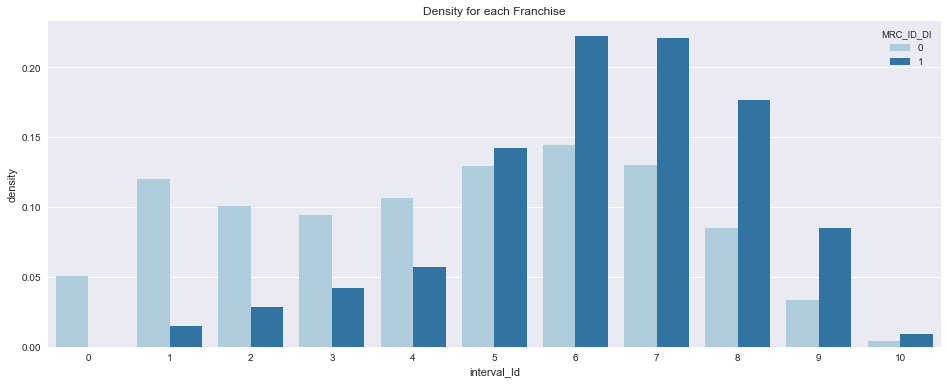

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


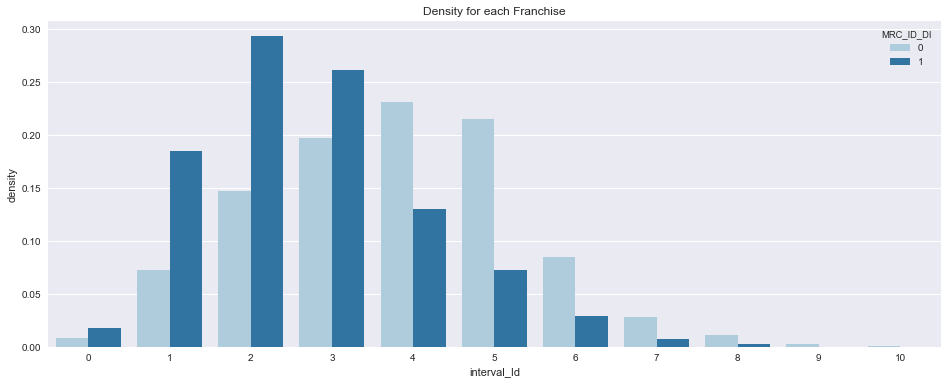

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


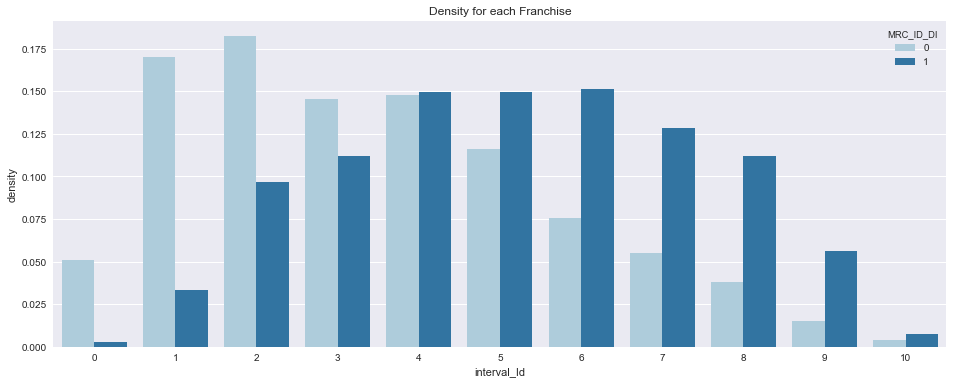

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


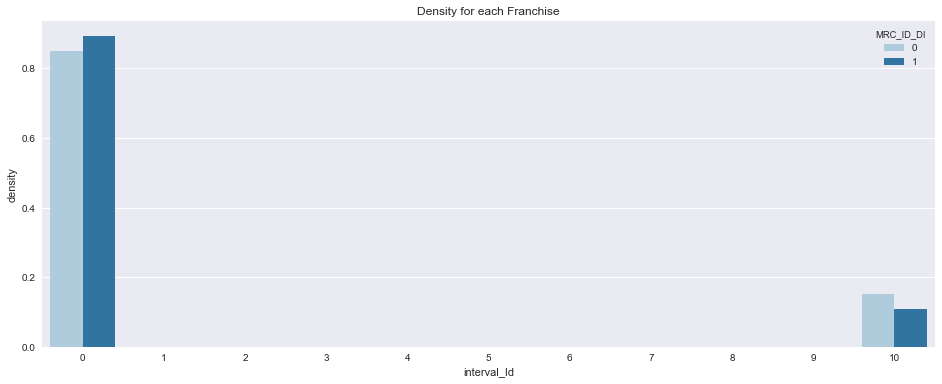

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


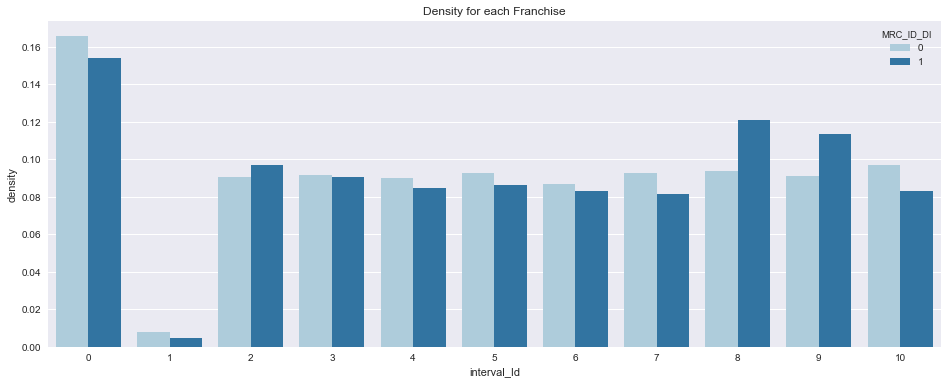

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


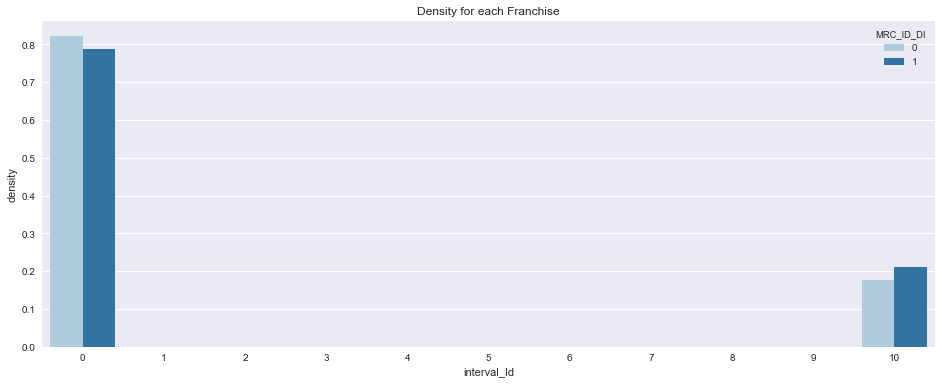

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


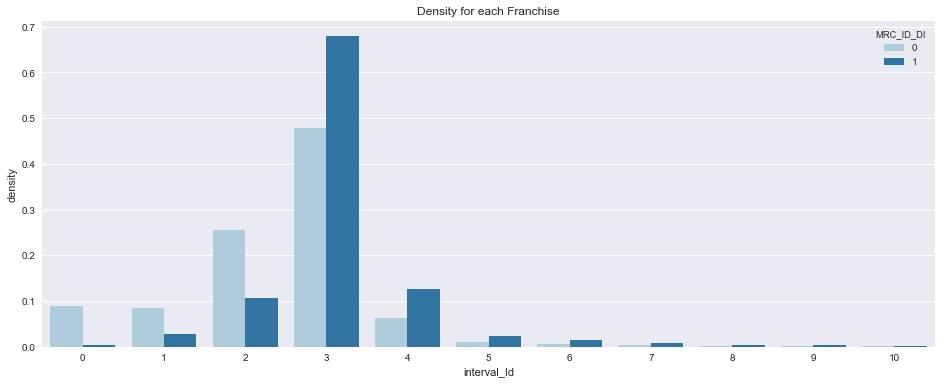

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


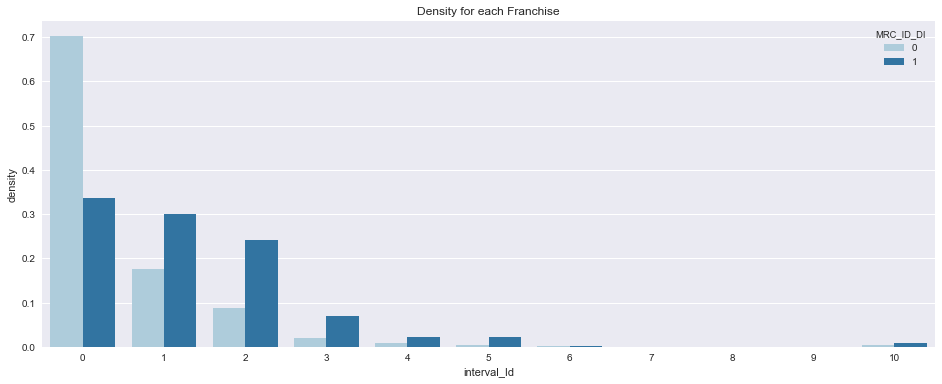

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


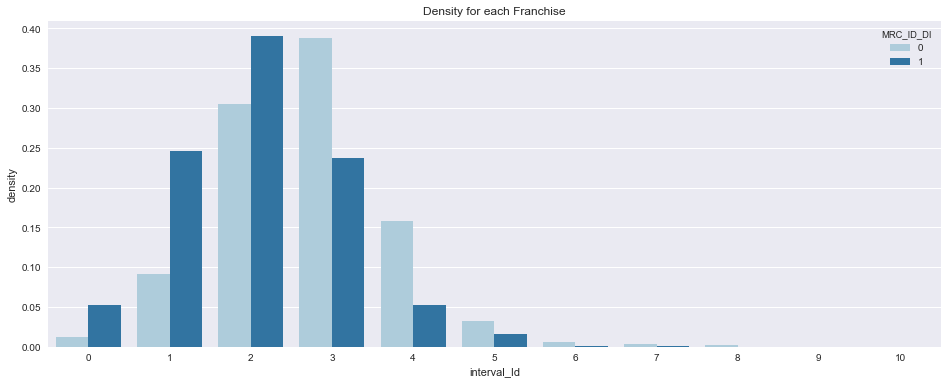

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


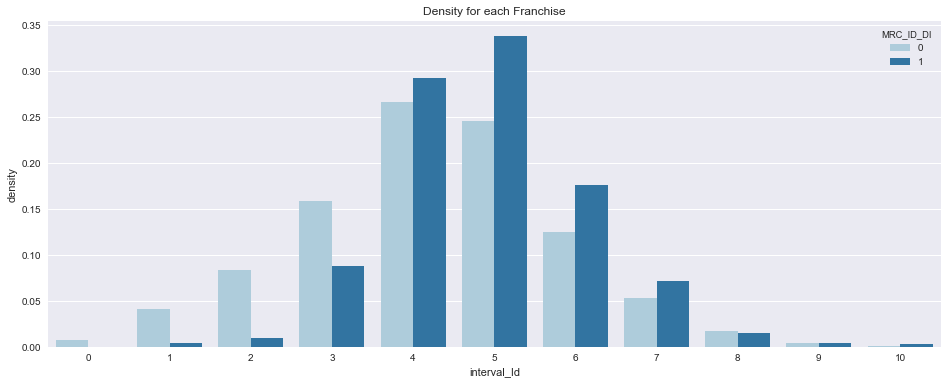

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


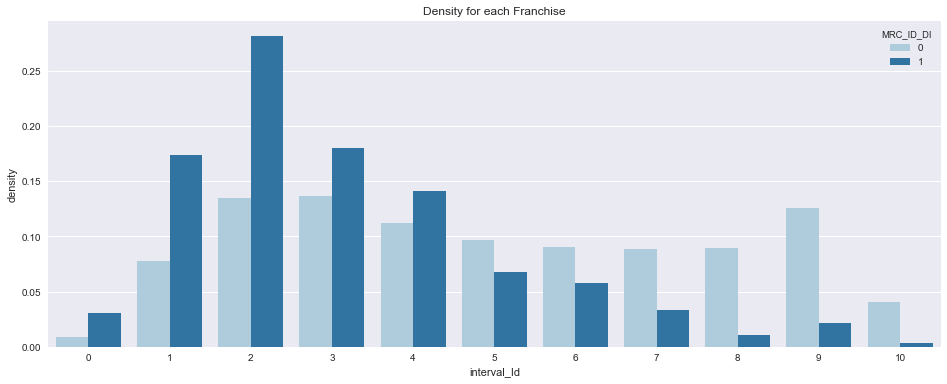

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


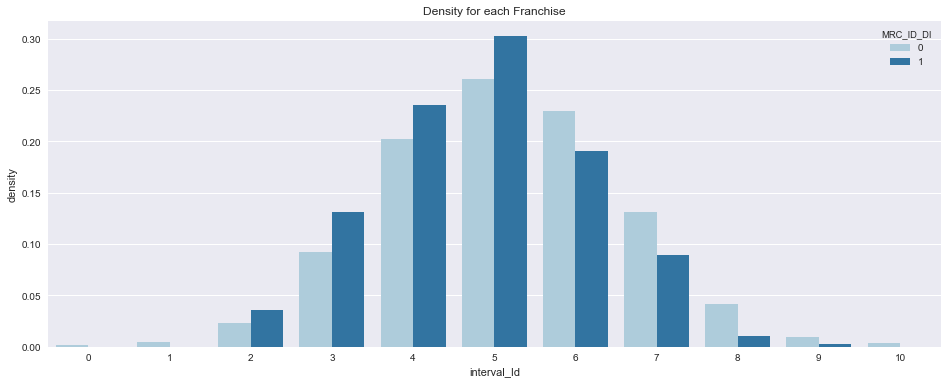

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


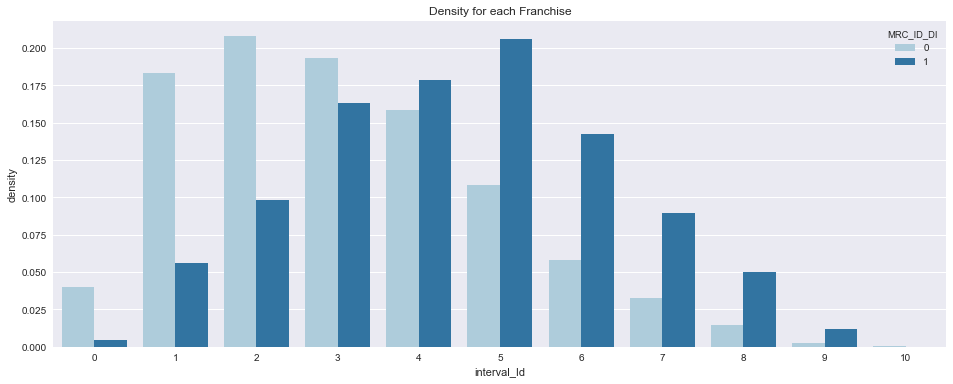

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


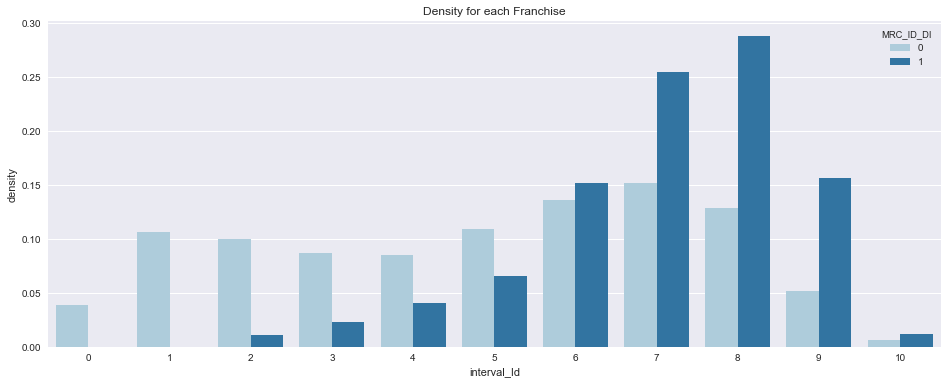

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


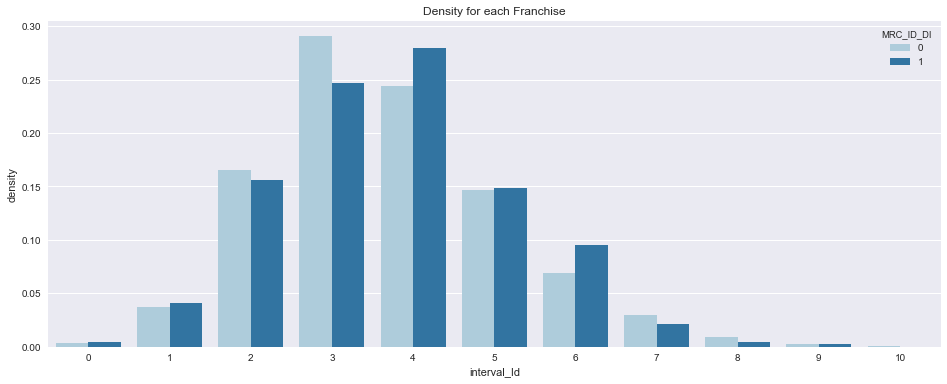

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


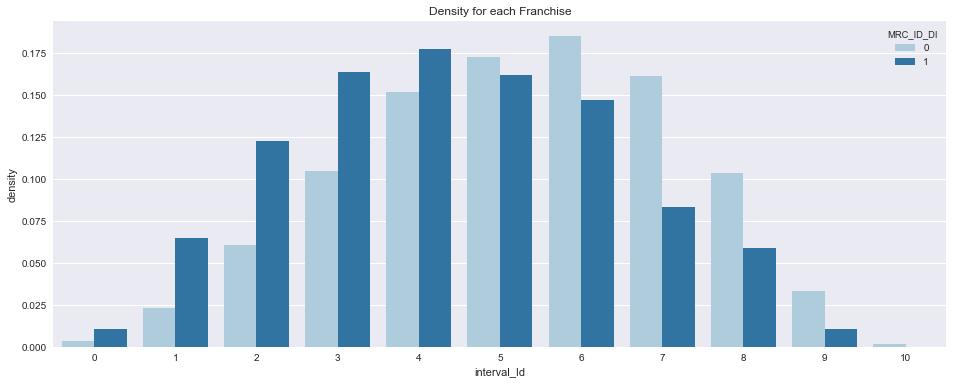

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


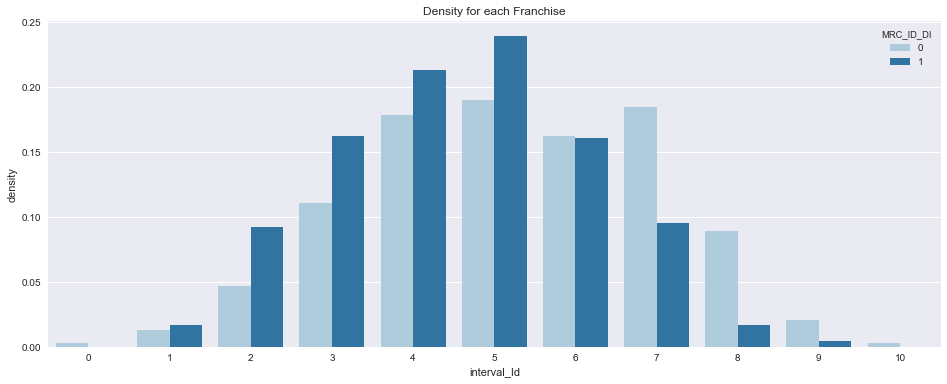

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


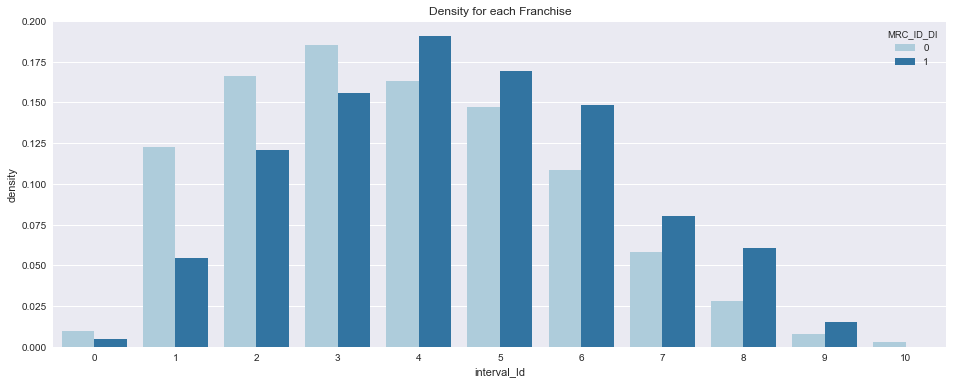

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


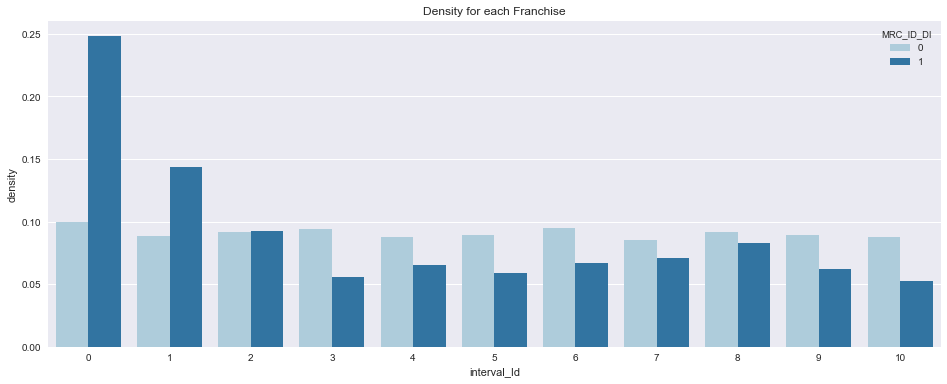

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


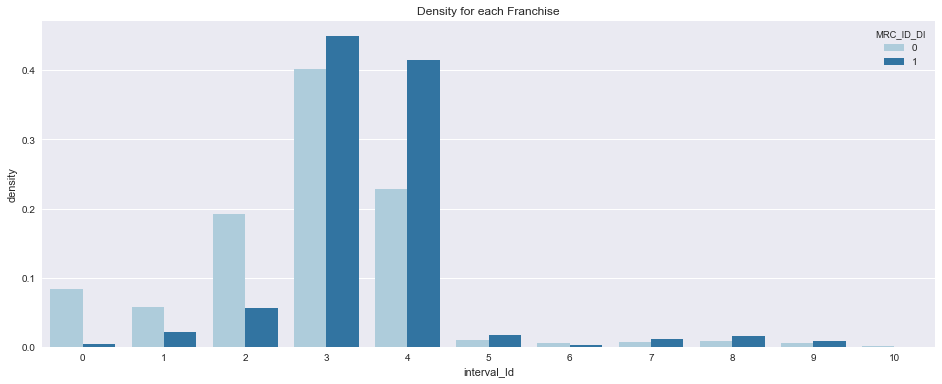

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


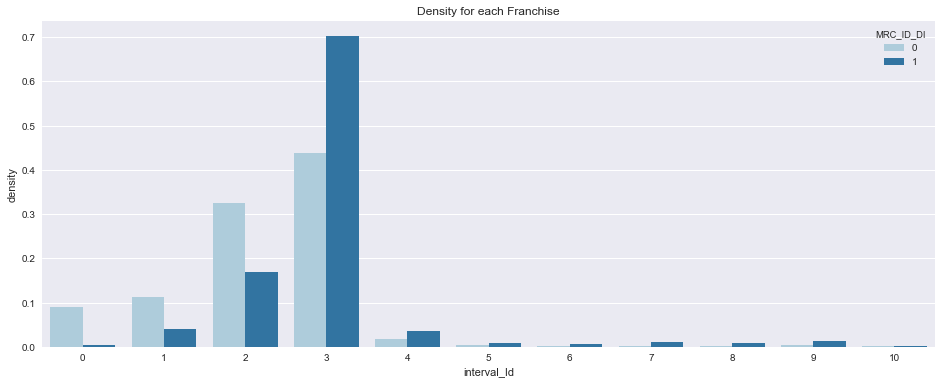

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


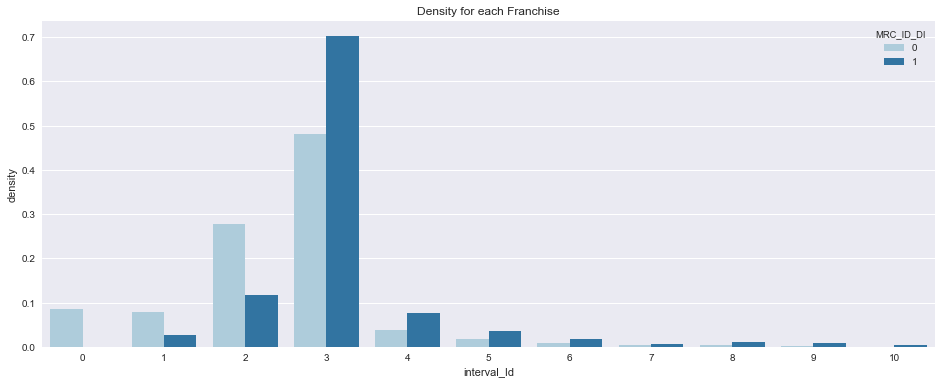

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


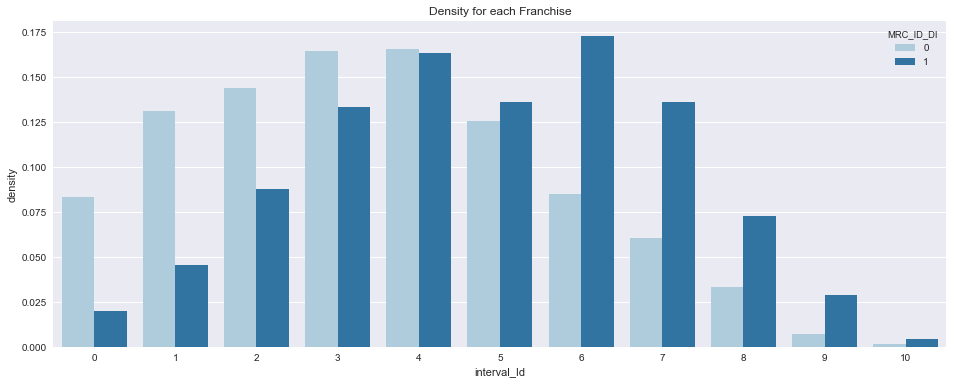

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


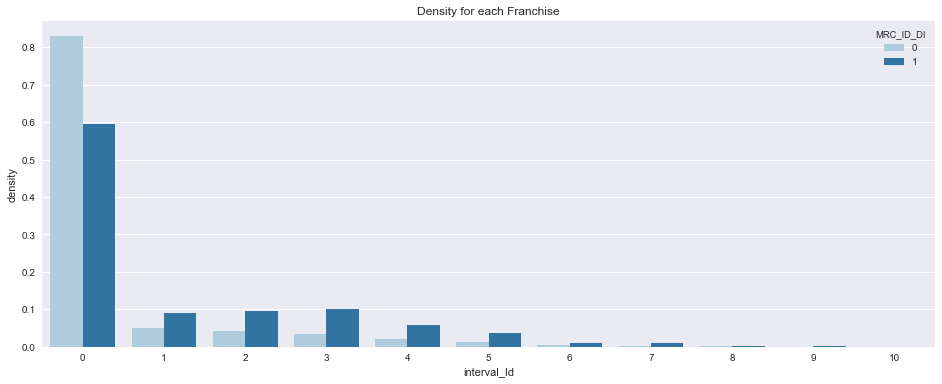

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


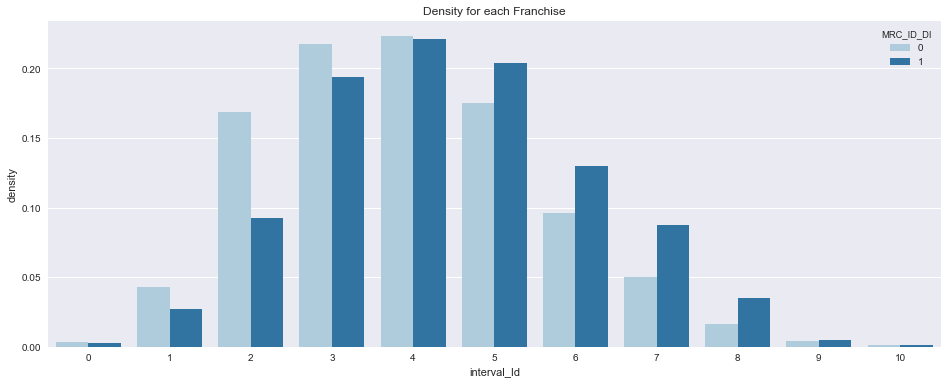

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


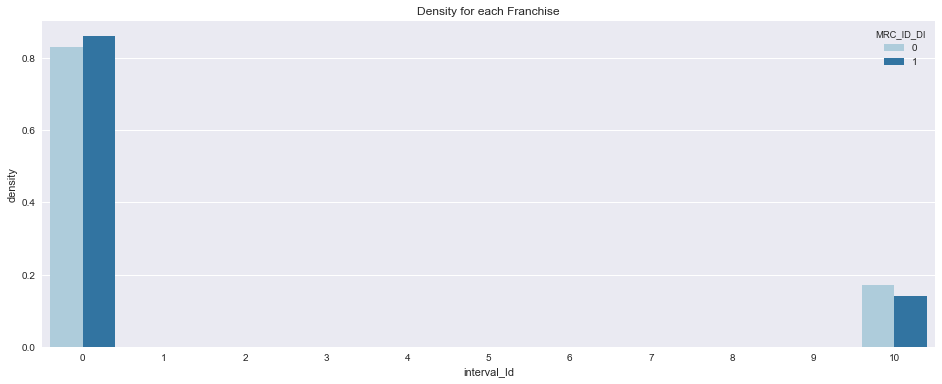

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


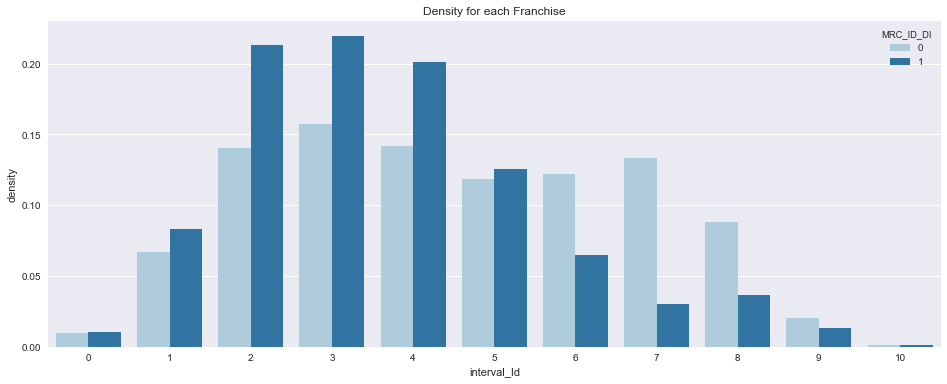

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


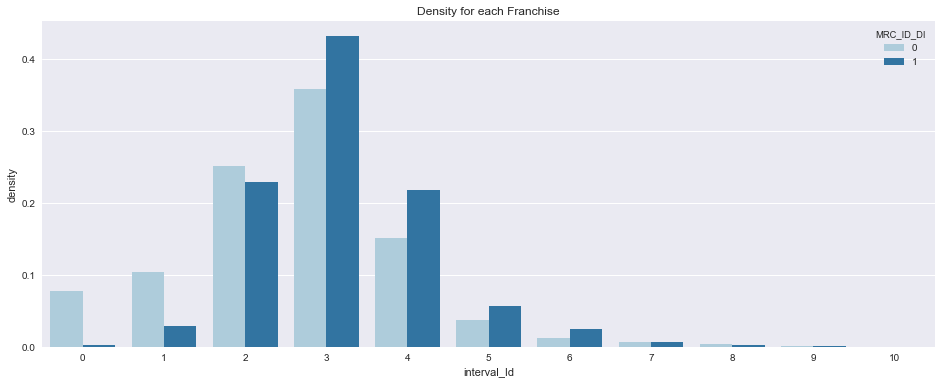

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


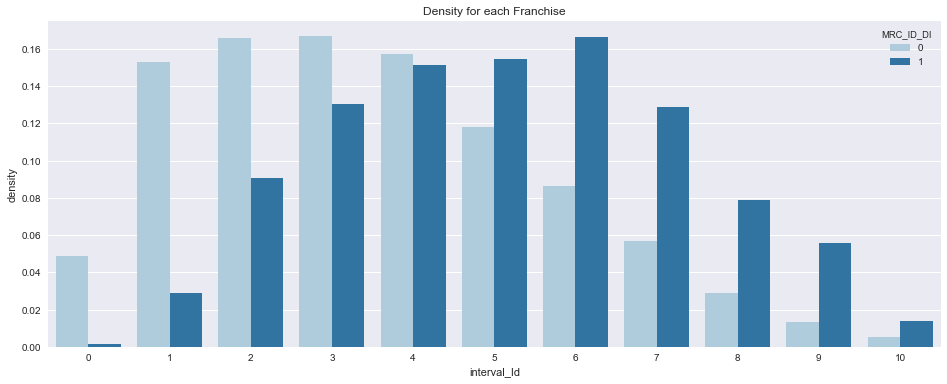

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


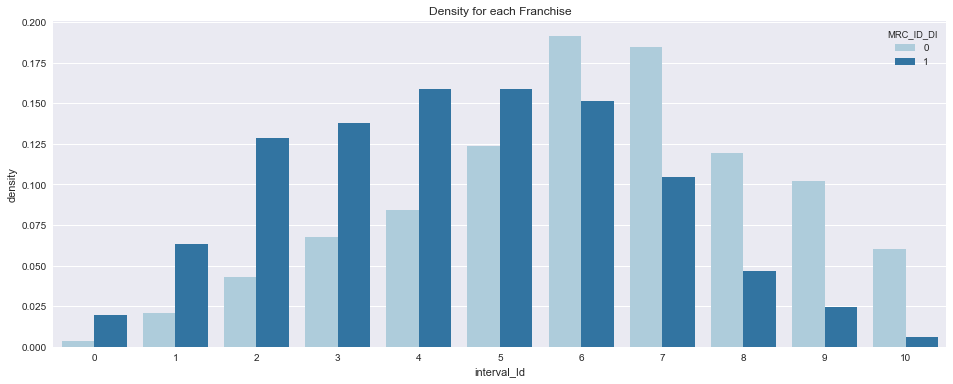

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


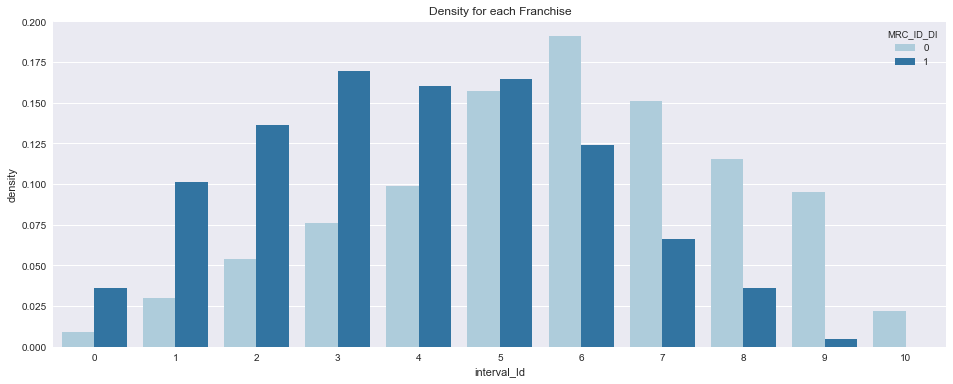

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


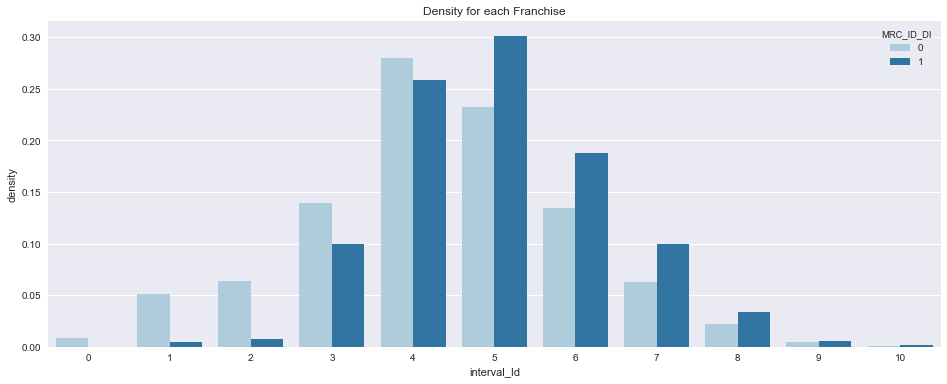

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


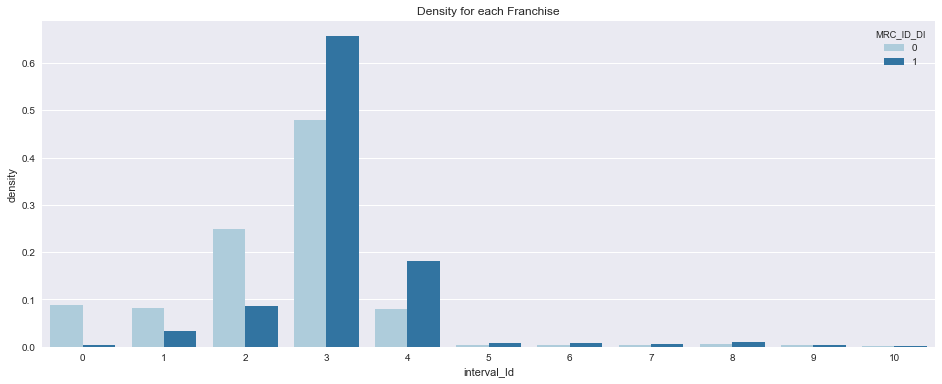

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


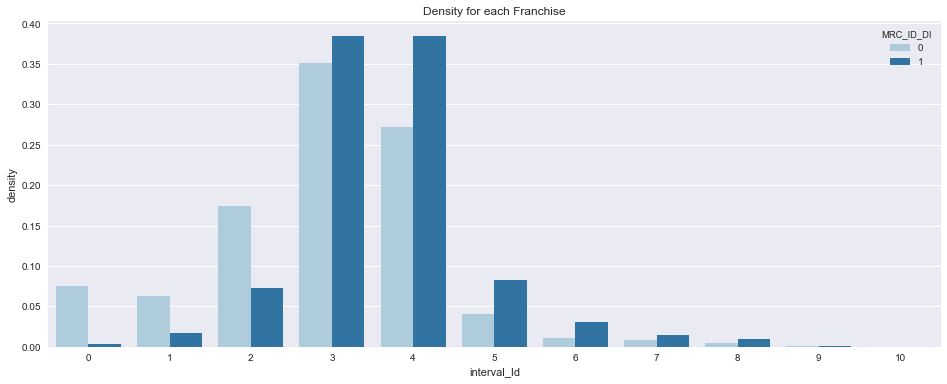

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


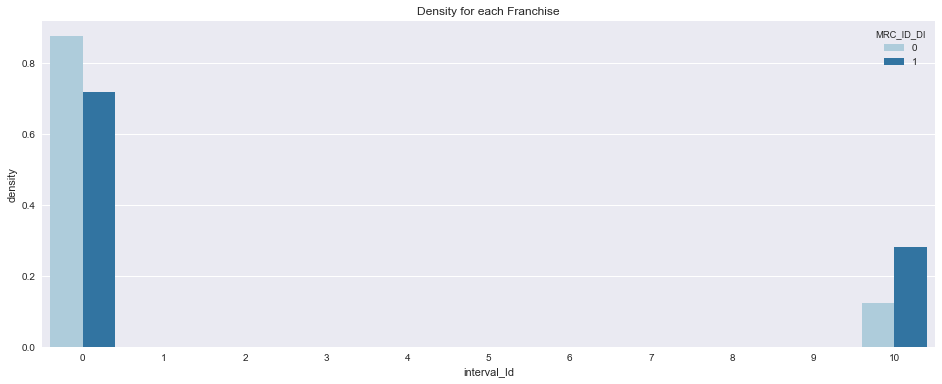

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


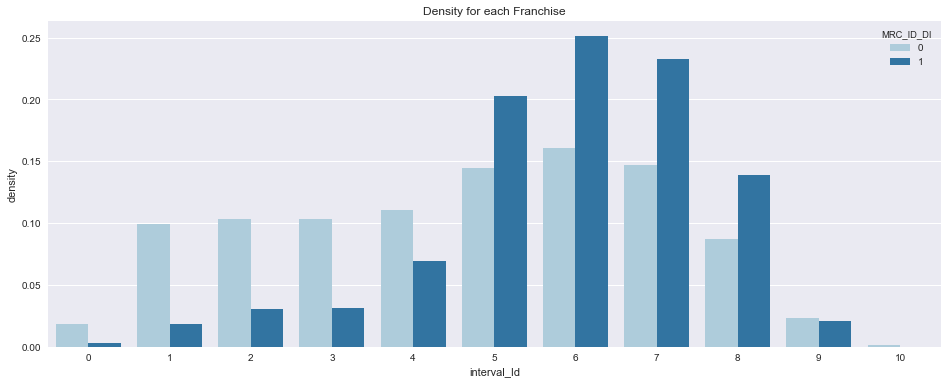

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


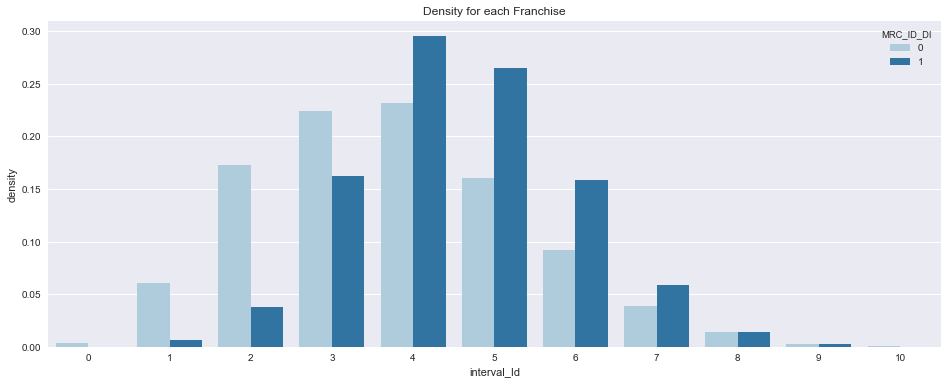

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


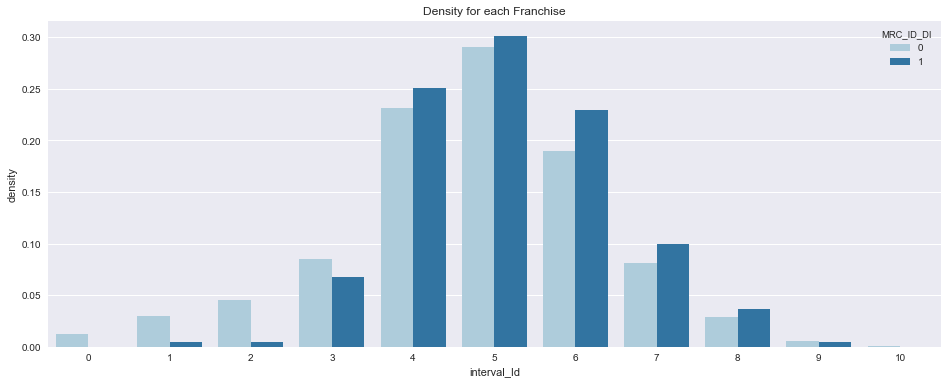

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


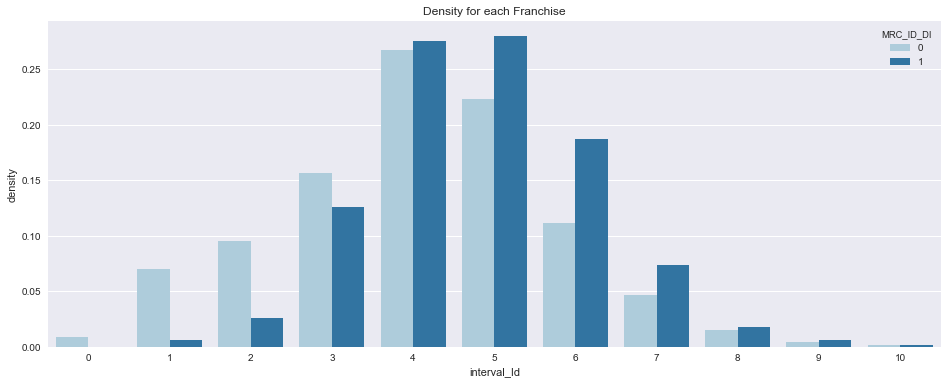

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


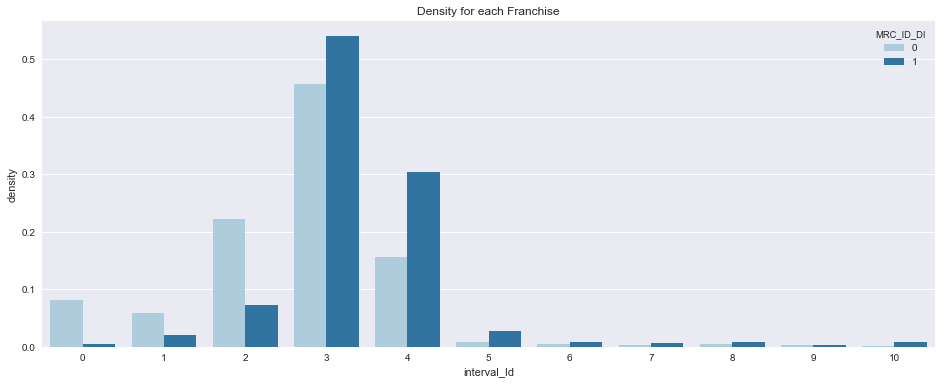

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


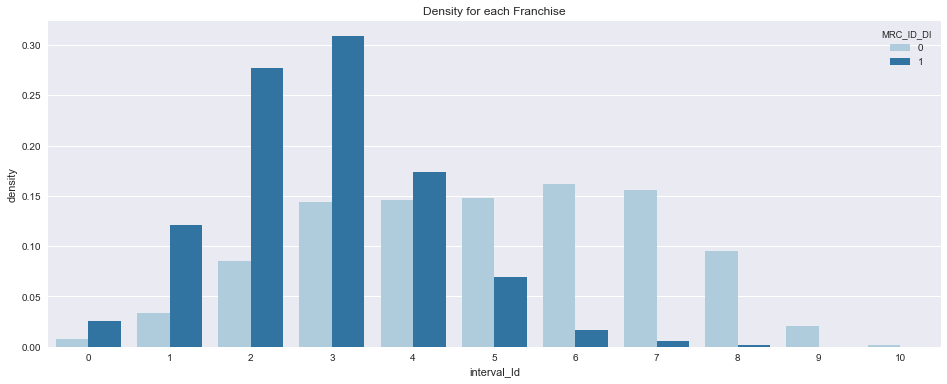

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


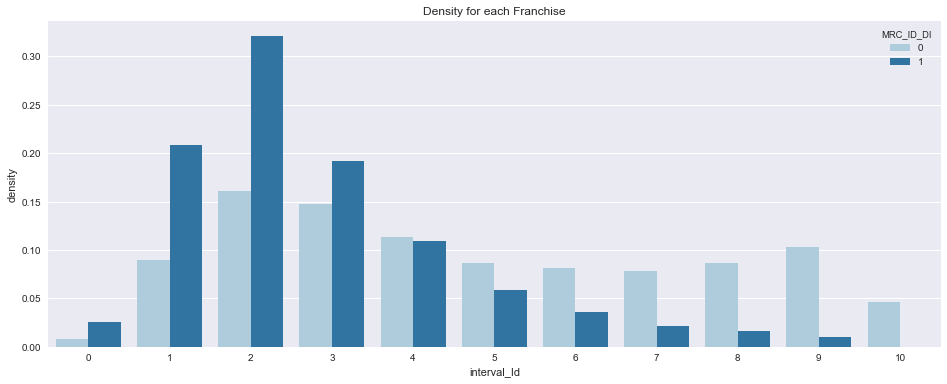

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


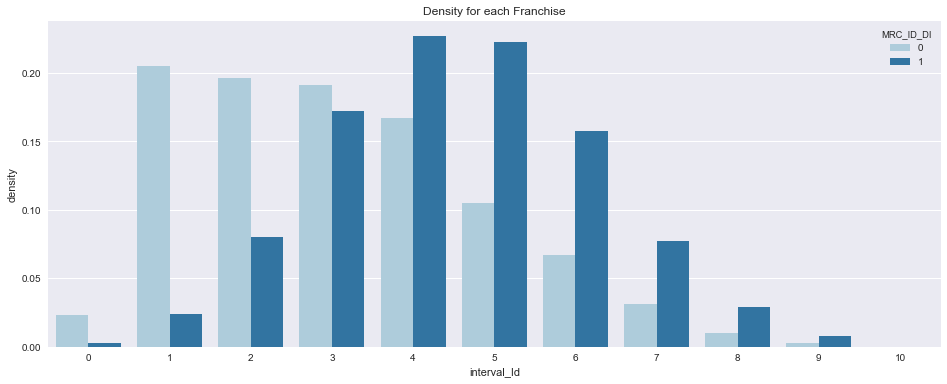

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


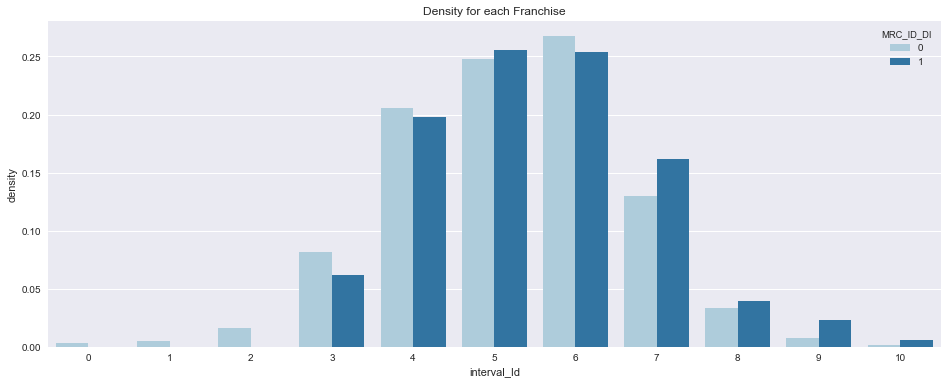

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


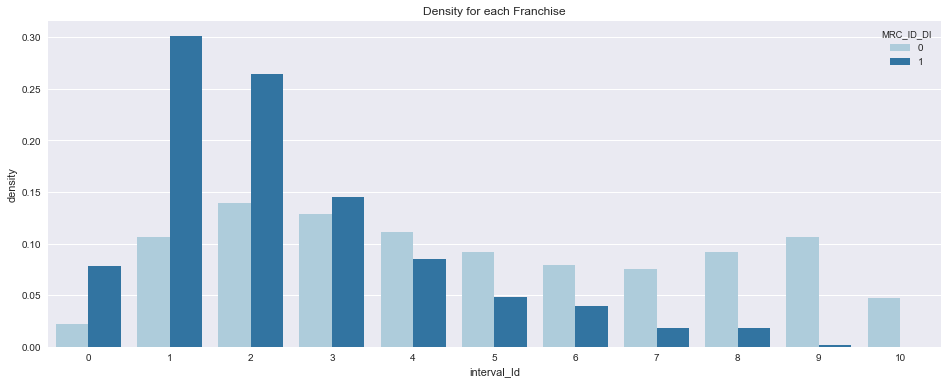

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


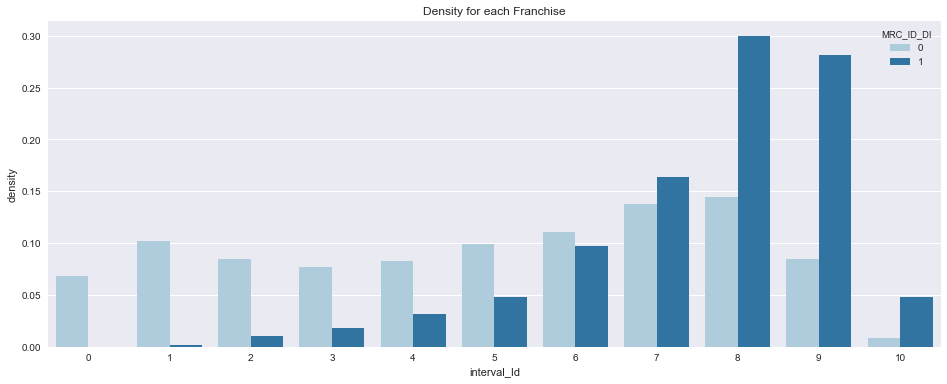

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


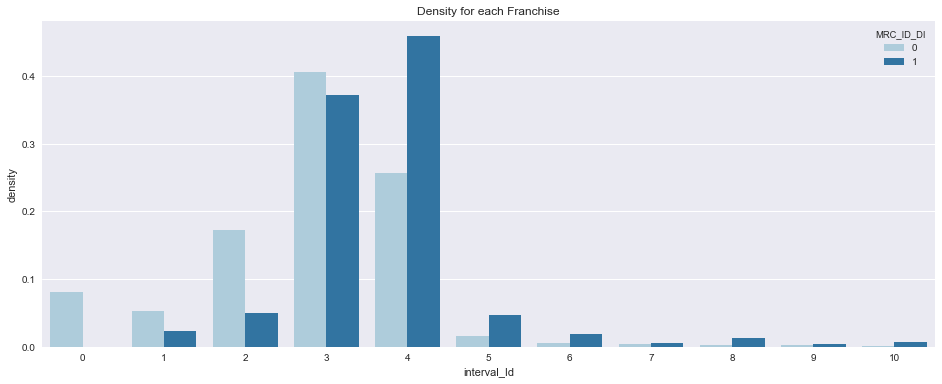

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


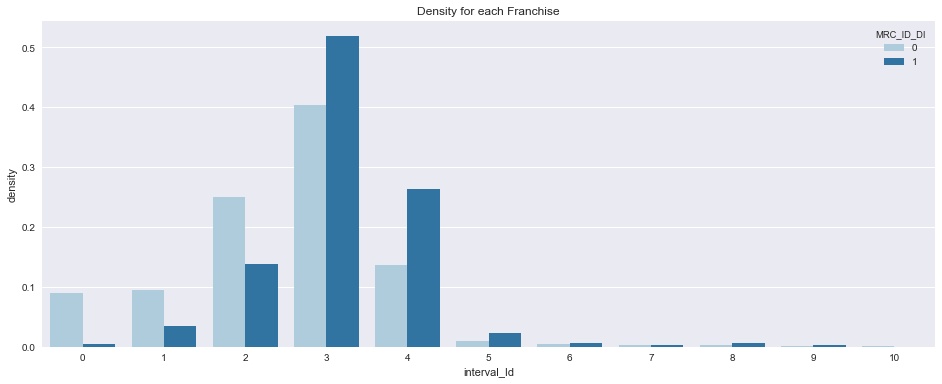

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


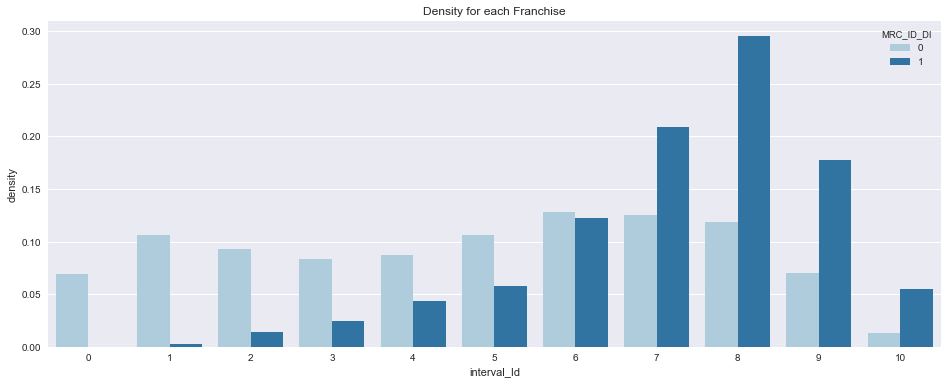

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


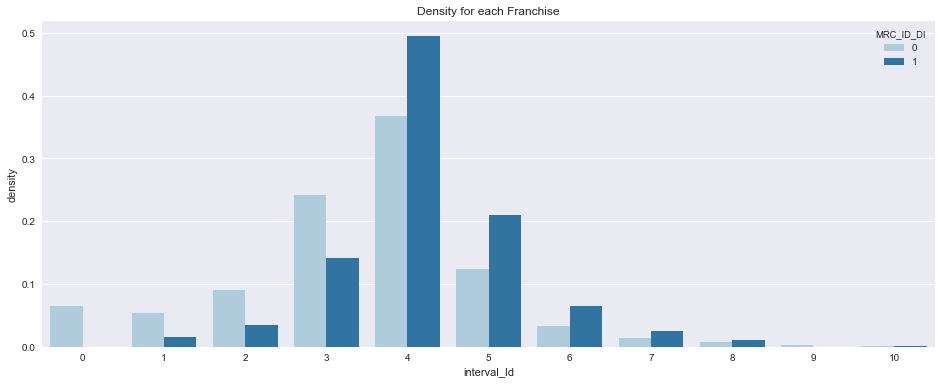

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


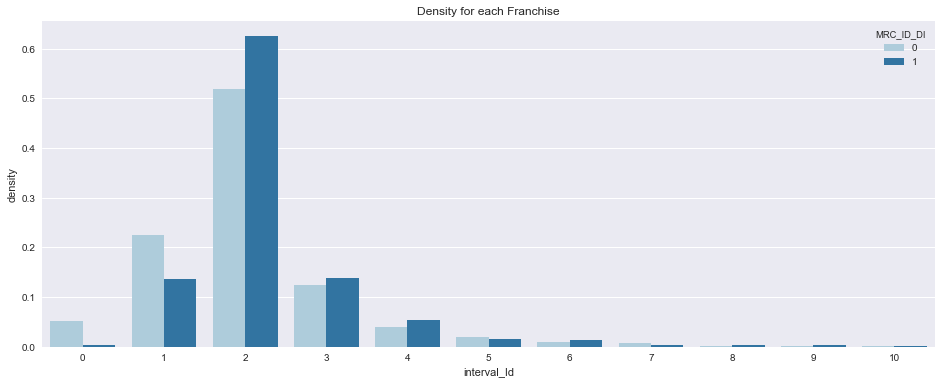

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


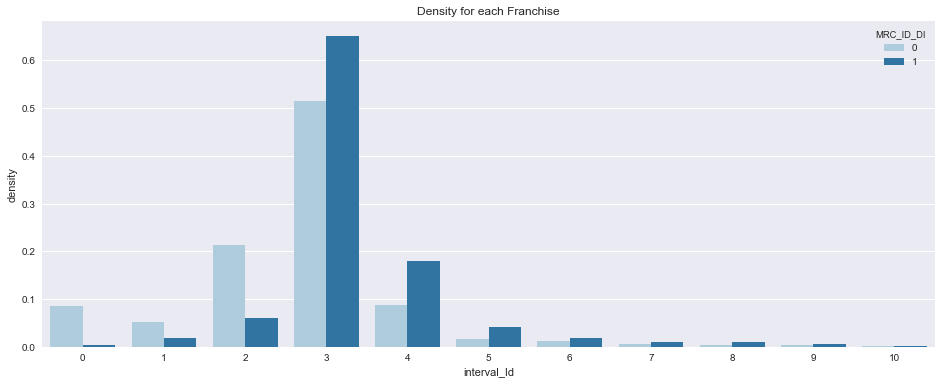

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


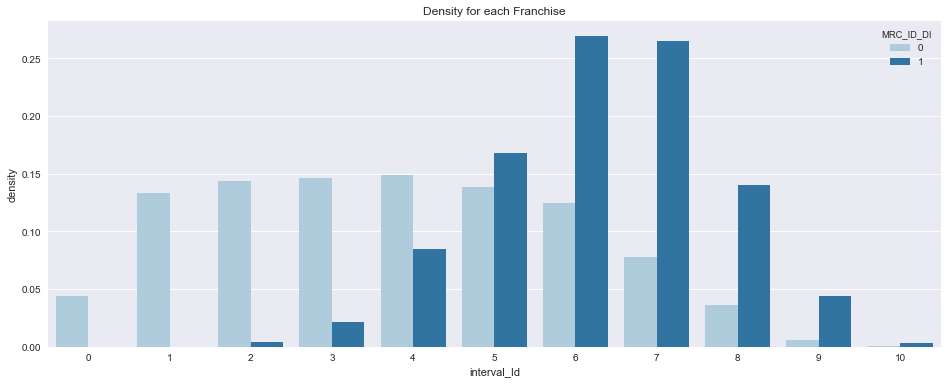

가맹점 Category: 7
회원ID 컬럼 제거 여부: True


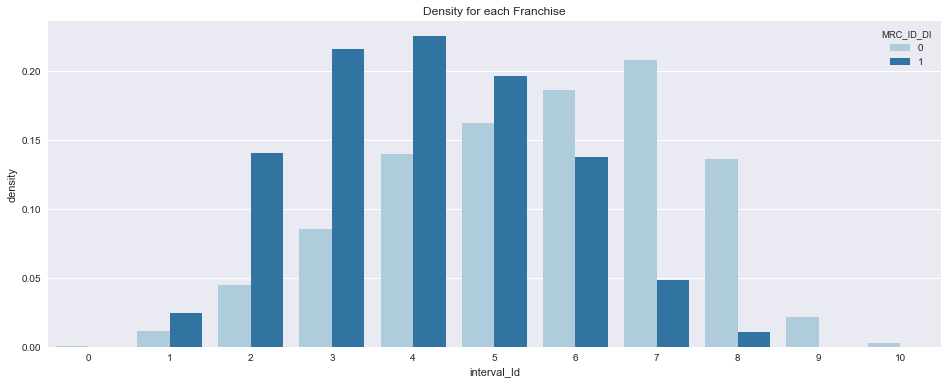

In [116]:
franchise_num = 7
std_mean_dict = dict()
std_std_dict = dict()
for var in list(train_raw.columns[1:-1]):
    temp = showFranchiseDensity(data=franchiseLabeling(franchise_num=franchise_num, dropID=True),
                            var_num=var,
                            franchise_group=[0, 1],
                            plot=True
                        )
    std_mean_dict[var] = temp.groupby('interval_Id')['density'].std().mean()
    std_std_dict[var] = temp.groupby('interval_Id')['density'].std().std()
    

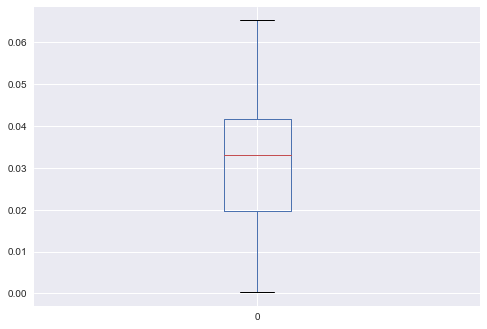

In [122]:
pd.DataFrame(list(std_mean_dict.values())).boxplot()

In [162]:
statsForFeatureSelection = pd.DataFrame()
for f in range(11):
    franchise_num = f
    std_mean_dict = dict()
    std_std_dict = dict()
    for var in list(train_raw.columns[1:-1]):
        temp = showFranchiseDensity(data=franchiseLabeling(franchise_num=franchise_num, 
                                                           dropID=True,
                                                           verbose=False),
                                    var_num=var,
                                    franchise_group=[0, 1],
                                    plot=False
                                   )
        std_mean_dict[var] = [temp.groupby('interval_Id')['density'].std().mean()]
        std_std_dict[var] = [temp.groupby('interval_Id')['density'].std().std()]
    
    temp = pd.DataFrame(std_mean_dict)
    temp['std_mean'] = np.array(list(std_mean_dict.values())).mean()
    temp['std_std'] = np.array(list(std_mean_dict.values())).std()
    statsForFeatureSelection = pd.concat([statsForFeatureSelection, temp], axis=0, ignore_index=True)
statsForFeatureSelection.to_csv('../etc/notebooks/interesting_data/histogram_statistics.csv', index=False)

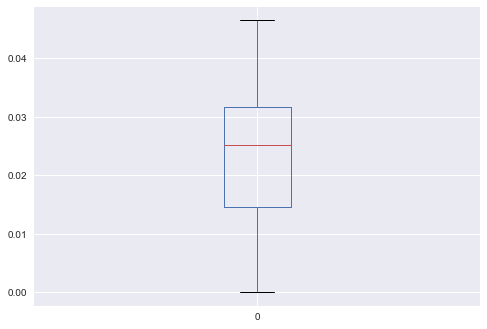

In [127]:
pd.DataFrame(list(std_mean_dict.values())).boxplot()